# QUBO Formulation for Sudoku: A Visual Guide

**Author:** Jonah Minkoff | **Date:** 2025

## Table of Contents

1. [Problem Definition](#1-problem-definition)
2. [Mathematical Formulation](#2-mathematical-formulation)
3. [QUBO Construction](#3-qubo-construction)
4. [Worked Example: 4×4 Sudoku](#4-worked-example)
5. [Component Analysis](#5-component-analysis--visualization)
6. [Variable Elimination](#6-variable-elimination--reduction)
7. [Scaling to 9×9](#7-scaling-to-9×9)
8. [Simulated Annealing](#8-classical-baseline-simulated-annealing)


---
# 1. Problem Definition

## The Sudoku Problem

Sudoku is a **constraint satisfaction puzzle** where we fill an N×N grid with digits 1 through N.

### The Four Golden Rules

Every valid Sudoku solution must satisfy:

| Constraint | Description |
|------------|-------------|
| **Rule 1: Cell Uniqueness** | Each cell contains exactly one digit |
| **Rule 2: Row Uniqueness** | Each row contains each digit exactly once |
| **Rule 3: Column Uniqueness** | Each column contains each digit exactly once |
| **Rule 4: Box Uniqueness** | Each box contains each digit exactly once |

### Problem Sizes

**4×4 Sudoku:**
- 4 rows × 4 columns = 16 cells
- 4 boxes of size 2×2
- Digits: 1, 2, 3, 4

**9×9 Sudoku:**
- 9 rows × 9 columns = 81 cells
- 9 boxes of size 3×3  
- Digits: 1, 2, 3, 4, 5, 6, 7, 8, 9

### What are "Givens"?

**Givens** (or clues) are pre-filled cells that:
- Reduce the search space
- Make the puzzle solvable with unique solution
- Will be fixed in our QUBO formulation

---
# 2. Mathematical Formulation

## Binary Variable Encoding

We use **one-hot encoding** to represent which digit goes in each cell:

$$x_{i,j,k} = \begin{cases}
1 & \text{if cell }(i,j)\text{ contains digit }k+1 \\
0 & \text{otherwise}
\end{cases}$$

### Index Notation

- $i \in \{0, 1, ..., N-1\}$ — row index
- $j \in \{0, 1, ..., N-1\}$ — column index
- $k \in \{0, 1, ..., N-1\}$ — digit index (k=0 means digit 1, k=1 means digit 2, etc.)

### Problem Scale

| Sudoku Size | Binary Variables | Typical Givens | Free Variables |
|-------------|------------------|----------------|----------------|
| 4×4 | 64 | 6-8 | ~48-56 |
| 9×9 | 729 | 25-30 | ~675-700 |
| 16×16 | 4,096 | 100-120 | ~3,900-3,950 |

## Energy Function: Converting Constraints to Penalties

The total energy is the sum of all constraint violations:

$$E_{\text{total}} = E_1 + E_2 + E_3 + E_4$$

Each constraint is formulated as a **squared penalty** that equals zero when satisfied:

### E₁: Cell Uniqueness
$$E_1 = \sum_{i,j} \left(\sum_k x_{i,j,k} - 1\right)^2$$

**Interpretation:** For each cell, the sum of all digit indicators should equal 1.

### E₂: Row Uniqueness
$$E_2 = \sum_{i,k} \left(\sum_j x_{i,j,k} - 1\right)^2$$

**Interpretation:** In each row, each digit should appear exactly once.

### E₃: Column Uniqueness
$$E_3 = \sum_{j,k} \left(\sum_i x_{i,j,k} - 1\right)^2$$

**Interpretation:** In each column, each digit should appear exactly once.

### E₄: Box Uniqueness
$$E_4 = \sum_{\text{box},k} \left(\sum_{(i,j) \in \text{box}} x_{i,j,k} - 1\right)^2$$

**Interpretation:** In each box, each digit should appear exactly once.

## 💡 Key Insight

A valid Sudoku solution has $E_{\text{total}} = 0$ (all constraints satisfied). Any invalid configuration has $E_{\text{total}} > 0$.

---
# 3. QUBO Construction

## Setup: Generating Support Files

First, we'll create three Python modules that contain our QUBO construction functions. These have been pre-tested and validated.

### Module 1: QUBO Generation (`qubo_generation.py`)

This module contains the core QUBO construction logic.

In [ ]:
# @title qubo_generation
%%writefile qubo_generation.py

"""
Sudoku QUBO Construction
Builds full QUBO matrices for Sudoku puzzles.
"""

import numpy as np


def build_sudoku_qubo(N, box_size, givens=None, L1=1.0, L2=1.0, L3=1.0, L4=1.0):
    """
    Build complete QUBO matrix for Sudoku.

    Args:
        N: Sudoku size (4 for 4x4, 9 for 9x9)
        box_size: Box size (2 for 4x4, 3 for 9x9)
        givens: Dict {(i,j): digit} for known cells (1-indexed digits)
        L1, L2, L3, L4: Lagrange multipliers

    Returns:
        Q: QUBO matrix (N³ × N³)
        var_to_idx: Dict mapping (i,j,k) → index
        idx_to_var: Dict mapping index → (i,j,k)
        constant_offset: Constant term
    """
    n_vars = N * N * N
    Q = np.zeros((n_vars, n_vars))
    constant_offset = 0.0

    var_to_idx = {}
    idx_to_var = {}
    idx = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                var_to_idx[(i, j, k)] = idx
                idx_to_var[idx] = (i, j, k)
                idx += 1

    def add_quadratic(var1, var2, coeff):
        idx1 = var_to_idx[var1]
        idx2 = var_to_idx[var2]
        if idx1 <= idx2:
            Q[idx1, idx2] += coeff
        else:
            Q[idx2, idx1] += coeff

    def add_linear(var, coeff):
        idx = var_to_idx[var]
        Q[idx, idx] += coeff

    # E1: Each cell has exactly one digit
    for i in range(N):
        for j in range(N):
            if givens and (i, j) in givens:
                continue

            for k in range(N):
                add_linear((i, j, k), -L1)

            for k in range(N):
                for kp in range(k + 1, N):
                    add_quadratic((i, j, k), (i, j, kp), 2 * L1)

            constant_offset += L1

    # E2: Each row has each digit exactly once
    for i in range(N):
        for k in range(N):
            given_count = 0
            free_cells = []

            for j in range(N):
                if givens and (i, j) in givens:
                    if givens[(i, j)] == k + 1:
                        given_count += 1
                else:
                    free_cells.append(j)

            if given_count == 1 and len(free_cells) == 0:
                continue

            target_adjustment = 1 - given_count

            for j in free_cells:
                add_linear((i, j, k), L2 * (1 - 2 * target_adjustment))

            for j_idx, j in enumerate(free_cells):
                for jp in free_cells[j_idx + 1:]:
                    add_quadratic((i, j, k), (i, jp, k), 2 * L2)

            constant_offset += L2 * (target_adjustment ** 2)

    # E3: Each column has each digit exactly once
    for j in range(N):
        for k in range(N):
            given_count = 0
            free_cells = []

            for i in range(N):
                if givens and (i, j) in givens:
                    if givens[(i, j)] == k + 1:
                        given_count += 1
                else:
                    free_cells.append(i)

            if given_count == 1 and len(free_cells) == 0:
                continue

            target_adjustment = 1 - given_count

            for i in free_cells:
                add_linear((i, j, k), L3 * (1 - 2 * target_adjustment))

            for i_idx, i in enumerate(free_cells):
                for ip in free_cells[i_idx + 1:]:
                    add_quadratic((i, j, k), (ip, j, k), 2 * L3)

            constant_offset += L3 * (target_adjustment ** 2)

    # E4: Each box has each digit exactly once
    boxes_per_side = N // box_size

    for box_row in range(boxes_per_side):
        for box_col in range(boxes_per_side):
            for k in range(N):
                given_count = 0
                free_cells = []

                for i in range(box_row * box_size, (box_row + 1) * box_size):
                    for j in range(box_col * box_size, (box_col + 1) * box_size):
                        if givens and (i, j) in givens:
                            if givens[(i, j)] == k + 1:
                                given_count += 1
                        else:
                            free_cells.append((i, j))

                if given_count == 1 and len(free_cells) == 0:
                    continue

                target_adjustment = 1 - given_count

                for (i, j) in free_cells:
                    add_linear((i, j, k), L4 * (1 - 2 * target_adjustment))

                for cell_idx, (i, j) in enumerate(free_cells):
                    for (ip, jp) in free_cells[cell_idx + 1:]:
                        add_quadratic((i, j, k), (ip, jp, k), 2 * L4)

                constant_offset += L4 * (target_adjustment ** 2)

    return Q, var_to_idx, idx_to_var, constant_offset


def evaluate_qubo(Q, bitstring, constant_offset=0):
    """
    Evaluate QUBO energy: E = x^T Q x + constant

    Args:
        Q: QUBO matrix
        bitstring: Binary string (spaces allowed)
        constant_offset: Constant term

    Returns:
        Energy value
    """
    x = np.array([int(b) for b in bitstring.replace(' ', '')])

    energy = constant_offset

    for i in range(len(x)):
        energy += Q[i, i] * x[i]

    for i in range(len(x)):
        for j in range(i + 1, len(x)):
            energy += 2 * Q[i, j] * x[i] * x[j]

    return energy


def build_E1(N, givens=None, L1=1.0):
    """Build E1: Each cell has exactly one digit"""
    n_vars = N * N * N
    Q = np.zeros((n_vars, n_vars))
    constant = 0.0
    poly_terms = []

    var_to_idx = {}
    idx = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                var_to_idx[(i, j, k)] = idx
                idx += 1

    for i in range(N):
        for j in range(N):
            if givens and (i, j) in givens:
                continue

            for k in range(N):
                idx = var_to_idx[(i, j, k)]
                Q[idx, idx] += -L1
                poly_terms.append(f"-{L1:.0f}*x_{i}{j}{k}")

            for k in range(N):
                for kp in range(k + 1, N):
                    idx1 = var_to_idx[(i, j, k)]
                    idx2 = var_to_idx[(i, j, kp)]
                    Q[idx1, idx2] += 2 * L1
                    poly_terms.append(f"{2*L1:.0f}*x_{i}{j}{k}*x_{i}{j}{kp}")

            constant += L1

    return Q, poly_terms, constant


def build_E2(N, givens=None, L2=1.0):
    """Build E2: Each row has each digit exactly once"""
    n_vars = N * N * N
    Q = np.zeros((n_vars, n_vars))
    constant = 0.0
    poly_terms = []

    var_to_idx = {}
    idx = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                var_to_idx[(i, j, k)] = idx
                idx += 1

    for i in range(N):
        for k in range(N):
            given_count = 0
            free_cells = []

            for j in range(N):
                if givens and (i, j) in givens:
                    if givens[(i, j)] == k + 1:
                        given_count += 1
                else:
                    free_cells.append(j)

            if given_count == 1 and len(free_cells) == 0:
                continue

            target_adjustment = 1 - given_count

            for j in free_cells:
                idx = var_to_idx[(i, j, k)]
                coeff = L2 * (1 - 2 * target_adjustment)
                Q[idx, idx] += coeff
                if coeff != 0:
                    poly_terms.append(f"{coeff:.1f}*x_{i}{j}{k}")

            for j_idx, j in enumerate(free_cells):
                for jp in free_cells[j_idx + 1:]:
                    idx1 = var_to_idx[(i, j, k)]
                    idx2 = var_to_idx[(i, jp, k)]
                    Q[idx1, idx2] += 2 * L2
                    poly_terms.append(f"{2*L2:.0f}*x_{i}{j}{k}*x_{i}{jp}{k}")

            constant += L2 * (target_adjustment ** 2)

    return Q, poly_terms, constant


def build_E3(N, givens=None, L3=1.0):
    """Build E3: Each column has each digit exactly once"""
    n_vars = N * N * N
    Q = np.zeros((n_vars, n_vars))
    constant = 0.0
    poly_terms = []

    var_to_idx = {}
    idx = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                var_to_idx[(i, j, k)] = idx
                idx += 1

    for j in range(N):
        for k in range(N):
            given_count = 0
            free_cells = []

            for i in range(N):
                if givens and (i, j) in givens:
                    if givens[(i, j)] == k + 1:
                        given_count += 1
                else:
                    free_cells.append(i)

            if given_count == 1 and len(free_cells) == 0:
                continue

            target_adjustment = 1 - given_count

            for i in free_cells:
                idx = var_to_idx[(i, j, k)]
                coeff = L3 * (1 - 2 * target_adjustment)
                Q[idx, idx] += coeff
                if coeff != 0:
                    poly_terms.append(f"{coeff:.1f}*x_{i}{j}{k}")

            for i_idx, i in enumerate(free_cells):
                for ip in free_cells[i_idx + 1:]:
                    idx1 = var_to_idx[(i, j, k)]
                    idx2 = var_to_idx[(ip, j, k)]
                    Q[idx1, idx2] += 2 * L3
                    poly_terms.append(f"{2*L3:.0f}*x_{i}{j}{k}*x_{ip}{j}{k}")

            constant += L3 * (target_adjustment ** 2)

    return Q, poly_terms, constant


def build_E4(N, box_size, givens=None, L4=1.0):
    """Build E4: Each box has each digit exactly once"""
    n_vars = N * N * N
    Q = np.zeros((n_vars, n_vars))
    constant = 0.0
    poly_terms = []

    var_to_idx = {}
    idx = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                var_to_idx[(i, j, k)] = idx
                idx += 1

    boxes_per_side = N // box_size

    for box_row in range(boxes_per_side):
        for box_col in range(boxes_per_side):
            for k in range(N):
                given_count = 0
                free_cells = []

                for i in range(box_row * box_size, (box_row + 1) * box_size):
                    for j in range(box_col * box_size, (box_col + 1) * box_size):
                        if givens and (i, j) in givens:
                            if givens[(i, j)] == k + 1:
                                given_count += 1
                        else:
                            free_cells.append((i, j))

                if given_count == 1 and len(free_cells) == 0:
                    continue

                target_adjustment = 1 - given_count

                for (i, j) in free_cells:
                    idx = var_to_idx[(i, j, k)]
                    coeff = L4 * (1 - 2 * target_adjustment)
                    Q[idx, idx] += coeff
                    if coeff != 0:
                        poly_terms.append(f"{coeff:.1f}*x_{i}{j}{k}")

                for cell_idx, (i, j) in enumerate(free_cells):
                    for (ip, jp) in free_cells[cell_idx + 1:]:
                        idx1 = var_to_idx[(i, j, k)]
                        idx2 = var_to_idx[(ip, jp, k)]
                        Q[idx1, idx2] += 2 * L4
                        poly_terms.append(f"{2*L4:.0f}*x_{i}{j}{k}*x_{ip}{jp}{k}")

                constant += L4 * (target_adjustment ** 2)

    return Q, poly_terms, constant


def print_E1_details(N, givens=None):
    """Print E1 construction details"""
    Q, _, const = build_E1(N, givens)
    print("E1: Each cell has exactly one digit")
    print(f"Constant: {const}")
    return Q, None, const


def print_E2_details(N, givens=None):
    """Print E2 construction details"""
    Q, _, const = build_E2(N, givens)
    print("E2: Each row has each digit exactly once")
    print(f"Constant: {const}")
    return Q, None, const


def print_E3_details(N, givens=None):
    """Print E3 construction details"""
    Q, _, const = build_E3(N, givens)
    print("E3: Each column has each digit exactly once")
    print(f"Constant: {const}")
    return Q, None, const


def print_E4_details(N, box_size, givens=None):
    """Print E4 construction details"""
    Q, _, const = build_E4(N, box_size, givens)
    print("E4: Each box has each digit exactly once")
    print(f"Constant: {const}")
    return Q, None, const

def print_qubo_stats(Q, N, givens=None):
    """Print statistics about the QUBO matrix"""
    n_vars = N * N * N

    print(f"\nQUBO Matrix Statistics:")
    print(f"  Size: {n_vars} × {n_vars}")
    print(f"  Total possible entries: {n_vars * n_vars:,}")

    # Count non-zero entries
    nonzero_diag = np.count_nonzero(np.diag(Q))
    nonzero_upper = np.count_nonzero(np.triu(Q, k=1))
    total_nonzero = nonzero_diag + nonzero_upper

    print(f"  Non-zero diagonal entries: {nonzero_diag}")
    print(f"  Non-zero off-diagonal entries: {nonzero_upper}")
    print(f"  Total non-zero entries: {total_nonzero}")
    print(f"  Sparsity: {100 * (1 - total_nonzero / (n_vars * n_vars)):.2f}%")

    if givens:
        print(f"\nGiven cells: {len(givens)}")
        print(f"Free variables: {n_vars - len(givens) * N}")

Writing qubo_generation.py


### Module 2: Component Builders (`calc_mods.py`)

This module contains functions to build individual constraint components (E1, E2, E3, E4).

In [ ]:
# @title calc_mods
%%writefile calc_mods.py

import numpy as np

# === Lagrange Penalties (Globals) ===
L1, L2, L3, L4 = 1.0, 1.0, 1.0, 1.0  # All set to 1.0

def compute_E1(x, N):
    """
    Ensures each cell has exactly one digit
    E1 = Σ(i,j) [Σk x[i,j,k] - 1]²
    """
    E1 = 0
    for i in range(N):
        for j in range(N):
            cell_sum = np.sum(x[i, j, :])
            E1 += (cell_sum - 1) ** 2
    return int(E1)

def compute_E2(x, N):
    """
    Ensures each row has each digit exactly once
    E2 = Σ(i,k) [Σj x[i,j,k] - 1]²
    """
    E2 = 0
    for i in range(N):
        for k in range(N):
            row_digit_sum = np.sum(x[i, :, k])
            E2 += (row_digit_sum - 1) ** 2
    return int(E2)

def compute_E3(x, N):
    """
    Ensures each column has each digit exactly once
    E3 = Σ(j,k) [Σi x[i,j,k] - 1]²
    """
    E3 = 0
    for j in range(N):
        for k in range(N):
            col_digit_sum = np.sum(x[:, j, k])
            E3 += (col_digit_sum - 1) ** 2
    return int(E3)

def compute_E4(x, N, box_size):
    """
    Ensures each box has each digit exactly once
    E4 = Σ(box,k) [Σ(i,j in box) x[i,j,k] - 1]²

    For N=4, box_size=2, we have 4 boxes (2x2 grid of boxes)
    For N=9, box_size=3, we have 9 boxes (3x3 grid of boxes)
    """
    E4 = 0
    boxes_per_side = N // box_size

    for box_row in range(boxes_per_side):
        for box_col in range(boxes_per_side):
            for k in range(N):
                box_digit_sum = 0
                for i in range(box_row * box_size, (box_row + 1) * box_size):
                    for j in range(box_col * box_size, (box_col + 1) * box_size):
                        box_digit_sum += x[i, j, k]
                E4 += (box_digit_sum - 1) ** 2

    return int(E4)

def bitstring_to_tensor(bitstring, N):
    """
    Convert bitstring to 3D tensor x[i,j,k]
    bitstring has length N³, ordered as (i, j, k)
    """
    x = np.zeros((N, N, N), dtype=int)
    idx = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                x[i, j, k] = int(bitstring[idx])
                idx += 1
    return x

def tensor_to_grid(x, N):
    """
    Convert 3D tensor x[i,j,k] to 2D Sudoku grid
    Returns None if a cell doesn't have exactly one digit
    """
    grid = np.zeros((N, N), dtype=int)
    for i in range(N):
        for j in range(N):
            digits = np.where(x[i, j, :] == 1)[0]
            if len(digits) == 1:
                grid[i, j] = digits[0] + 1  # Convert from 0-indexed to 1-indexed
            else:
                return None  # Invalid: cell has 0 or multiple digits
    return grid

def total_energy(bitstring, N, box_size, L1=1.0, L2=1.0, L3=1.0, L4=1.0, verbose=False):
    """
    Compute total QUBO energy for Sudoku with optional debug output

    Args:
        bitstring: Binary string of length N³
        N: Size of Sudoku (4 for 4x4, 9 for 9x9)
        box_size: Size of each box (2 for 4x4, 3 for 9x9)
        L1, L2, L3, L4: Lagrange multipliers
        verbose: Whether to print detailed output
    """
    x = bitstring_to_tensor(bitstring, N)

    if verbose:
        print("\nTensor x[i,j,k] shape:", x.shape)
        grid = tensor_to_grid(x, N)
        if grid is not None:
            print("\nSudoku grid:")
            print_grid(grid, N, box_size)
        else:
            print("\nInvalid grid (cells with 0 or multiple digits)")
        print("\nComputing energy components:")

    E_1 = compute_E1(x, N)
    E_2 = compute_E2(x, N)
    E_3 = compute_E3(x, N)
    E_4 = compute_E4(x, N, box_size)

    total = L1*E_1 + L2*E_2 + L3*E_3 + L4*E_4

    if verbose:
        print(f"  E1 (cell constraint)   = {E_1}")
        print(f"  E2 (row constraint)    = {E_2}")
        print(f"  E3 (column constraint) = {E_3}")
        print(f"  E4 (box constraint)    = {E_4}")
        print(f"\nTotal energy calculation:")
        print(f"  E = {L1}×{E_1} + {L2}×{E_2} + {L3}×{E_3} + {L4}×{E_4}")
        print(f"  E = {L1*E_1} + {L2*E_2} + {L3*E_3} + {L4*E_4}")
        print(f"  E = {total}")

    return total, (E_1, E_2, E_3, E_4)

def is_valid_solution(breakdown):
    """Check if configuration satisfies all constraints"""
    E1, E2, E3, E4 = breakdown
    return E1 == 0 and E2 == 0 and E3 == 0 and E4 == 0

def print_grid(grid, N, box_size):
    """Pretty print Sudoku grid with box separators"""
    for i in range(N):
        if i > 0 and i % box_size == 0:
            print("-" * (2*N + box_size - 1))
        row_str = ""
        for j in range(N):
            if j > 0 and j % box_size == 0:
                row_str += "| "
            row_str += str(grid[i, j]) + " "
        print(row_str.rstrip())

def grid_to_bitstring(grid, N):
    """
    Convert 2D Sudoku grid to bitstring
    grid[i,j] should contain digit 1 to N
    """
    bitstring = ""
    for i in range(N):
        for j in range(N):
            for k in range(N):
                # k is 0-indexed, grid values are 1-indexed
                if grid[i, j] == k + 1:
                    bitstring += "1"
                else:
                    bitstring += "0"
    return bitstring

if __name__ == "__main__":
    N = 4  # 4x4 Sudoku
    box_size = 2

    # Example 1: Valid complete solution
    print("="*60)
    print("=== Example 1: Valid complete solution ===")
    print("="*60)

    # Grid representation:
    # 2 1 | 4 3
    # 4 3 | 2 1
    # -----+----
    # 1 2 | 3 4
    # 3 4 | 1 2

    bitstring1 = (
        "0100" + "1000" + "0001" + "0010" +  # Row 0: 2,1,4,3
        "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
        "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
        "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
    )
    total_E, breakdown = total_energy(bitstring1, N, box_size, L1, L2, L3, L4, verbose=True)
    print(f"\nTotal Energy: {total_E}")
    print(f"Energy Breakdown: E1={breakdown[0]}, E2={breakdown[1]}, E3={breakdown[2]}, E4={breakdown[3]}")
    print(f"Valid solution: {is_valid_solution(breakdown)}")

    # Example 2: Column and box violations (no row violation)
    print("\n" + "="*60)
    print("=== Example 2: Column and box violations ===")
    print("="*60)

    # Grid representation:
    # 2 1 | 4 3
    # 2 3 | 4 1    <- Swapped (1,0) and (1,2): 4->2 and 2->4
    # -----+----
    # 1 2 | 3 4
    # 3 4 | 1 2

    bitstring2 = (
        "0100" + "1000" + "0001" + "0010" +  # Row 0: 2,1,4,3
        "0100" + "0010" + "0001" + "1000" +  # Row 1: 2,3,4,1 (violations!)
        "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
        "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
    )
    total_E, breakdown = total_energy(bitstring2, N, box_size, L1, L2, L3, L4, verbose=True)
    print(f"\nTotal Energy: {total_E}")
    print(f"Energy Breakdown: E1={breakdown[0]}, E2={breakdown[1]}, E3={breakdown[2]}, E4={breakdown[3]}")
    print(f"Valid solution: {is_valid_solution(breakdown)}")
    print("\nNote: Row 1 has all digits 1-4 once (no row violation)")
    print("      Column 0 has two 2's, Column 2 has two 4's")
    print("      Box 0 (top-left) has two 2's, Box 1 (top-right) has two 4's")

    # Example 3: Multiple violations
    print("\n" + "="*60)
    print("=== Example 3: Multiple violations ===")
    print("="*60)

    # Grid representation:
    # 2 2 | 4 3    <- Row 0 has two 2's, missing 1
    # 4 3 | 2 1
    # -----+----
    # 1 2 | 3 4
    # 3 4 | 1 2

    bitstring3 = (
        "0100" + "0100" + "0001" + "0010" +  # Row 0: 2,2,4,3 (violations!)
        "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
        "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
        "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
    )
    total_E, breakdown = total_energy(bitstring3, N, box_size, L1, L2, L3, L4, verbose=True)
    print(f"\nTotal Energy: {total_E}")
    print(f"Energy Breakdown: E1={breakdown[0]}, E2={breakdown[1]}, E3={breakdown[2]}, E4={breakdown[3]}")
    print(f"Valid solution: {is_valid_solution(breakdown)}")
    print("\nNote: Row 0 has two 2's (no 1)")
    print("      Column 1 has two 2's (no 1)")
    print("      Box 0 (top-left) has two 2's (no 1)")

    # Example 4: E1 violation - cell with multiple digits
    print("\n" + "="*60)
    print("=== Example 4: E1 violation (raw bitstring input) ===")
    print("="*60)

    # This example shows why we need raw bitstring input from QPU:
    # Some cells can have 0 digits or multiple digits assigned - impossible
    # to represent as a simple grid, but possible as QPU output.
    #
    # Grid representation (invalid):
    # {1,2} 3 | 4 _    <- Cell (0,0) has TWO digits, cell (0,3) has NONE
    # 4     3 | 2 1
    # ---------+------
    # 1     2 | 3 4
    # 3     4 | 1 2

    bitstring4 = (
        "1100" + "0010" + "0001" + "0000" +  # Row 0: {1,2},3,4,_ (E1 violations!)
        "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
        "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
        "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
    )

    total_E, breakdown = total_energy(bitstring4, N, box_size, L1, L2, L3, L4, verbose=True)
    print(f"\nTotal Energy: {total_E}")
    print(f"Energy Breakdown: E1={breakdown[0]}, E2={breakdown[1]}, E3={breakdown[2]}, E4={breakdown[3]}")
    print(f"Valid solution: {is_valid_solution(breakdown)}")
    print("\nNote: Cell (0,0) has 2 digits assigned → E1 += (2-1)² = 1")
    print("      Cell (0,3) has 0 digits assigned → E1 += (0-1)² = 1")
    print("      Total E1 = 2")



Writing calc_mods.py


### Module 3: Matrix Reduction (`matrix_reduction.py`)

This module implements variable elimination for given cells.

In [ ]:
# @title matrix_reduction
%%writefile matrix_reduction.py

"""
Sudoku QUBO Matrix Reduction
Variable elimination for puzzles with given cells.
"""

import numpy as np
from qubo_generation import build_sudoku_qubo


def build_reduced_qubo(N, box_size, givens, L1=1.0, L2=1.0, L3=1.0, L4=1.0):
    """
    Build reduced QUBO by extracting submatrix from full QUBO.

    Args:
        N: Sudoku size
        box_size: Box size
        givens: Dict {(i,j): digit} (REQUIRED)
        L1, L2, L3, L4: Lagrange multipliers

    Returns:
        Q_reduced: Reduced QUBO matrix
        var_to_idx: Mapping (i,j,k) → reduced index
        idx_to_var: Mapping reduced index → (i,j,k)
        offset: Constant offset
        info: Statistics dictionary
    """
    if givens is None:
        raise ValueError("givens required")

    Q_full, var_to_idx_full, idx_to_var_full, offset = build_sudoku_qubo(
        N, box_size, givens, L1, L2, L3, L4
    )

    free_vars = []
    for i in range(N):
        for j in range(N):
            if (i, j) not in givens:
                for k in range(N):
                    free_vars.append((i, j, k))

    n_free = len(free_vars)

    var_to_idx_reduced = {}
    idx_to_var_reduced = {}
    old_to_new = {}

    for new_idx, var in enumerate(free_vars):
        var_to_idx_reduced[var] = new_idx
        idx_to_var_reduced[new_idx] = var
        old_idx = var_to_idx_full[var]
        old_to_new[old_idx] = new_idx

    Q_reduced = np.zeros((n_free, n_free))

    for var_i in free_vars:
        old_i = var_to_idx_full[var_i]
        new_i = old_to_new[old_i]

        for var_j in free_vars:
            old_j = var_to_idx_full[var_j]
            new_j = old_to_new[old_j]

            Q_reduced[new_i, new_j] = Q_full[old_i, old_j]

    info = {
        'n_total_vars': N * N * N,
        'n_free_vars': n_free,
        'n_eliminated_vars': N * N * N - n_free,
        'n_given_cells': len(givens),
        'reduction_pct': 100 * (1 - n_free / (N * N * N)),
        'matrix_size_reduction_pct': 100 * (1 - (n_free ** 2) / ((N * N * N) ** 2))
    }

    return Q_reduced, var_to_idx_reduced, idx_to_var_reduced, offset, info


def build_reduced_qubo_direct(N, box_size, givens, L1=1.0, L2=1.0, L3=1.0, L4=1.0):
    """
    Build reduced QUBO directly (more efficient).

    Args:
        N: Sudoku size
        box_size: Box size
        givens: Dict {(i,j): digit} (REQUIRED)
        L1, L2, L3, L4: Lagrange multipliers

    Returns:
        Q: Reduced QUBO matrix
        var_to_idx: Mapping (i,j,k) → index
        idx_to_var: Mapping index → (i,j,k)
        offset: Constant offset
        info: Statistics dictionary
    """
    if givens is None:
        raise ValueError("givens required")

    free_vars = []
    for i in range(N):
        for j in range(N):
            if (i, j) not in givens:
                for k in range(N):
                    free_vars.append((i, j, k))

    n_free = len(free_vars)

    var_to_idx = {}
    idx_to_var = {}

    for idx, var in enumerate(free_vars):
        var_to_idx[var] = idx
        idx_to_var[idx] = var

    Q = np.zeros((n_free, n_free))
    constant_offset = 0.0

    def add_quadratic(var1, var2, coeff):
        if var1 in var_to_idx and var2 in var_to_idx:
            idx1 = var_to_idx[var1]
            idx2 = var_to_idx[var2]
            if idx1 <= idx2:
                Q[idx1, idx2] += coeff
            else:
                Q[idx2, idx1] += coeff

    def add_linear(var, coeff):
        if var in var_to_idx:
            idx = var_to_idx[var]
            Q[idx, idx] += coeff

    # E1: Each cell has exactly one digit
    for i in range(N):
        for j in range(N):
            if (i, j) in givens:
                continue

            for k in range(N):
                add_linear((i, j, k), -L1)

            for k in range(N):
                for kp in range(k + 1, N):
                    add_quadratic((i, j, k), (i, j, kp), 2 * L1)

            constant_offset += L1

    # E2: Each row has each digit exactly once
    for i in range(N):
        for k in range(N):
            given_count = 0
            free_cells = []

            for j in range(N):
                if (i, j) in givens:
                    if givens[(i, j)] == k + 1:
                        given_count += 1
                else:
                    free_cells.append(j)

            if given_count == 1 and len(free_cells) == 0:
                continue

            target_adjustment = 1 - given_count

            for j in free_cells:
                add_linear((i, j, k), L2 * (1 - 2 * target_adjustment))

            for j_idx, j in enumerate(free_cells):
                for jp in free_cells[j_idx + 1:]:
                    add_quadratic((i, j, k), (i, jp, k), 2 * L2)

            constant_offset += L2 * (target_adjustment ** 2)

    # E3: Each column has each digit exactly once
    for j in range(N):
        for k in range(N):
            given_count = 0
            free_cells = []

            for i in range(N):
                if (i, j) in givens:
                    if givens[(i, j)] == k + 1:
                        given_count += 1
                else:
                    free_cells.append(i)

            if given_count == 1 and len(free_cells) == 0:
                continue

            target_adjustment = 1 - given_count

            for i in free_cells:
                add_linear((i, j, k), L3 * (1 - 2 * target_adjustment))

            for i_idx, i in enumerate(free_cells):
                for ip in free_cells[i_idx + 1:]:
                    add_quadratic((i, j, k), (ip, j, k), 2 * L3)

            constant_offset += L3 * (target_adjustment ** 2)

    # E4: Each box has each digit exactly once
    boxes_per_side = N // box_size

    for box_row in range(boxes_per_side):
        for box_col in range(boxes_per_side):
            for k in range(N):
                given_count = 0
                free_cells = []

                for i in range(box_row * box_size, (box_row + 1) * box_size):
                    for j in range(box_col * box_size, (box_col + 1) * box_size):
                        if (i, j) in givens:
                            if givens[(i, j)] == k + 1:
                                given_count += 1
                        else:
                            free_cells.append((i, j))

                if given_count == 1 and len(free_cells) == 0:
                    continue

                target_adjustment = 1 - given_count

                for (i, j) in free_cells:
                    add_linear((i, j, k), L4 * (1 - 2 * target_adjustment))

                for cell_idx, (i, j) in enumerate(free_cells):
                    for (ip, jp) in free_cells[cell_idx + 1:]:
                        add_quadratic((i, j, k), (ip, jp, k), 2 * L4)

                constant_offset += L4 * (target_adjustment ** 2)

    info = {
        'n_total_vars': N * N * N,
        'n_free_vars': n_free,
        'n_eliminated_vars': N * N * N - n_free,
        'n_given_cells': len(givens),
        'reduction_pct': 100 * (1 - n_free / (N * N * N)),
        'matrix_size_reduction_pct': 100 * (1 - (n_free ** 2) / ((N * N * N) ** 2))
    }

    return Q, var_to_idx, idx_to_var, constant_offset, info


def evaluate_reduced_qubo(Q_reduced, bitstring_full, var_to_idx, idx_to_var, constant_offset=0):
    """
    Evaluate reduced QUBO energy given full bitstring.

    Args:
        Q_reduced: Reduced QUBO matrix
        bitstring_full: Full bitstring (includes given cells)
        var_to_idx: Mapping (i,j,k) → index
        idx_to_var: Mapping index → (i,j,k)
        constant_offset: Constant term

    Returns:
        Energy value
    """
    n_free = len(idx_to_var)
    x_reduced = np.zeros(n_free, dtype=int)

    bitstring_clean = bitstring_full.replace(' ', '')
    N = int(round(len(bitstring_clean) ** (1/3)))

    idx_full = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                var = (i, j, k)
                if idx_full < len(bitstring_clean):
                    bit_val = int(bitstring_clean[idx_full])

                    if var in var_to_idx:
                        reduced_idx = var_to_idx[var]
                        x_reduced[reduced_idx] = bit_val

                idx_full += 1

    energy = 0.0

    for i in range(n_free):
        energy += Q_reduced[i, i] * x_reduced[i]

    for i in range(n_free):
        for j in range(i + 1, n_free):
            energy += 2 * Q_reduced[i, j] * x_reduced[i] * x_reduced[j]

    energy += constant_offset

    return energy


def reconstruct_full_solution(reduced_bitstring, var_to_idx, idx_to_var, givens, N):
    """
    Convert reduced solution to full solution.

    Args:
        reduced_bitstring: Reduced bitstring (free variables only)
        var_to_idx: Mapping (i,j,k) → index
        idx_to_var: Mapping index → (i,j,k)
        givens: Dict {(i,j): digit}
        N: Sudoku size

    Returns:
        Full bitstring
    """
    full_solution = ['0'] * (N * N * N)

    for reduced_idx, bit in enumerate(reduced_bitstring):
        i, j, k = idx_to_var[reduced_idx]
        full_idx = i * (N * N) + j * N + k
        full_solution[full_idx] = bit

    for (i, j), digit in givens.items():
        for k in range(N):
            full_idx = i * (N * N) + j * N + k
            if k == (digit - 1):
                full_solution[full_idx] = '1'
            else:
                full_solution[full_idx] = '0'

    return ''.join(full_solution)


def print_reduction_stats(info, N, box_size):
    """Print variable elimination statistics"""
    print("\nVariable Elimination Statistics:")
    print(f"  Total variables: {info['n_total_vars']}")
    print(f"  Given cells: {info['n_given_cells']}")
    print(f"  Eliminated variables: {info['n_eliminated_vars']}")
    print(f"  Free variables: {info['n_free_vars']}")
    print(f"  Variable reduction: {info['reduction_pct']:.1f}%")
    print(f"  Matrix size reduction: {info['matrix_size_reduction_pct']:.1f}%")

    full_size = info['n_total_vars']
    reduced_size = info['n_free_vars']

    print(f"\nMatrix Dimensions:")
    print(f"  Full QUBO: {full_size}×{full_size} = {full_size**2:,} entries")
    print(f"  Reduced QUBO: {reduced_size}×{reduced_size} = {reduced_size**2:,} entries")
    print(f"  Savings: {full_size**2 - reduced_size**2:,} entries")

Writing matrix_reduction.py


## Importing Our Functions

Now we import the modules and visualization tools.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from calc_mods import total_energy, is_valid_solution, tensor_to_grid, print_grid

# Import our tested QUBO construction functions
from qubo_generation import (
    build_E1, build_E2, build_E3, build_E4,
    build_sudoku_qubo, evaluate_qubo,
    print_E1_details, print_E2_details, print_E3_details, print_E4_details, print_qubo_stats
)

# Import matrix reduction functions
from matrix_reduction import (
    build_reduced_qubo,
    build_reduced_qubo_direct,
    evaluate_reduced_qubo,
    reconstruct_full_solution,
    print_reduction_stats
)

## Visualization Functions

We'll create helper functions to visualize QUBO matrices and understand their structure.

In [ ]:
def visualize_qubo_matrix(Q, title="QUBO Matrix", show_values=False):
    """
    Visualize a QUBO matrix as a heatmap.

    Args:
        Q: QUBO matrix
        title: Title for the plot
        show_values: Whether to show numerical values in cells
    """
    plt.figure(figsize=(10, 8))

    if show_values and Q.shape[0] <= 20:
        sns.heatmap(Q, annot=True, fmt='.1f', cmap='RdBu_r', center=0,
                   square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    else:
        sns.heatmap(Q, cmap='RdBu_r', center=0,
                   square=True, cbar_kws={"shrink": 0.8})

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Variable Index', fontsize=11)
    plt.ylabel('Variable Index', fontsize=11)
    plt.tight_layout()
    plt.show()


def print_polynomial(poly_terms, constant, title, max_terms=10):
    """
    Print a polynomial in readable format.

    Args:
        poly_terms: List of polynomial term strings
        constant: Constant term
        title: Title for the polynomial
        max_terms: Maximum number of terms to display
    """
    print(f"\n{title}")
    print("=" * 70)
    print(f"Number of terms: {len(poly_terms)}")
    print(f"Constant: {constant}")

    if len(poly_terms) > 0:
        print(f"\nFirst {min(max_terms, len(poly_terms))} terms:")
        for i, term in enumerate(poly_terms[:max_terms]):
            print(f"  {term}")

        if len(poly_terms) > max_terms:
            print(f"  ... ({len(poly_terms) - max_terms} more terms)")


def visualize_sudoku(grid, N, box_size, title="Sudoku Grid"):
    """
    Visualize a Sudoku grid.

    Args:
        grid: N×N numpy array with digit values
        N: Size of Sudoku
        box_size: Size of each box
        title: Title for the plot
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    # Create colored grid
    ax.imshow(np.ones((N, N)), cmap='Greys', alpha=0.1)

    # Draw grid lines
    for i in range(N + 1):
        linewidth = 2 if i % box_size == 0 else 0.5
        ax.axhline(i - 0.5, color='black', linewidth=linewidth)
        ax.axvline(i - 0.5, color='black', linewidth=linewidth)

    # Add numbers
    for i in range(N):
        for j in range(N):
            if grid[i, j] != 0:
                ax.text(j, i, str(grid[i, j]),
                       ha='center', va='center', fontsize=16, fontweight='bold')

    ax.set_xlim(-0.5, N - 0.5)
    ax.set_ylim(N - 0.5, -0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

---
# 4. Worked Example: 4×4 Sudoku

Let's work through a complete example to understand how QUBO formulation works.

## The Puzzle

We'll solve this partially-filled 4×4 Sudoku:

```
Given:              Solution:
2 _ | 4 _           2 1 | 4 3
_ 3 | _ 1           4 3 | 2 1
-----+----          -----+----
1 _ | 3 _           1 2 | 3 4
_ 4 | _ 2           3 4 | 1 2
```

### Key Statistics

- **Grid size:** 4×4 = 16 cells
- **Total variables without givens:** 4 × 4 × 4 = 64
- **Given cells (clues):** 8  
- **Free cells:** 8
- **Effective variables:** 8 cells × 4 digits = 32 binary variables

## Setting Up the Puzzle

In [ ]:
# Define the 4×4 Sudoku puzzle
N = 4
box_size = 2

# Given cells (using 0-indexed positions, 1-indexed digits)
givens = {
    (0, 0): 2,           (0, 2): 4,
              (1, 1): 3,           (1, 3): 1,
    (2, 0): 1,           (2, 2): 3,
              (3, 1): 4,           (3, 3): 2
}

print(f"Sudoku size: {N}×{N}")
print(f"Box size: {box_size}×{box_size}")
print(f"Number of givens: {len(givens)}")
print(f"Number of variables: {N * N * N} (before eliminating givens)")
print(f"Free variables: {(N*N - len(givens)) * N}")

# Visualize the puzzle
print("\nGiven cells:")
for i in range(N):
    row_str = ""
    for j in range(N):
        if j > 0 and j % box_size == 0:
            row_str += "| "
        if (i, j) in givens:
            row_str += str(givens[(i, j)]) + " "
        else:
            row_str += "_ "
    print(row_str.rstrip())
    if i == box_size - 1:
        print("-" * (2*N + box_size - 1))

Sudoku size: 4×4
Box size: 2×2
Number of givens: 8
Number of variables: 64 (before eliminating givens)
Free variables: 32

Given cells:
2 _ | 4 _
_ 3 | _ 1
---------
1 _ | 3 _
_ 4 | _ 2


---
# 5. Component Analysis & Visualization

Now let's build each QUBO component separately and visualize how they contribute to the total energy function.

## Component 1: Cell Uniqueness (E₁)

This constraint ensures that each cell contains **exactly one digit**.

### Mathematical Form
$$E_1 = \sum_{i,j} \left(\sum_k x_{i,j,k} - 1\right)^2$$

### When Expanded to QUBO Form
$$E_1 = \sum_{i,j} \left[-\sum_k x_{i,j,k} + 2\sum_{k<k'} x_{i,j,k} \cdot x_{i,j,k'} + 1\right]$$

The linear terms ($-x_{i,j,k}$) encourage setting variables to 1, while the quadratic terms ($2x_{i,j,k} \cdot x_{i,j,k'}$) penalize setting multiple variables to 1 in the same cell.

### Building E₁

In [ ]:
# Build E1 (each cell has exactly one digit)
Q_E1, poly_E1, const_E1 = build_E1(N, givens)

print("=" * 70)
print("E1: Each Cell Has Exactly One Digit")
print("=" * 70)
print(f"Number of terms: {len(poly_E1)}")
print(f"Constant: {const_E1}")
print(f"\nNote: {len(givens)} cells are given, so they don't contribute variables")

E1: Each Cell Has Exactly One Digit
Number of terms: 80
Constant: 8.0

Note: 8 cells are given, so they don't contribute variables


In [ ]:
# View E1 polynomial
print_polynomial(poly_E1, const_E1, "E1: Each Cell Has Exactly One Digit", max_terms=15)


E1: Each Cell Has Exactly One Digit
Number of terms: 80
Constant: 8.0

First 15 terms:
  -1*x_010
  -1*x_011
  -1*x_012
  -1*x_013
  2*x_010*x_011
  2*x_010*x_012
  2*x_010*x_013
  2*x_011*x_012
  2*x_011*x_013
  2*x_012*x_013
  -1*x_030
  -1*x_031
  -1*x_032
  -1*x_033
  2*x_030*x_031
  ... (65 more terms)


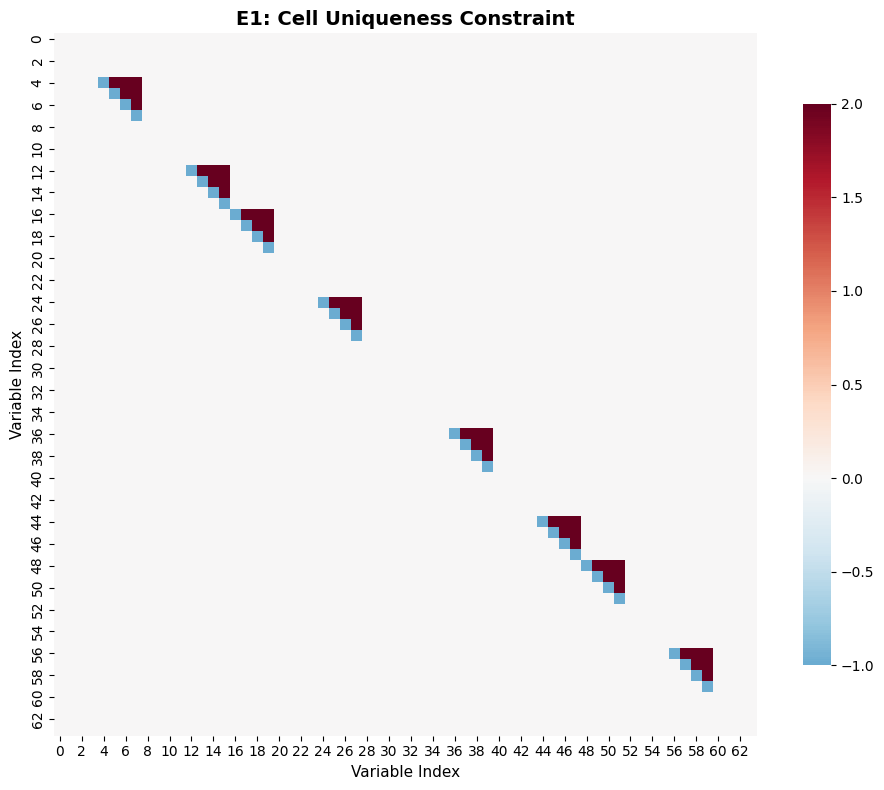


E1 Matrix Statistics:
  Shape: (64, 64)
  Non-zero elements: 80
  Sparsity: 98.0%


In [ ]:
# Visualize E1 matrix structure
visualize_qubo_matrix(Q_E1, title="E1: Cell Uniqueness Constraint", show_values=False)
print(f"\nE1 Matrix Statistics:")
print(f"  Shape: {Q_E1.shape}")
print(f"  Non-zero elements: {np.count_nonzero(Q_E1)}")
print(f"  Sparsity: {(1 - np.count_nonzero(Q_E1) / Q_E1.size) * 100:.1f}%")


### 📊 Matrix Structure Interpretation

The E₁ matrix has a **block diagonal structure** where:
- Each block corresponds to one cell's variables (4×4 for 4×4 Sudoku)
- Within each block, all pairs of variables are coupled (preventing multiple digits in one cell)
- Blocks don't interact (cell constraints are independent)

## Component 2: Row Uniqueness (E₂)

This constraint ensures no row has duplicate or missing digits.

$$E_2 = \sum_{i,k} \left(\sum_j x_{i,j,k} - 1\right)^2$$

When some cells are given, the constraint adjusts to account for already-placed digits.

In [ ]:
# Build E2 (each row has each digit exactly once)
Q_E2, poly_E2, const_E2 = build_E2(N, givens)

print("=" * 70)
print("E2: Each Row Has Each Digit Exactly Once")
print("=" * 70)
print(f"Number of terms: {len(poly_E2)}")
print(f"Constant: {const_E2}")

E2: Each Row Has Each Digit Exactly Once
Number of terms: 48
Constant: 8.0


In [ ]:
# View E2 polynomial
print_polynomial(poly_E2, const_E2, "E2: Each Row Has Each Digit", max_terms=15)


E2: Each Row Has Each Digit
Number of terms: 48
Constant: 8.0

First 15 terms:
  -1.0*x_010
  -1.0*x_030
  2*x_010*x_030
  1.0*x_011
  1.0*x_031
  2*x_011*x_031
  -1.0*x_012
  -1.0*x_032
  2*x_012*x_032
  1.0*x_013
  1.0*x_033
  2*x_013*x_033
  1.0*x_100
  1.0*x_120
  2*x_100*x_120
  ... (33 more terms)


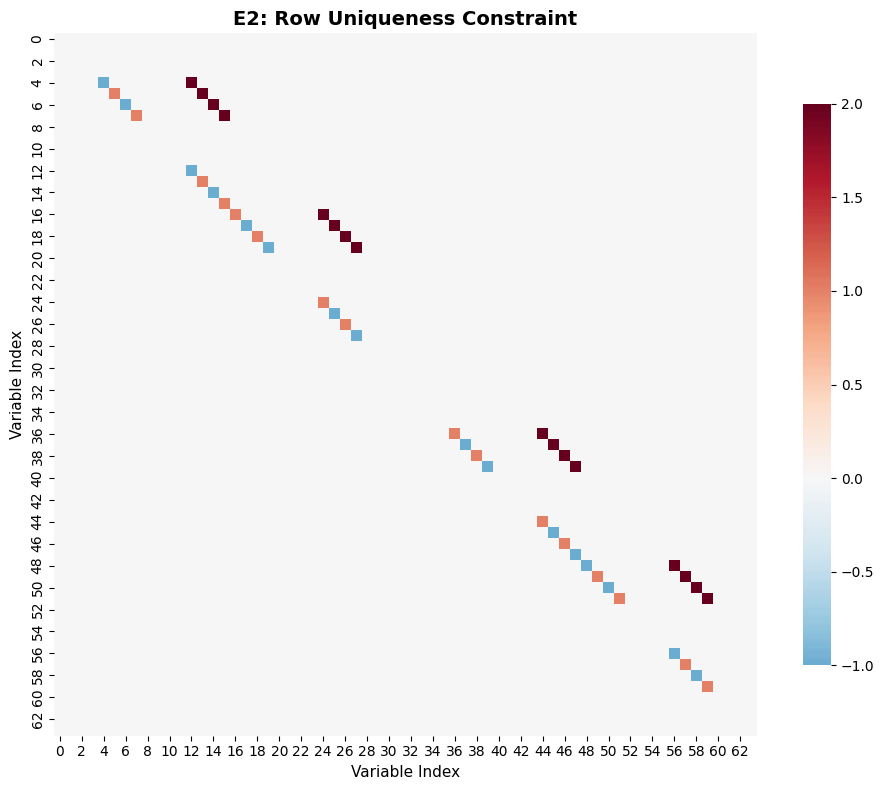


E2 Matrix Statistics:
  Shape: (64, 64)
  Non-zero elements: 48
  Sparsity: 98.8%


In [ ]:
# Visualize E2 matrix structure
visualize_qubo_matrix(Q_E2, title="E2: Row Uniqueness Constraint", show_values=False)
print(f"\nE2 Matrix Statistics:")
print(f"  Shape: {Q_E2.shape}")
print(f"  Non-zero elements: {np.count_nonzero(Q_E2)}")
print(f"  Sparsity: {(1 - np.count_nonzero(Q_E2) / Q_E2.size) * 100:.1f}%")


## Component 3: Column Uniqueness (E₃)

Similar to row constraints, but applied to columns.

$$E_3 = \sum_{j,k} \left(\sum_i x_{i,j,k} - 1\right)^2$$

In [ ]:
# Build E3 (each column has each digit exactly once)
Q_E3, poly_E3, const_E3 = build_E3(N, givens)

print("=" * 70)
print("E3: Each Column Has Each Digit Exactly Once")
print("=" * 70)
print(f"Number of terms: {len(poly_E3)}")
print(f"Constant: {const_E3}")

E3: Each Column Has Each Digit Exactly Once
Number of terms: 48
Constant: 8.0


In [ ]:
# View E3 polynomial
print_polynomial(poly_E3, const_E3, "E3: Each Column Has Each Digit", max_terms=15)


E3: Each Column Has Each Digit
Number of terms: 48
Constant: 8.0

First 15 terms:
  1.0*x_100
  1.0*x_300
  2*x_100*x_300
  1.0*x_101
  1.0*x_301
  2*x_101*x_301
  -1.0*x_102
  -1.0*x_302
  2*x_102*x_302
  -1.0*x_103
  -1.0*x_303
  2*x_103*x_303
  -1.0*x_010
  -1.0*x_210
  2*x_010*x_210
  ... (33 more terms)


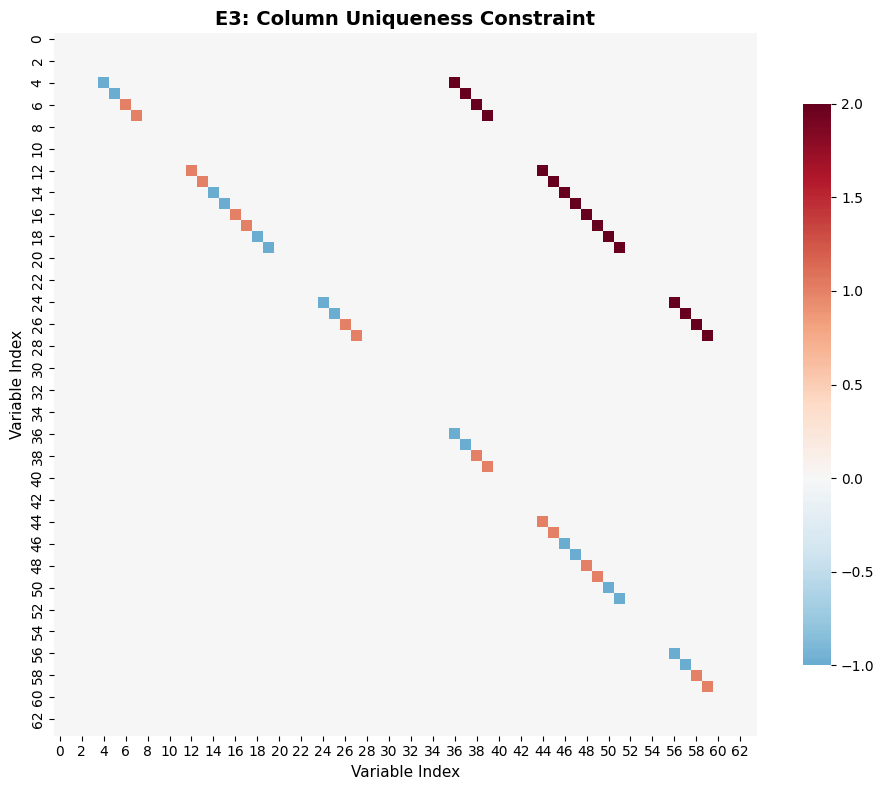


E3 Matrix Statistics:
  Shape: (64, 64)
  Non-zero elements: 48
  Sparsity: 98.8%


In [ ]:
# Visualize E3 matrix structure
visualize_qubo_matrix(Q_E3, title="E3: Column Uniqueness Constraint", show_values=False)
print(f"\nE3 Matrix Statistics:")
print(f"  Shape: {Q_E3.shape}")
print(f"  Non-zero elements: {np.count_nonzero(Q_E3)}")
print(f"  Sparsity: {(1 - np.count_nonzero(Q_E3) / Q_E3.size) * 100:.1f}%")


## Component 4: Box Uniqueness (E₄)

For a 4×4 Sudoku, we have four 2×2 boxes that must each contain digits 1-4 exactly once.

$$E_4 = \sum_{\text{box},k} \left(\sum_{(i,j) \in \text{box}} x_{i,j,k} - 1\right)^2$$

In [ ]:
# Build E4 (each box has each digit exactly once)
Q_E4, poly_E4, const_E4 = build_E4(N, box_size, givens)

print("=" * 70)
print("E4: Each Box Has Each Digit Exactly Once")
print("=" * 70)
print(f"Number of terms: {len(poly_E4)}")
print(f"Constant: {const_E4}")

E4: Each Box Has Each Digit Exactly Once
Number of terms: 48
Constant: 8.0


In [ ]:
# View E4 polynomial
print_polynomial(poly_E4, const_E4, "E4: Each Box Has Each Digit", max_terms=15)


E4: Each Box Has Each Digit
Number of terms: 48
Constant: 8.0

First 15 terms:
  -1.0*x_010
  -1.0*x_100
  2*x_010*x_100
  1.0*x_011
  1.0*x_101
  2*x_011*x_101
  1.0*x_012
  1.0*x_102
  2*x_012*x_102
  -1.0*x_013
  -1.0*x_103
  2*x_013*x_103
  1.0*x_030
  1.0*x_120
  2*x_030*x_120
  ... (33 more terms)


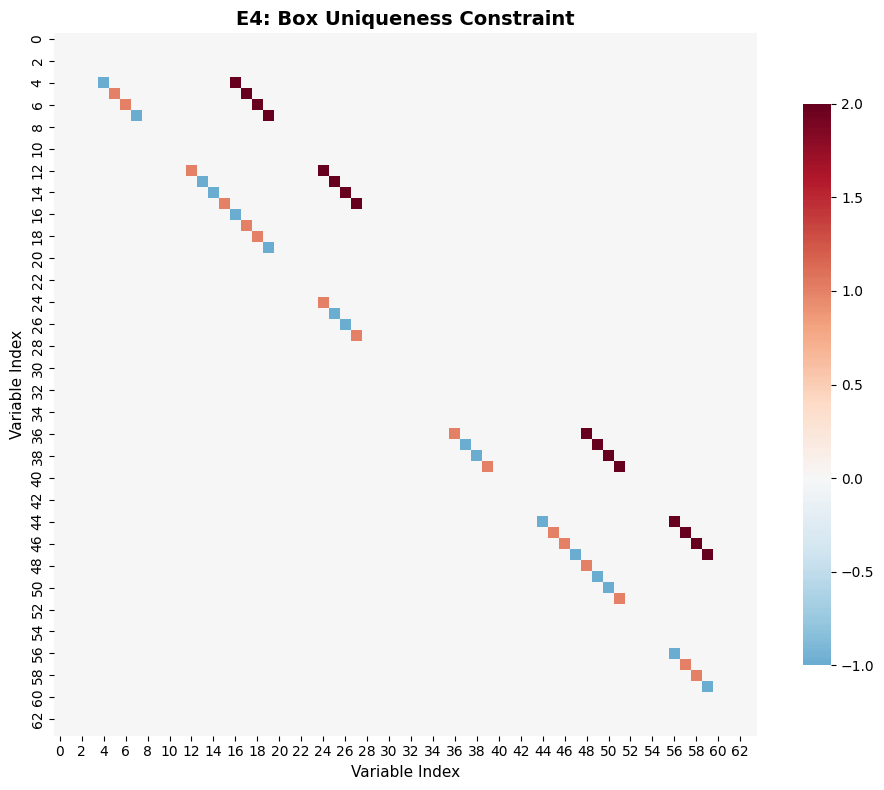


E4 Matrix Statistics:
  Shape: (64, 64)
  Non-zero elements: 48
  Sparsity: 98.8%


In [ ]:
# Visualize E4 matrix structure
visualize_qubo_matrix(Q_E4, title="E4: Box Uniqueness Constraint", show_values=False)
print(f"\nE4 Matrix Statistics:")
print(f"  Shape: {Q_E4.shape}")
print(f"  Non-zero elements: {np.count_nonzero(Q_E4)}")
print(f"  Sparsity: {(1 - np.count_nonzero(Q_E4) / Q_E4.size) * 100:.1f}%")


## Combining All Components

Now we combine all four energy components into a single QUBO matrix.

Since this is a pure constraint satisfaction problem (no objective to minimize), all Lagrange multipliers are set to 1.

$$Q_{\text{total}} = Q_{E_1} + Q_{E_2} + Q_{E_3} + Q_{E_4}$$

Combined QUBO Matrix

QUBO Matrix Statistics:
  Size: 64 × 64
  Total possible entries: 4,096
  Non-zero diagonal entries: 8
  Non-zero off-diagonal entries: 96
  Total non-zero entries: 104
  Sparsity: 97.46%

Given cells: 8
Free variables: 32
Total constant offset: 32.0


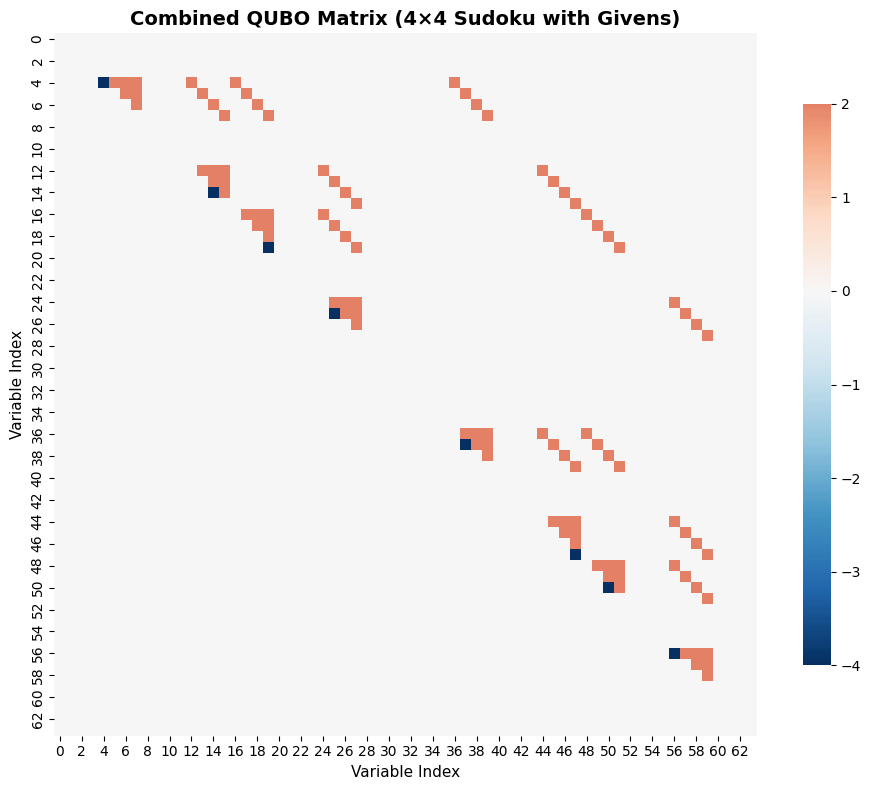

In [ ]:
# Combine all QUBO matrices (all Lagrange multipliers = 1)
Q_total = Q_E1 + Q_E2 + Q_E3 + Q_E4
offset_total = const_E1 + const_E2 + const_E3 + const_E4

print("=" * 70)
print("Combined QUBO Matrix")
print("=" * 70)
print_qubo_stats(Q_total, N, givens)
print(f"Total constant offset: {offset_total}")

# Visualize the combined QUBO
visualize_qubo_matrix(Q_total, f"Combined QUBO Matrix ({N}×{N} Sudoku with Givens)", show_values=False)

### 📊 Interpreting the Combined Matrix

The complete QUBO matrix shows:

1. **Diagonal elements** (linear terms): Encourage variables to take value 1
2. **Off-diagonal elements** (quadratic terms): Encode constraint relationships
3. **Block structure**: Reflects the layered constraint structure
4. **Sparsity**: Most variable pairs don't interact (only constrained pairs have non-zero entries)

The goal is to find a binary assignment that minimizes this quadratic form to reach E=0.

## Testing the QUBO

Let's validate our QUBO by testing it with correct and incorrect solutions.

### Test Case 1: Correct Solution ✅

In [ ]:
# Correct solution bitstring
bitstring_correct = (
    "0100" + "1000" + "0001" + "0010" +  # Row 0: 2,1,4,3
    "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
    "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
    "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
)

print("Test Case 1: Correct Solution")
print("=" * 70)

# Evaluate using calc_mods
energy_calc, breakdown = total_energy(bitstring_correct, N, box_size, verbose=False)
print(f"\ncalc_mods energy: {energy_calc}")
print(f"Breakdown: E1={breakdown[0]}, E2={breakdown[1]}, E3={breakdown[2]}, E4={breakdown[3]}")
print(f"Valid solution: {is_valid_solution(breakdown)}")

# Evaluate using QUBO
Q_full, var_to_idx, idx_to_var, offset_full = build_sudoku_qubo(N, box_size, givens)
energy_qubo = evaluate_qubo(Q_full, bitstring_correct, offset_full)
print(f"\nQUBO energy: {energy_qubo}")

# Visualize the solution
from calc_mods import bitstring_to_tensor
x = bitstring_to_tensor(bitstring_correct, N)
grid = tensor_to_grid(x, N)
print("\nSolution grid:")
print_grid(grid, N, box_size)

Test Case 1: Correct Solution

calc_mods energy: 0.0
Breakdown: E1=0, E2=0, E3=0, E4=0
Valid solution: True

QUBO energy: 0.0

Solution grid:
2 1 | 4 3
4 3 | 2 1
---------
1 2 | 3 4
3 4 | 1 2


### Test Case 2: Incorrect Solution ❌

In [ ]:
# Incorrect solution - swap cells (0,1) and (0,3): 1↔3
bitstring_wrong = (
    "0100" + "0010" + "0001" + "1000" +  # Row 0: 2,3,4,1 (wrong!)
    "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
    "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
    "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
)

print("Test Case 2: Incorrect Solution")
print("=" * 70)

# Evaluate using calc_mods
energy_calc_wrong, breakdown_wrong = total_energy(bitstring_wrong, N, box_size, verbose=True)
print(f"\nValid solution: {is_valid_solution(breakdown_wrong)}")

# Evaluate using QUBO
energy_qubo_wrong = evaluate_qubo(Q_full, bitstring_wrong, offset_full)
print(f"\nQUBO energy: {energy_qubo_wrong}")
print(f"Energy difference from correct: {energy_qubo_wrong - energy_qubo}")

print("\nThe incorrect solution has HIGHER energy, as expected!")

Test Case 2: Incorrect Solution

Tensor x[i,j,k] shape: (4, 4, 4)

Sudoku grid:
2 3 | 4 1
4 3 | 2 1
---------
1 2 | 3 4
3 4 | 1 2

Computing energy components:
  E1 (cell constraint)   = 0
  E2 (row constraint)    = 0
  E3 (column constraint) = 4
  E4 (box constraint)    = 4

Total energy calculation:
  E = 1.0×0 + 1.0×0 + 1.0×4 + 1.0×4
  E = 0.0 + 0.0 + 4.0 + 4.0
  E = 8.0

Valid solution: False

QUBO energy: 8.0
Energy difference from correct: 8.0

The incorrect solution has HIGHER energy, as expected!


**Validation:** Correct solution → E=0 ✓ | Incorrect solution → E>0 ✓

---
# 6. Variable Elimination & Reduction

When cells have **given values**, we can eliminate their variables and reduce the QUBO size dramatically.

For each given cell $(i,j)$ with digit $d$: set $x_{i,j,d-1} = 1$, all others to 0, then remove from QUBO.


In [ ]:
print("="*80)
print("MATRIX REDUCTION: Comparing Two Methods")
print("="*80)
print()

# Method 1: Extraction approach (build full, extract submatrix)
print("Method 1: Extraction from Full QUBO")
print("-" * 40)
Q_reduced_ext, var_to_idx_ext, idx_to_var_ext, offset_ext, info_ext = build_reduced_qubo(
    N, box_size, givens
)
print(f"  Built {Q_reduced_ext.shape[0]}×{Q_reduced_ext.shape[1]} matrix")
print(f"  Non-zero entries: {np.count_nonzero(Q_reduced_ext)}")
print(f"  Process: Build 64×64 → Extract 32×32")
print()

# Method 2: Direct construction (build reduced directly)
print("Method 2: Direct Construction")
print("-" * 40)
Q_reduced_dir, var_to_idx_dir, idx_to_var_dir, offset_dir, info_dir = build_reduced_qubo_direct(
    N, box_size, givens
)
print(f"  Built {Q_reduced_dir.shape[0]}×{Q_reduced_dir.shape[1]} matrix")
print(f"  Non-zero entries: {np.count_nonzero(Q_reduced_dir)}")
print(f"  Process: Build 32×32 directly")
print()

# Verify they're identical
print("Verification")
print("-" * 40)
matrices_match = np.allclose(Q_reduced_ext, Q_reduced_dir)
offsets_match = abs(offset_ext - offset_dir) < 1e-10

print(f"  Matrices identical? {matrices_match} {'✓' if matrices_match else '✗'}")
print(f"  Offsets identical? {offsets_match} {'✓' if offsets_match else '✗'}")
print()

if matrices_match and offsets_match:
    print("✓ SUCCESS: Both methods produce identical results!")
else:
    print("✗ MISMATCH: Methods produced different results")

# Use direct method for remaining work
Q_reduced = Q_reduced_dir
var_to_idx_reduced = var_to_idx_dir
idx_to_var_reduced = idx_to_var_dir
offset_reduced = offset_dir
reduction_info = info_dir

MATRIX REDUCTION: Comparing Two Methods

Method 1: Extraction from Full QUBO
----------------------------------------
  Built 32×32 matrix
  Non-zero entries: 104
  Process: Build 64×64 → Extract 32×32

Method 2: Direct Construction
----------------------------------------
  Built 32×32 matrix
  Non-zero entries: 104
  Process: Build 32×32 directly

Verification
----------------------------------------
  Matrices identical? True ✓
  Offsets identical? True ✓

✓ SUCCESS: Both methods produce identical results!


In [ ]:
# Display detailed reduction statistics
print_reduction_stats(reduction_info, N, box_size)

print("\n" + "="*80)
print("Variable Breakdown")
print("="*80)
print()

print("Given cells and their fixed values:")
for (i, j), digit in sorted(givens.items()):
    print(f"  Cell ({i},{j}) = {digit} → 4 variables ELIMINATED")

print(f"\nFree cells (need to solve):")
free_cells = [(i, j) for i in range(N) for j in range(N) if (i, j) not in givens]
for idx, (i, j) in enumerate(free_cells[:5]):
    print(f"  Cell ({i},{j}) = ? → 4 variables ACTIVE")
if len(free_cells) > 5:
    print(f"  ... and {len(free_cells) - 5} more free cells")

print(f"\nIndex Remapping Example:")
print(f"  Full QUBO uses indices 0-63")
print(f"  Reduced QUBO uses indices 0-31")
print(f"\nSample mappings:")
for i in range(5):
    var = idx_to_var_reduced[i]
    print(f"  Reduced index {i} → x{var} (cell ({var[0]},{var[1]}), digit {var[2]+1})")


Variable Elimination Statistics:
  Total variables: 64
  Given cells: 8
  Eliminated variables: 32
  Free variables: 32
  Variable reduction: 50.0%
  Matrix size reduction: 75.0%

Matrix Dimensions:
  Full QUBO: 64×64 = 4,096 entries
  Reduced QUBO: 32×32 = 1,024 entries
  Savings: 3,072 entries

Variable Breakdown

Given cells and their fixed values:
  Cell (0,0) = 2 → 4 variables ELIMINATED
  Cell (0,2) = 4 → 4 variables ELIMINATED
  Cell (1,1) = 3 → 4 variables ELIMINATED
  Cell (1,3) = 1 → 4 variables ELIMINATED
  Cell (2,0) = 1 → 4 variables ELIMINATED
  Cell (2,2) = 3 → 4 variables ELIMINATED
  Cell (3,1) = 4 → 4 variables ELIMINATED
  Cell (3,3) = 2 → 4 variables ELIMINATED

Free cells (need to solve):
  Cell (0,1) = ? → 4 variables ACTIVE
  Cell (0,3) = ? → 4 variables ACTIVE
  Cell (1,0) = ? → 4 variables ACTIVE
  Cell (1,2) = ? → 4 variables ACTIVE
  Cell (2,1) = ? → 4 variables ACTIVE
  ... and 3 more free cells

Index Remapping Example:
  Full QUBO uses indices 0-63
  Redu

Variable elimination: 64×64 → 32×32 matrix (75% fewer elements). Essential for quantum hardware.

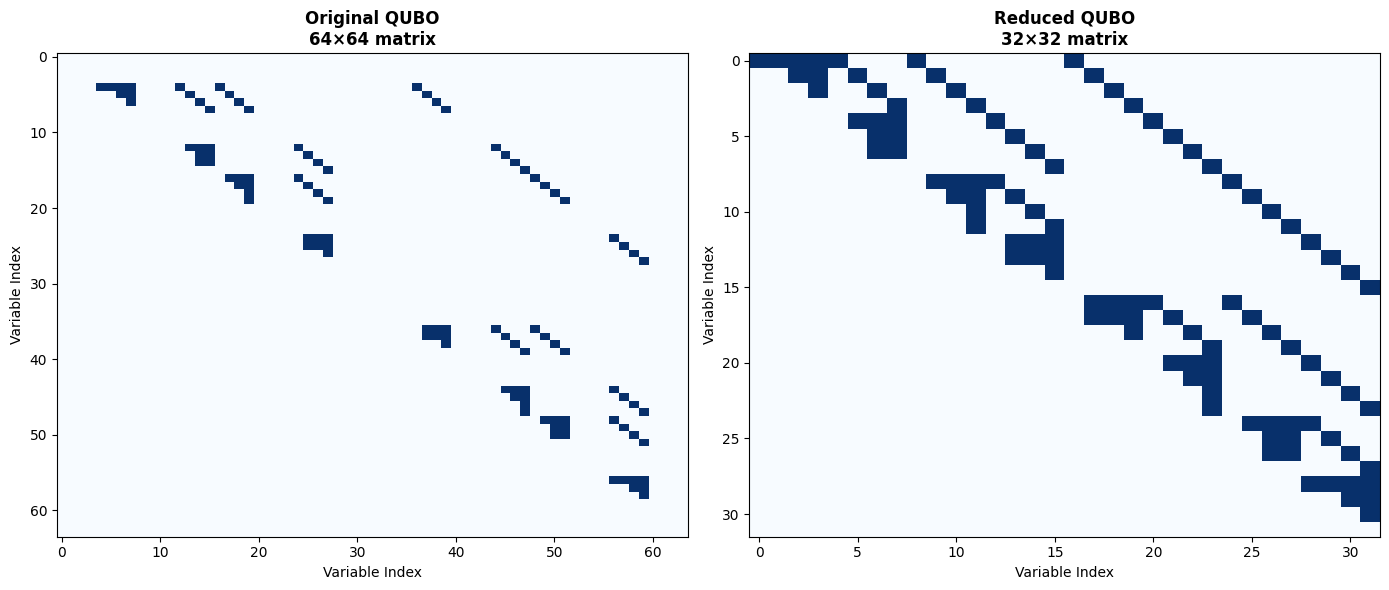


🎯 Variable elimination reduced the problem by 50%


In [ ]:
# Compare original vs reduced matrices side by side
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Original (with givens factored in but not eliminated)
im1 = ax1.imshow(Q_total != 0, cmap='Blues', aspect='auto')
ax1.set_title(f"Original QUBO\n{Q_total.shape[0]}×{Q_total.shape[1]} matrix", fontsize=12, fontweight='bold')
ax1.set_xlabel('Variable Index')
ax1.set_ylabel('Variable Index')

# Reduced (givens eliminated)
im2 = ax2.imshow(Q_reduced != 0, cmap='Blues', aspect='auto')
ax2.set_title(f"Reduced QUBO\n{Q_reduced.shape[0]}×{Q_reduced.shape[1]} matrix", fontsize=12, fontweight='bold')
ax2.set_xlabel('Variable Index')
ax2.set_ylabel('Variable Index')

plt.tight_layout()
plt.show()

print(f"\n🎯 Variable elimination reduced the problem by {((1 - Q_reduced.shape[0]/Q_total.shape[0])*100):.0f}%")


## Testing the Reduced QUBO

Let's verify that the reduced QUBO produces the same energy values as the original.

In [ ]:
print("="*80)
print("Energy Comparison: Full vs Reduced QUBO")
print("="*80)
print()

# Correct solution (from earlier)
bitstring_correct = (
    "0100" + "1000" + "0001" + "0010" +  # Row 0: 2,1,4,3
    "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
    "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
    "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
)

# Build full QUBO
Q_full_test, _, _, offset_full = build_sudoku_qubo(N, box_size, givens)

# Evaluate with full QUBO
energy_full = evaluate_qubo(Q_full_test, bitstring_correct, offset_full)

# Evaluate with reduced QUBO
energy_reduced = evaluate_reduced_qubo(
    Q_reduced, bitstring_correct,
    var_to_idx_reduced, idx_to_var_reduced,
    offset_reduced
)

print("Correct Solution:")
print(f"  Full QUBO energy:    {energy_full:.6f}")
print(f"  Reduced QUBO energy: {energy_reduced:.6f}")
print(f"  Difference:          {abs(energy_full - energy_reduced):.10f}")
print(f"  Match: {'✓ IDENTICAL' if abs(energy_full - energy_reduced) < 1e-10 else '✗ DIFFERENT'}")
print()

# Try an incorrect solution
bitstring_wrong = (
    "0100" + "0010" + "0001" + "1000" +  # Row 0: 2,3,4,1 (WRONG!)
    "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
    "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
    "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
)

energy_full_wrong = evaluate_qubo(Q_full_test, bitstring_wrong, offset_full)
energy_reduced_wrong = evaluate_reduced_qubo(
    Q_reduced, bitstring_wrong,
    var_to_idx_reduced, idx_to_var_reduced,
    offset_reduced
)

print("Incorrect Solution:")
print(f"  Full QUBO energy:    {energy_full_wrong:.6f}")
print(f"  Reduced QUBO energy: {energy_reduced_wrong:.6f}")
print(f"  Difference:          {abs(energy_full_wrong - energy_reduced_wrong):.10f}")
print(f"  Match: {'✓ IDENTICAL' if abs(energy_full_wrong - energy_reduced_wrong) < 1e-10 else '✗ DIFFERENT'}")
print()

print("Penalty Comparison:")
print(f"  Full QUBO:    {energy_full_wrong - energy_full:.6f} penalty for wrong solution")
print(f"  Reduced QUBO: {energy_reduced_wrong - energy_reduced:.6f} penalty for wrong solution")
print()
print("✓ Reduced QUBO preserves the complete energy landscape!")

Energy Comparison: Full vs Reduced QUBO

Correct Solution:
  Full QUBO energy:    0.000000
  Reduced QUBO energy: 0.000000
  Difference:          0.0000000000
  Match: ✓ IDENTICAL

Incorrect Solution:
  Full QUBO energy:    8.000000
  Reduced QUBO energy: 8.000000
  Difference:          0.0000000000
  Match: ✓ IDENTICAL

Penalty Comparison:
  Full QUBO:    8.000000 penalty for wrong solution
  Reduced QUBO: 8.000000 penalty for wrong solution

✓ Reduced QUBO preserves the complete energy landscape!


## Solution Reconstruction

Reduced solutions can be expanded back to full grids by reinserting the given values.

In [ ]:
print("="*80)
print("Solution Reconstruction Demo")
print("="*80)
print()

# Extract just the free variable bits from correct solution
reduced_bits = ""
idx_full = 0
for i in range(N):
    for j in range(N):
        for k in range(N):
            if (i, j, k) in var_to_idx_reduced:
                reduced_bits += bitstring_correct[idx_full]
            idx_full += 1

print(f"Original full solution:     {len(bitstring_correct)} bits")
print(f"  First 32 bits: {bitstring_correct[:32]}")
print(f"  Last 32 bits:  {bitstring_correct[32:]}")
print()

print(f"Extracted reduced solution: {len(reduced_bits)} bits")
print(f"  {reduced_bits}")
print("  (Only bits for free cells!)")
print()

# Reconstruct
reconstructed = reconstruct_full_solution(
    reduced_bits,
    var_to_idx_reduced,
    idx_to_var_reduced,
    givens,
    N
)

print(f"Reconstructed full solution: {len(reconstructed)} bits")
print(f"  First 32 bits: {reconstructed[:32]}")
print(f"  Last 32 bits:  {reconstructed[32:]}")
print()

# Verify
match = (reconstructed == bitstring_correct)
print(f"Match with original: {match} {'✓' if match else '✗'}")
print()

if match:
    print("✓ Perfect reconstruction!")
    print("  • Solved with 32 variables (reduced QUBO)")
    print("  • Reconstructed to 64 bits (full solution)")
    print("  • Added back the 32 bits for given cells")
else:
    print("✗ Reconstruction failed - investigating...")
    # Show where they differ
    for i in range(len(bitstring_correct)):
        if bitstring_correct[i] != reconstructed[i]:
            print(f"  Bit {i}: expected {bitstring_correct[i]}, got {reconstructed[i]}")

Solution Reconstruction Demo

Original full solution:     64 bits
  First 32 bits: 01001000000100100001001001001000
  Last 32 bits:  10000100001000010010000110000100

Extracted reduced solution: 32 bits
  10000010000101000100000100101000
  (Only bits for free cells!)

Reconstructed full solution: 64 bits
  First 32 bits: 01001000000100100001001001001000
  Last 32 bits:  10000100001000010010000110000100

Match with original: True ✓

✓ Perfect reconstruction!
  • Solved with 32 variables (reduced QUBO)
  • Reconstructed to 64 bits (full solution)
  • Added back the 32 bits for given cells


---
# 7. Scaling to 9×9

| Metric | 4×4 | 9×9 | Growth |
|--------|-----|-----|--------|
| Cells | 16 | 81 | 5× |
| Variables | 64 | 729 | 11× |
| Matrix elements | 4,096 | 531,441 | 130× |


In [ ]:
# Build QUBO for blank 9×9 Sudoku (construction only)
N_large = 9
box_size_large = 3
givens_large = None

print("Building 9×9 Sudoku QUBO...")
Q_large, var_to_idx_large, idx_to_var_large, offset_large = build_sudoku_qubo(
    N_large, box_size_large, givens_large
)

print("\n" + "=" * 70)
print("Blank 9×9 Sudoku")
print("=" * 70)
print_qubo_stats(Q_large, N_large, givens_large)
print(f"Total constant offset: {offset_large}")

print("\nThe 9×9 QUBO has been successfully constructed!")
print(f"Matrix size: {Q_large.shape[0]}×{Q_large.shape[1]}")

Building 9×9 Sudoku QUBO...

Blank 9×9 Sudoku

QUBO Matrix Statistics:
  Size: 729 × 729
  Total possible entries: 531,441
  Non-zero diagonal entries: 729
  Non-zero off-diagonal entries: 10206
  Total non-zero entries: 10935
  Sparsity: 97.94%
Total constant offset: 324.0

The 9×9 QUBO has been successfully constructed!
Matrix size: 729×729


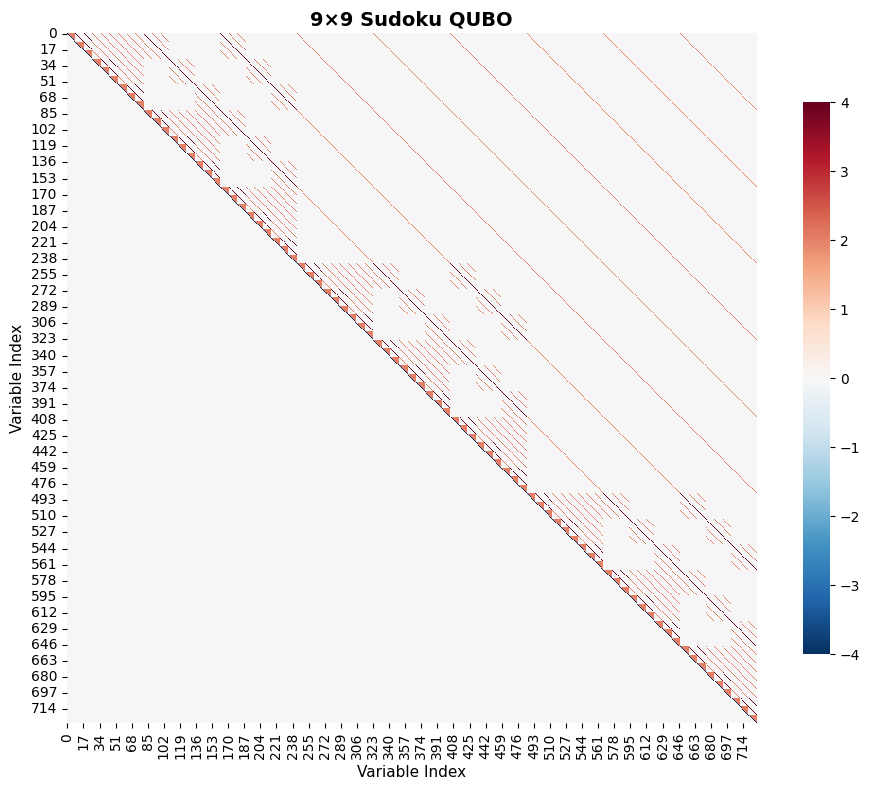


9×9 SUDOKU QUBO STATISTICS
Matrix shape: (729, 729)
Total elements: 531,441
Non-zero elements: 10,935
Sparsity: 97.9%

This is a 729×729 matrix!

This is a blank 9×9 Sudoku with all 729 variables free to optimize.


In [ ]:
# Visualize the 9x9 QUBO structure
visualize_qubo_matrix(Q_large, title="9×9 Sudoku QUBO", show_values=False)

print(f"\n{'='*80}")
print("9×9 SUDOKU QUBO STATISTICS")
print(f"{'='*80}")
print(f"Matrix shape: {Q_large.shape}")
print(f"Total elements: {Q_large.size:,}")
print(f"Non-zero elements: {np.count_nonzero(Q_large):,}")
print(f"Sparsity: {(1 - np.count_nonzero(Q_large) / Q_large.size) * 100:.1f}%")
print(f"\nThis is a {Q_large.shape[0]}×{Q_large.shape[1]} matrix!")
if givens_large:
    print(f"\nWith {len(givens_large)} givens, we have {Q_large.shape[0]} free variables to optimize.")
else:
    print(f"\nThis is a blank 9×9 Sudoku with all {Q_large.shape[0]} variables free to optimize.")


## Scaling Analysis


Scaling Analysis:
 N  Variables  Constraints Matrix Size Sparsity
 4         64           64       64×64   89.06%
 9        729          324     729×729   99.50%
16       4096         1024   4096×4096   99.94%
25      15625         2500 15625×15625   99.99%


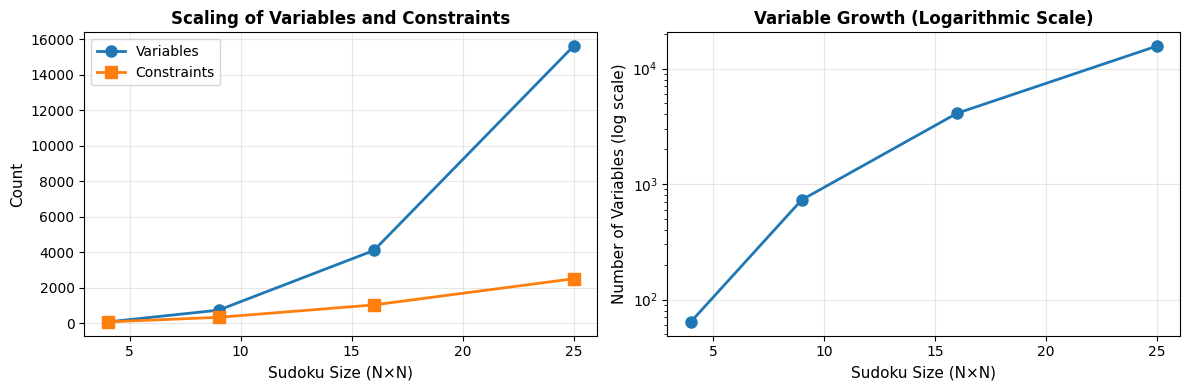

In [ ]:
# Analyze scaling
sizes = [(4, 4), (9, 9), (16, 16), (25, 25)]
data = []

for n in [4, 9, 16, 25]:
    n_vars = n ** 3
    n_constraints = 4 * n * n
    # Estimate non-zero entries (empirical from our examples)
    sparsity = 1 - (n_vars + 4 * 6 * n * n) / (n_vars ** 2)
    data.append({
        'N': n,
        'Variables': n_vars,
        'Constraints': n_constraints,
        'Matrix Size': f'{n_vars}×{n_vars}',
        'Sparsity': f'{sparsity*100:.2f}%'
    })

import pandas as pd
df = pd.DataFrame(data)
print("\nScaling Analysis:")
print("=" * 70)
print(df.to_string(index=False))

# Plot scaling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ns = [4, 9, 16, 25]
vars = [n**3 for n in ns]
constraints = [4*n*n for n in ns]

ax1.plot(ns, vars, 'o-', linewidth=2, markersize=8, label='Variables')
ax1.plot(ns, constraints, 's-', linewidth=2, markersize=8, label='Constraints')
ax1.set_xlabel('Sudoku Size (N×N)', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('Scaling of Variables and Constraints', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.semilogy(ns, vars, 'o-', linewidth=2, markersize=8)
ax2.set_xlabel('Sudoku Size (N×N)', fontsize=11)
ax2.set_ylabel('Number of Variables (log scale)', fontsize=11)
ax2.set_title('Variable Growth (Logarithmic Scale)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Key insight:** Matrix size grows as $O(N^6)$. Variable elimination is essential for 9×9 and larger.

---
# 8. Classical Baseline: Simulated Annealing

Now let's **solve** the QUBO using Simulated Annealing (SA) from D-Wave's `neal` package.

**Simulated Annealing** is a probabilistic optimization inspired by metallurgical annealing:
- High temperature → explore (accept worse moves)
- Cooling → exploit (converge to minimum)

At temperature $T$, uphill moves are accepted with probability $e^{-\Delta E / T}$.


In [ ]:
# Install D-Wave's neal package for Simulated Annealing
!pip install dwave-ocean-sdk dwave-neal -q

print("✓ D-Wave Ocean SDK installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.5/167.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
✓ D-Wave Ocean SDK installed


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# D-Wave imports
from dimod import BinaryQuadraticModel
from neal import SimulatedAnnealingSampler

print("✓ Imports successful")

✓ Imports successful


## 8.2 Converting QUBO to BinaryQuadraticModel

D-Wave's `neal` sampler expects a `BinaryQuadraticModel`. We convert our NumPy QUBO matrix:

In [ ]:
def qubo_matrix_to_bqm(Q, offset=0.0):
    """
    Convert a QUBO matrix (NumPy array) to a D-Wave BinaryQuadraticModel.

    Args:
        Q: QUBO matrix (n x n numpy array)
        offset: Constant energy offset

    Returns:
        BinaryQuadraticModel in BINARY vartype
    """
    n = Q.shape[0]
    linear = {}
    quadratic = {}

    for i in range(n):
        # Diagonal elements are linear biases
        if Q[i, i] != 0:
            linear[i] = Q[i, i]

        # Off-diagonal elements are quadratic biases
        for j in range(i + 1, n):
            # QUBO matrices store Q[i,j] + Q[j,i] for the coupling
            coupling = Q[i, j] + Q[j, i]
            if coupling != 0:
                quadratic[(i, j)] = coupling

    return BinaryQuadraticModel(linear, quadratic, offset, vartype='BINARY')

print("✓ QUBO to BQM converter defined")

✓ QUBO to BQM converter defined


## 8.3 Test Case 1: Blank 4×4 Sudoku

First, let's solve the **blank 4×4 Sudoku** (no givens). This has 64 binary variables.

Since there are no clues, any valid Sudoku solution should achieve energy = 0.

In [ ]:
# Build QUBO for blank 4×4 Sudoku
N_4x4 = 4
box_size_4x4 = 2
givens_4x4 = None  # No givens = blank puzzle

Q_4x4, var_to_idx_4x4, idx_to_var_4x4, offset_4x4 = build_sudoku_qubo(
    N_4x4, box_size_4x4, givens_4x4
)

print("=" * 60)
print("BLANK 4×4 SUDOKU QUBO")
print("=" * 60)
print(f"Matrix size: {Q_4x4.shape[0]} × {Q_4x4.shape[1]}")
print(f"Number of variables: {Q_4x4.shape[0]}")
print(f"Non-zero elements: {np.count_nonzero(Q_4x4)}")
print(f"Offset: {offset_4x4}")

BLANK 4×4 SUDOKU QUBO
Matrix size: 64 × 64
Number of variables: 64
Non-zero elements: 384
Offset: 64.0


In [ ]:
# Convert to BQM
bqm_4x4 = qubo_matrix_to_bqm(Q_4x4, offset_4x4)

print("BinaryQuadraticModel created:")
print(f"  Variables: {len(bqm_4x4.variables)}")
print(f"  Linear biases: {len(bqm_4x4.linear)}")
print(f"  Quadratic interactions: {len(bqm_4x4.quadratic)}")
print(f"  Offset: {bqm_4x4.offset}")

BinaryQuadraticModel created:
  Variables: 64
  Linear biases: 64
  Quadratic interactions: 320
  Offset: 64.0


In [ ]:
# Solve using Simulated Annealing
sa_sampler = SimulatedAnnealingSampler()

NUM_READS = 100
sa_result_4x4 = sa_sampler.sample(bqm_4x4, num_reads=NUM_READS)

# Get the best solution
best_4x4 = sa_result_4x4.first

print("=" * 60)
print("SIMULATED ANNEALING RESULTS: Blank 4×4 Sudoku")
print("=" * 60)
print(f"Best energy: {best_4x4.energy}")
print(f"Target energy (valid solution): 0")
print(f"Found valid solution: {'✓ YES' if best_4x4.energy == 0 else '✗ NO'}")
print(f"\nNumber of reads: {NUM_READS}")

# Energy statistics
energies_4x4 = [s.energy for s in sa_result_4x4.data()]
print(f"\nEnergy statistics:")
print(f"  Min: {min(energies_4x4)}")
print(f"  Max: {max(energies_4x4)}")
print(f"  Mean: {np.mean(energies_4x4):.2f}")
print(f"  Std: {np.std(energies_4x4):.2f}")

SIMULATED ANNEALING RESULTS: Blank 4×4 Sudoku
Best energy: 0.0
Target energy (valid solution): 0
Found valid solution: ✓ YES

Number of reads: 100

Energy statistics:
  Min: 0.0
  Max: 4.0
  Mean: 0.08
  Std: 0.56


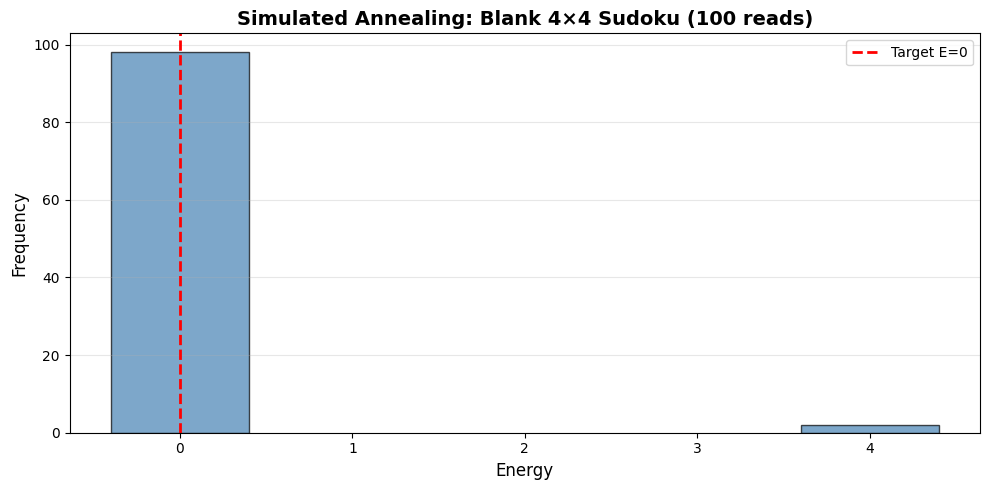


Success rate: 98/100 = 98.0%


In [ ]:
# Visualize energy distribution
plt.figure(figsize=(10, 5))

energy_counts_4x4 = Counter(energies_4x4)
energies_sorted = sorted(energy_counts_4x4.keys())
counts = [energy_counts_4x4[e] for e in energies_sorted]

plt.bar(energies_sorted, counts, color='steelblue', alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Target E=0')
plt.xlabel('Energy', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Simulated Annealing: Blank 4×4 Sudoku ({NUM_READS} reads)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Success rate
n_optimal = sum(1 for e in energies_4x4 if e == 0)
print(f"\nSuccess rate: {n_optimal}/{NUM_READS} = {100*n_optimal/NUM_READS:.1f}%")

In [ ]:
def solution_to_grid(sample, idx_to_var, N):
    """
    Convert a BQM solution to a Sudoku grid.

    Args:
        sample: Dict mapping variable index to value (0 or 1)
        idx_to_var: Mapping from index to (i, j, k) tuple
        N: Sudoku size

    Returns:
        grid: N×N numpy array with digits 1-N (0 for unfilled)
    """
    grid = np.zeros((N, N), dtype=int)

    for idx, val in sample.items():
        if val == 1:
            i, j, k = idx_to_var[idx]
            grid[i, j] = k + 1  # k is 0-indexed, digits are 1-indexed

    return grid

def visualize_sudoku(grid, N, box_size, title="Sudoku Solution", givens=None):
    """
    Visualize a Sudoku grid.
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, N)
    ax.set_ylim(0, N)
    ax.set_aspect('equal')

    # Draw grid lines
    for i in range(N + 1):
        lw = 2.5 if i % box_size == 0 else 0.5
        ax.axhline(y=i, color='black', linewidth=lw)
        ax.axvline(x=i, color='black', linewidth=lw)

    # Fill in numbers
    for i in range(N):
        for j in range(N):
            if grid[i, j] != 0:
                # Check if this was a given
                is_given = givens and (i, j) in givens
                color = 'blue' if is_given else 'black'
                weight = 'bold' if is_given else 'normal'
                ax.text(j + 0.5, N - i - 0.5, str(grid[i, j]),
                       ha='center', va='center', fontsize=18,
                       fontweight=weight, color=color)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("✓ Visualization functions defined")

✓ Visualization functions defined


Best solution found:
[[4 3 1 2]
 [1 2 4 3]
 [3 4 2 1]
 [2 1 3 4]]



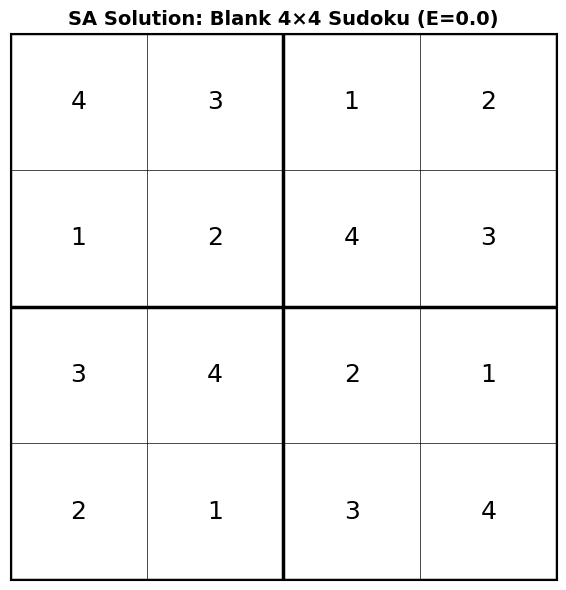

Validation:
  All cells filled: ✓
  Rows valid: ✓
  Cols valid: ✓


In [ ]:
# Convert best solution to grid and visualize
grid_4x4 = solution_to_grid(best_4x4.sample, idx_to_var_4x4, N_4x4)

print("Best solution found:")
print(grid_4x4)
print()

visualize_sudoku(grid_4x4, N_4x4, box_size_4x4,
                 f"SA Solution: Blank 4×4 Sudoku (E={best_4x4.energy})")

# Validate
print("Validation:")
print(f"  All cells filled: {'✓' if np.all(grid_4x4 > 0) else '✗'}")
print(f"  Rows valid: {'✓' if all(len(set(grid_4x4[i,:])) == N_4x4 and 0 not in grid_4x4[i,:] for i in range(N_4x4)) else '✗'}")
print(f"  Cols valid: {'✓' if all(len(set(grid_4x4[:,j])) == N_4x4 and 0 not in grid_4x4[:,j] for j in range(N_4x4)) else '✗'}")

## 8.4 Test Case 2: Partially-Filled 9×9 Sudoku

Now let's try a more realistic problem: a **9×9 Sudoku with givens**.

We'll use a puzzle with ~30 clues, which reduces our variable count significantly.

In [ ]:
# Define a 9×9 Sudoku puzzle with givens
# This is a standard "easy" puzzle
N_9x9 = 9
box_size_9x9 = 3

# Puzzle (0 = empty, digits 1-9 for givens)
puzzle_9x9 = [
    [5, 3, 0, 0, 7, 0, 0, 0, 0],
    [6, 0, 0, 1, 9, 5, 0, 0, 0],
    [0, 9, 8, 0, 0, 0, 0, 6, 0],
    [8, 0, 0, 0, 6, 0, 0, 0, 3],
    [4, 0, 0, 8, 0, 3, 0, 0, 1],
    [7, 0, 0, 0, 2, 0, 0, 0, 6],
    [0, 6, 0, 0, 0, 0, 2, 8, 0],
    [0, 0, 0, 4, 1, 9, 0, 0, 5],
    [0, 0, 0, 0, 8, 0, 0, 7, 9]
]

# Convert to givens dict
givens_9x9 = {}
for i in range(N_9x9):
    for j in range(N_9x9):
        if puzzle_9x9[i][j] != 0:
            givens_9x9[(i, j)] = puzzle_9x9[i][j]

print(f"9×9 Sudoku puzzle:")
print(f"  Given cells: {len(givens_9x9)}")
print(f"  Empty cells: {81 - len(givens_9x9)}")
print(f"  Variables without reduction: {9 * 9 * 9} = 729")
print(f"  Variables with reduction: {(81 - len(givens_9x9)) * 9}")

# Display puzzle
print("\nPuzzle:")
for i, row in enumerate(puzzle_9x9):
    if i % 3 == 0 and i > 0:
        print("-" * 21)
    row_str = ""
    for j, val in enumerate(row):
        if j % 3 == 0 and j > 0:
            row_str += "| "
        row_str += f"{val if val != 0 else '.'} "
    print(row_str)

9×9 Sudoku puzzle:
  Given cells: 30
  Empty cells: 51
  Variables without reduction: 729 = 729
  Variables with reduction: 459

Puzzle:
5 3 . | . 7 . | . . . 
6 . . | 1 9 5 | . . . 
. 9 8 | . . . | . 6 . 
---------------------
8 . . | . 6 . | . . 3 
4 . . | 8 . 3 | . . 1 
7 . . | . 2 . | . . 6 
---------------------
. 6 . | . . . | 2 8 . 
. . . | 4 1 9 | . . 5 
. . . | . 8 . | . 7 9 


In [ ]:
# Build reduced QUBO for 9×9 puzzle
print("Building reduced QUBO for 9×9 Sudoku...")

Q_9x9, var_to_idx_9x9, idx_to_var_9x9, offset_9x9, info_9x9 = build_reduced_qubo(
    N_9x9, box_size_9x9, givens_9x9
)

print("\n" + "=" * 60)
print("9×9 SUDOKU REDUCED QUBO")
print("=" * 60)
print(f"Matrix size: {Q_9x9.shape[0]} × {Q_9x9.shape[1]}")
print(f"Number of variables: {Q_9x9.shape[0]}")
print(f"Non-zero elements: {np.count_nonzero(Q_9x9)}")
print(f"Sparsity: {(1 - np.count_nonzero(Q_9x9) / Q_9x9.size) * 100:.1f}%")
print(f"Offset: {offset_9x9}")

Building reduced QUBO for 9×9 Sudoku...

9×9 SUDOKU REDUCED QUBO
Matrix size: 459 × 459
Number of variables: 459
Non-zero elements: 4996
Sparsity: 97.6%
Offset: 204.0


In [ ]:
# Convert to BQM
bqm_9x9 = qubo_matrix_to_bqm(Q_9x9, offset_9x9)

print("BinaryQuadraticModel created:")
print(f"  Variables: {len(bqm_9x9.variables)}")
print(f"  Linear biases: {len(bqm_9x9.linear)}")
print(f"  Quadratic interactions: {len(bqm_9x9.quadratic)}")

BinaryQuadraticModel created:
  Variables: 459
  Linear biases: 459
  Quadratic interactions: 4653


In [ ]:
# Solve using Simulated Annealing
# Use more reads and sweeps for larger problem

print("Running Simulated Annealing on 9×9 Sudoku...")
print("(This may take a moment)\n")

sa_result_9x9 = sa_sampler.sample(
    bqm_9x9,
    num_reads=NUM_READS,
    num_sweeps=1000  # More sweeps for larger problem
)

best_9x9 = sa_result_9x9.first

print("=" * 60)
print("SIMULATED ANNEALING RESULTS: 9×9 Sudoku")
print("=" * 60)
print(f"Best energy: {best_9x9.energy}")
print(f"Target energy (valid solution): 0")
print(f"Found valid solution: {'✓ YES' if best_9x9.energy == 0 else '✗ NO'}")

# Energy statistics
energies_9x9 = [s.energy for s in sa_result_9x9.data()]
print(f"\nEnergy statistics:")
print(f"  Min: {min(energies_9x9)}")
print(f"  Max: {max(energies_9x9)}")
print(f"  Mean: {np.mean(energies_9x9):.2f}")
print(f"  Std: {np.std(energies_9x9):.2f}")

Running Simulated Annealing on 9×9 Sudoku...
(This may take a moment)

SIMULATED ANNEALING RESULTS: 9×9 Sudoku
Best energy: 0.0
Target energy (valid solution): 0
Found valid solution: ✓ YES

Energy statistics:
  Min: 0.0
  Max: 20.0
  Mean: 7.16
  Std: 4.28


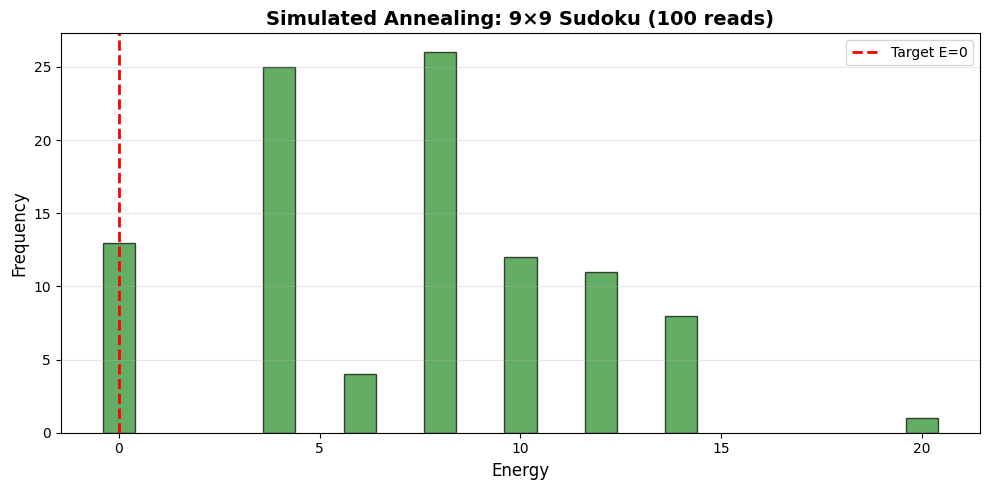


Success rate: 13/100 = 13.0%


In [ ]:
# Visualize energy distribution
plt.figure(figsize=(10, 5))

energy_counts_9x9 = Counter(energies_9x9)
energies_sorted_9x9 = sorted(energy_counts_9x9.keys())
counts_9x9 = [energy_counts_9x9[e] for e in energies_sorted_9x9]

plt.bar(energies_sorted_9x9, counts_9x9, color='forestgreen', alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Target E=0')
plt.xlabel('Energy', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Simulated Annealing: 9×9 Sudoku ({NUM_READS} reads)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Success rate
n_optimal_9x9 = sum(1 for e in energies_9x9 if e == 0)
print(f"\nSuccess rate: {n_optimal_9x9}/{NUM_READS} = {100*n_optimal_9x9/NUM_READS:.1f}%")

In [ ]:
def reduced_solution_to_grid(sample, idx_to_var, givens, N):
    """
    Convert a reduced BQM solution back to a full Sudoku grid.
    """
    grid = np.zeros((N, N), dtype=int)

    # Fill in givens first
    for (i, j), digit in givens.items():
        grid[i, j] = digit

    # Fill in solved cells
    for idx, val in sample.items():
        if val == 1:
            i, j, k = idx_to_var[idx]
            grid[i, j] = k + 1

    return grid

# Convert best solution to grid
grid_9x9 = reduced_solution_to_grid(best_9x9.sample, idx_to_var_9x9, givens_9x9, N_9x9)

print("Best solution found:")
for i, row in enumerate(grid_9x9):
    if i % 3 == 0 and i > 0:
        print("-" * 21)
    row_str = ""
    for j, val in enumerate(row):
        if j % 3 == 0 and j > 0:
            row_str += "| "
        row_str += f"{val if val != 0 else '.'} "
    print(row_str)

Best solution found:
5 3 4 | 6 7 8 | 9 1 2 
6 7 2 | 1 9 5 | 3 4 8 
1 9 8 | 3 4 2 | 5 6 7 
---------------------
8 5 9 | 7 6 1 | 4 2 3 
4 2 6 | 8 5 3 | 7 9 1 
7 1 3 | 9 2 4 | 8 5 6 
---------------------
9 6 1 | 5 3 7 | 2 8 4 
2 8 7 | 4 1 9 | 6 3 5 
3 4 5 | 2 8 6 | 1 7 9 


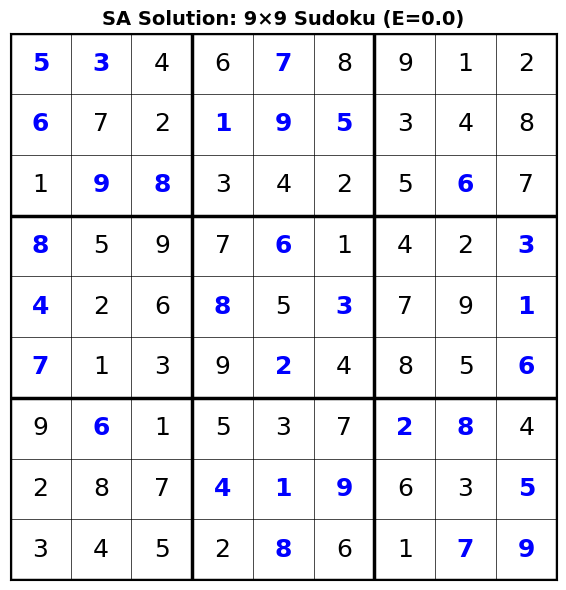


Validation:
  All cells filled: ✓
  Rows valid: ✓
  Columns valid: ✓
  Boxes valid: ✓
  Overall: ✓ VALID SUDOKU


In [ ]:
# Visualize the solution
visualize_sudoku(grid_9x9, N_9x9, box_size_9x9,
                 f"SA Solution: 9×9 Sudoku (E={best_9x9.energy})",
                 givens=givens_9x9)

# Detailed validation
print("\nValidation:")
all_filled = np.all(grid_9x9 > 0)
rows_valid = all(len(set(grid_9x9[i,:])) == N_9x9 for i in range(N_9x9))
cols_valid = all(len(set(grid_9x9[:,j])) == N_9x9 for j in range(N_9x9))

# Check boxes
boxes_valid = True
for box_r in range(3):
    for box_c in range(3):
        box = grid_9x9[box_r*3:(box_r+1)*3, box_c*3:(box_c+1)*3].flatten()
        if len(set(box)) != 9:
            boxes_valid = False

print(f"  All cells filled: {'✓' if all_filled else '✗'}")
print(f"  Rows valid: {'✓' if rows_valid else '✗'}")
print(f"  Columns valid: {'✓' if cols_valid else '✗'}")
print(f"  Boxes valid: {'✓' if boxes_valid else '✗'}")
print(f"  Overall: {'✓ VALID SUDOKU' if all([all_filled, rows_valid, cols_valid, boxes_valid]) else '✗ INVALID'}")

## 8.5 Results Summary

In [ ]:
import pandas as pd

# Create comparison table
results = {
    'Metric': [
        'Grid Size',
        'Given Cells',
        'Variables',
        'Best Energy',
        'Found Optimal (E=0)',
        'Success Rate',
        'Mean Energy',
        'Std Dev'
    ],
    'Blank 4×4': [
        '4×4',
        '0',
        f'{Q_4x4.shape[0]}',
        f'{best_4x4.energy}',
        '✓' if best_4x4.energy == 0 else '✗',
        f'{100*sum(1 for e in energies_4x4 if e==0)/NUM_READS:.1f}%',
        f'{np.mean(energies_4x4):.2f}',
        f'{np.std(energies_4x4):.2f}'
    ],
    '9×9 with Givens': [
        '9×9',
        f'{len(givens_9x9)}',
        f'{Q_9x9.shape[0]}',
        f'{best_9x9.energy}',
        '✓' if best_9x9.energy == 0 else '✗',
        f'{100*sum(1 for e in energies_9x9 if e==0)/NUM_READS:.1f}%',
        f'{np.mean(energies_9x9):.2f}',
        f'{np.std(energies_9x9):.2f}'
    ]
}

df = pd.DataFrame(results)
print("=" * 70)
print("SIMULATED ANNEALING RESULTS SUMMARY")
print("=" * 70)
print(df.to_string(index=False))

SIMULATED ANNEALING RESULTS SUMMARY
             Metric Blank 4×4 9×9 with Givens
          Grid Size       4×4             9×9
        Given Cells         0              30
          Variables        64             459
        Best Energy       0.0             0.0
Found Optimal (E=0)         ✓               ✓
       Success Rate     98.0%           13.0%
        Mean Energy      0.08            7.16
            Std Dev      0.56            4.28


# QUBO Formulation for Sudoku: A Visual Guide

**Author:** Jonah Minkoff | **Date:** 2025

## Table of Contents

1. [Problem Definition](#1-problem-definition)
2. [Mathematical Formulation](#2-mathematical-formulation)
3. [QUBO Construction](#3-qubo-construction)
4. [Worked Example: 4×4 Sudoku](#4-worked-example)
5. [Component Analysis](#5-component-analysis--visualization)
6. [Variable Elimination](#6-variable-elimination--reduction)
7. [Scaling to 9×9](#7-scaling-to-9×9)
8. [Simulated Annealing](#8-classical-baseline-simulated-annealing)


---
# 1. Problem Definition

## The Sudoku Problem

Sudoku is a **constraint satisfaction puzzle** where we fill an N×N grid with digits 1 through N.

### The Four Golden Rules

Every valid Sudoku solution must satisfy:

| Constraint | Description |
|------------|-------------|
| **Rule 1: Cell Uniqueness** | Each cell contains exactly one digit |
| **Rule 2: Row Uniqueness** | Each row contains each digit exactly once |
| **Rule 3: Column Uniqueness** | Each column contains each digit exactly once |
| **Rule 4: Box Uniqueness** | Each box contains each digit exactly once |

### Problem Sizes

**4×4 Sudoku:**
- 4 rows × 4 columns = 16 cells
- 4 boxes of size 2×2
- Digits: 1, 2, 3, 4

**9×9 Sudoku:**
- 9 rows × 9 columns = 81 cells
- 9 boxes of size 3×3  
- Digits: 1, 2, 3, 4, 5, 6, 7, 8, 9

### What are "Givens"?

**Givens** (or clues) are pre-filled cells that:
- Reduce the search space
- Make the puzzle solvable with unique solution
- Will be fixed in our QUBO formulation

---
# 2. Mathematical Formulation

## Binary Variable Encoding

We use **one-hot encoding** to represent which digit goes in each cell:

$$x_{i,j,k} = \begin{cases}
1 & \text{if cell }(i,j)\text{ contains digit }k+1 \\
0 & \text{otherwise}
\end{cases}$$

### Index Notation

- $i \in \{0, 1, ..., N-1\}$ — row index
- $j \in \{0, 1, ..., N-1\}$ — column index
- $k \in \{0, 1, ..., N-1\}$ — digit index (k=0 means digit 1, k=1 means digit 2, etc.)

### Problem Scale

| Sudoku Size | Binary Variables | Typical Givens | Free Variables |
|-------------|------------------|----------------|----------------|
| 4×4 | 64 | 6-8 | ~48-56 |
| 9×9 | 729 | 25-30 | ~675-700 |
| 16×16 | 4,096 | 100-120 | ~3,900-3,950 |

## Energy Function: Converting Constraints to Penalties

The total energy is the sum of all constraint violations:

$$E_{\text{total}} = E_1 + E_2 + E_3 + E_4$$

Each constraint is formulated as a **squared penalty** that equals zero when satisfied:

### E₁: Cell Uniqueness
$$E_1 = \sum_{i,j} \left(\sum_k x_{i,j,k} - 1\right)^2$$

**Interpretation:** For each cell, the sum of all digit indicators should equal 1.

### E₂: Row Uniqueness
$$E_2 = \sum_{i,k} \left(\sum_j x_{i,j,k} - 1\right)^2$$

**Interpretation:** In each row, each digit should appear exactly once.

### E₃: Column Uniqueness
$$E_3 = \sum_{j,k} \left(\sum_i x_{i,j,k} - 1\right)^2$$

**Interpretation:** In each column, each digit should appear exactly once.

### E₄: Box Uniqueness
$$E_4 = \sum_{\text{box},k} \left(\sum_{(i,j) \in \text{box}} x_{i,j,k} - 1\right)^2$$

**Interpretation:** In each box, each digit should appear exactly once.

## 💡 Key Insight

A valid Sudoku solution has $E_{\text{total}} = 0$ (all constraints satisfied). Any invalid configuration has $E_{\text{total}} > 0$.

---
# 3. QUBO Construction

## Setup: Generating Support Files

First, we'll create three Python modules that contain our QUBO construction functions. These have been pre-tested and validated.

### Module 1: QUBO Generation (`qubo_generation.py`)

This module contains the core QUBO construction logic.

In [ ]:
# @title qubo_generation
%%writefile qubo_generation.py

"""
Sudoku QUBO Construction
Builds full QUBO matrices for Sudoku puzzles.
"""

import numpy as np


def build_sudoku_qubo(N, box_size, givens=None, L1=1.0, L2=1.0, L3=1.0, L4=1.0):
    """
    Build complete QUBO matrix for Sudoku.

    Args:
        N: Sudoku size (4 for 4x4, 9 for 9x9)
        box_size: Box size (2 for 4x4, 3 for 9x9)
        givens: Dict {(i,j): digit} for known cells (1-indexed digits)
        L1, L2, L3, L4: Lagrange multipliers

    Returns:
        Q: QUBO matrix (N³ × N³)
        var_to_idx: Dict mapping (i,j,k) → index
        idx_to_var: Dict mapping index → (i,j,k)
        constant_offset: Constant term
    """
    n_vars = N * N * N
    Q = np.zeros((n_vars, n_vars))
    constant_offset = 0.0

    var_to_idx = {}
    idx_to_var = {}
    idx = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                var_to_idx[(i, j, k)] = idx
                idx_to_var[idx] = (i, j, k)
                idx += 1

    def add_quadratic(var1, var2, coeff):
        idx1 = var_to_idx[var1]
        idx2 = var_to_idx[var2]
        if idx1 <= idx2:
            Q[idx1, idx2] += coeff
        else:
            Q[idx2, idx1] += coeff

    def add_linear(var, coeff):
        idx = var_to_idx[var]
        Q[idx, idx] += coeff

    # E1: Each cell has exactly one digit
    for i in range(N):
        for j in range(N):
            if givens and (i, j) in givens:
                continue

            for k in range(N):
                add_linear((i, j, k), -L1)

            for k in range(N):
                for kp in range(k + 1, N):
                    add_quadratic((i, j, k), (i, j, kp), 2 * L1)

            constant_offset += L1

    # E2: Each row has each digit exactly once
    for i in range(N):
        for k in range(N):
            given_count = 0
            free_cells = []

            for j in range(N):
                if givens and (i, j) in givens:
                    if givens[(i, j)] == k + 1:
                        given_count += 1
                else:
                    free_cells.append(j)

            if given_count == 1 and len(free_cells) == 0:
                continue

            target_adjustment = 1 - given_count

            for j in free_cells:
                add_linear((i, j, k), L2 * (1 - 2 * target_adjustment))

            for j_idx, j in enumerate(free_cells):
                for jp in free_cells[j_idx + 1:]:
                    add_quadratic((i, j, k), (i, jp, k), 2 * L2)

            constant_offset += L2 * (target_adjustment ** 2)

    # E3: Each column has each digit exactly once
    for j in range(N):
        for k in range(N):
            given_count = 0
            free_cells = []

            for i in range(N):
                if givens and (i, j) in givens:
                    if givens[(i, j)] == k + 1:
                        given_count += 1
                else:
                    free_cells.append(i)

            if given_count == 1 and len(free_cells) == 0:
                continue

            target_adjustment = 1 - given_count

            for i in free_cells:
                add_linear((i, j, k), L3 * (1 - 2 * target_adjustment))

            for i_idx, i in enumerate(free_cells):
                for ip in free_cells[i_idx + 1:]:
                    add_quadratic((i, j, k), (ip, j, k), 2 * L3)

            constant_offset += L3 * (target_adjustment ** 2)

    # E4: Each box has each digit exactly once
    boxes_per_side = N // box_size

    for box_row in range(boxes_per_side):
        for box_col in range(boxes_per_side):
            for k in range(N):
                given_count = 0
                free_cells = []

                for i in range(box_row * box_size, (box_row + 1) * box_size):
                    for j in range(box_col * box_size, (box_col + 1) * box_size):
                        if givens and (i, j) in givens:
                            if givens[(i, j)] == k + 1:
                                given_count += 1
                        else:
                            free_cells.append((i, j))

                if given_count == 1 and len(free_cells) == 0:
                    continue

                target_adjustment = 1 - given_count

                for (i, j) in free_cells:
                    add_linear((i, j, k), L4 * (1 - 2 * target_adjustment))

                for cell_idx, (i, j) in enumerate(free_cells):
                    for (ip, jp) in free_cells[cell_idx + 1:]:
                        add_quadratic((i, j, k), (ip, jp, k), 2 * L4)

                constant_offset += L4 * (target_adjustment ** 2)

    return Q, var_to_idx, idx_to_var, constant_offset


def evaluate_qubo(Q, bitstring, constant_offset=0):
    """
    Evaluate QUBO energy: E = x^T Q x + constant

    Args:
        Q: QUBO matrix
        bitstring: Binary string (spaces allowed)
        constant_offset: Constant term

    Returns:
        Energy value
    """
    x = np.array([int(b) for b in bitstring.replace(' ', '')])

    energy = constant_offset

    for i in range(len(x)):
        energy += Q[i, i] * x[i]

    for i in range(len(x)):
        for j in range(i + 1, len(x)):
            energy += 2 * Q[i, j] * x[i] * x[j]

    return energy


def build_E1(N, givens=None, L1=1.0):
    """Build E1: Each cell has exactly one digit"""
    n_vars = N * N * N
    Q = np.zeros((n_vars, n_vars))
    constant = 0.0
    poly_terms = []

    var_to_idx = {}
    idx = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                var_to_idx[(i, j, k)] = idx
                idx += 1

    for i in range(N):
        for j in range(N):
            if givens and (i, j) in givens:
                continue

            for k in range(N):
                idx = var_to_idx[(i, j, k)]
                Q[idx, idx] += -L1
                poly_terms.append(f"-{L1:.0f}*x_{i}{j}{k}")

            for k in range(N):
                for kp in range(k + 1, N):
                    idx1 = var_to_idx[(i, j, k)]
                    idx2 = var_to_idx[(i, j, kp)]
                    Q[idx1, idx2] += 2 * L1
                    poly_terms.append(f"{2*L1:.0f}*x_{i}{j}{k}*x_{i}{j}{kp}")

            constant += L1

    return Q, poly_terms, constant


def build_E2(N, givens=None, L2=1.0):
    """Build E2: Each row has each digit exactly once"""
    n_vars = N * N * N
    Q = np.zeros((n_vars, n_vars))
    constant = 0.0
    poly_terms = []

    var_to_idx = {}
    idx = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                var_to_idx[(i, j, k)] = idx
                idx += 1

    for i in range(N):
        for k in range(N):
            given_count = 0
            free_cells = []

            for j in range(N):
                if givens and (i, j) in givens:
                    if givens[(i, j)] == k + 1:
                        given_count += 1
                else:
                    free_cells.append(j)

            if given_count == 1 and len(free_cells) == 0:
                continue

            target_adjustment = 1 - given_count

            for j in free_cells:
                idx = var_to_idx[(i, j, k)]
                coeff = L2 * (1 - 2 * target_adjustment)
                Q[idx, idx] += coeff
                if coeff != 0:
                    poly_terms.append(f"{coeff:.1f}*x_{i}{j}{k}")

            for j_idx, j in enumerate(free_cells):
                for jp in free_cells[j_idx + 1:]:
                    idx1 = var_to_idx[(i, j, k)]
                    idx2 = var_to_idx[(i, jp, k)]
                    Q[idx1, idx2] += 2 * L2
                    poly_terms.append(f"{2*L2:.0f}*x_{i}{j}{k}*x_{i}{jp}{k}")

            constant += L2 * (target_adjustment ** 2)

    return Q, poly_terms, constant


def build_E3(N, givens=None, L3=1.0):
    """Build E3: Each column has each digit exactly once"""
    n_vars = N * N * N
    Q = np.zeros((n_vars, n_vars))
    constant = 0.0
    poly_terms = []

    var_to_idx = {}
    idx = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                var_to_idx[(i, j, k)] = idx
                idx += 1

    for j in range(N):
        for k in range(N):
            given_count = 0
            free_cells = []

            for i in range(N):
                if givens and (i, j) in givens:
                    if givens[(i, j)] == k + 1:
                        given_count += 1
                else:
                    free_cells.append(i)

            if given_count == 1 and len(free_cells) == 0:
                continue

            target_adjustment = 1 - given_count

            for i in free_cells:
                idx = var_to_idx[(i, j, k)]
                coeff = L3 * (1 - 2 * target_adjustment)
                Q[idx, idx] += coeff
                if coeff != 0:
                    poly_terms.append(f"{coeff:.1f}*x_{i}{j}{k}")

            for i_idx, i in enumerate(free_cells):
                for ip in free_cells[i_idx + 1:]:
                    idx1 = var_to_idx[(i, j, k)]
                    idx2 = var_to_idx[(ip, j, k)]
                    Q[idx1, idx2] += 2 * L3
                    poly_terms.append(f"{2*L3:.0f}*x_{i}{j}{k}*x_{ip}{j}{k}")

            constant += L3 * (target_adjustment ** 2)

    return Q, poly_terms, constant


def build_E4(N, box_size, givens=None, L4=1.0):
    """Build E4: Each box has each digit exactly once"""
    n_vars = N * N * N
    Q = np.zeros((n_vars, n_vars))
    constant = 0.0
    poly_terms = []

    var_to_idx = {}
    idx = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                var_to_idx[(i, j, k)] = idx
                idx += 1

    boxes_per_side = N // box_size

    for box_row in range(boxes_per_side):
        for box_col in range(boxes_per_side):
            for k in range(N):
                given_count = 0
                free_cells = []

                for i in range(box_row * box_size, (box_row + 1) * box_size):
                    for j in range(box_col * box_size, (box_col + 1) * box_size):
                        if givens and (i, j) in givens:
                            if givens[(i, j)] == k + 1:
                                given_count += 1
                        else:
                            free_cells.append((i, j))

                if given_count == 1 and len(free_cells) == 0:
                    continue

                target_adjustment = 1 - given_count

                for (i, j) in free_cells:
                    idx = var_to_idx[(i, j, k)]
                    coeff = L4 * (1 - 2 * target_adjustment)
                    Q[idx, idx] += coeff
                    if coeff != 0:
                        poly_terms.append(f"{coeff:.1f}*x_{i}{j}{k}")

                for cell_idx, (i, j) in enumerate(free_cells):
                    for (ip, jp) in free_cells[cell_idx + 1:]:
                        idx1 = var_to_idx[(i, j, k)]
                        idx2 = var_to_idx[(ip, jp, k)]
                        Q[idx1, idx2] += 2 * L4
                        poly_terms.append(f"{2*L4:.0f}*x_{i}{j}{k}*x_{ip}{jp}{k}")

                constant += L4 * (target_adjustment ** 2)

    return Q, poly_terms, constant


def print_E1_details(N, givens=None):
    """Print E1 construction details"""
    Q, _, const = build_E1(N, givens)
    print("E1: Each cell has exactly one digit")
    print(f"Constant: {const}")
    return Q, None, const


def print_E2_details(N, givens=None):
    """Print E2 construction details"""
    Q, _, const = build_E2(N, givens)
    print("E2: Each row has each digit exactly once")
    print(f"Constant: {const}")
    return Q, None, const


def print_E3_details(N, givens=None):
    """Print E3 construction details"""
    Q, _, const = build_E3(N, givens)
    print("E3: Each column has each digit exactly once")
    print(f"Constant: {const}")
    return Q, None, const


def print_E4_details(N, box_size, givens=None):
    """Print E4 construction details"""
    Q, _, const = build_E4(N, box_size, givens)
    print("E4: Each box has each digit exactly once")
    print(f"Constant: {const}")
    return Q, None, const

def print_qubo_stats(Q, N, givens=None):
    """Print statistics about the QUBO matrix"""
    n_vars = N * N * N

    print(f"\nQUBO Matrix Statistics:")
    print(f"  Size: {n_vars} × {n_vars}")
    print(f"  Total possible entries: {n_vars * n_vars:,}")

    # Count non-zero entries
    nonzero_diag = np.count_nonzero(np.diag(Q))
    nonzero_upper = np.count_nonzero(np.triu(Q, k=1))
    total_nonzero = nonzero_diag + nonzero_upper

    print(f"  Non-zero diagonal entries: {nonzero_diag}")
    print(f"  Non-zero off-diagonal entries: {nonzero_upper}")
    print(f"  Total non-zero entries: {total_nonzero}")
    print(f"  Sparsity: {100 * (1 - total_nonzero / (n_vars * n_vars)):.2f}%")

    if givens:
        print(f"\nGiven cells: {len(givens)}")
        print(f"Free variables: {n_vars - len(givens) * N}")

Writing qubo_generation.py


### Module 2: Component Builders (`calc_mods.py`)

This module contains functions to build individual constraint components (E1, E2, E3, E4).

In [ ]:
# @title calc_mods
%%writefile calc_mods.py

import numpy as np

# === Lagrange Penalties (Globals) ===
L1, L2, L3, L4 = 1.0, 1.0, 1.0, 1.0  # All set to 1.0

def compute_E1(x, N):
    """
    Ensures each cell has exactly one digit
    E1 = Σ(i,j) [Σk x[i,j,k] - 1]²
    """
    E1 = 0
    for i in range(N):
        for j in range(N):
            cell_sum = np.sum(x[i, j, :])
            E1 += (cell_sum - 1) ** 2
    return int(E1)

def compute_E2(x, N):
    """
    Ensures each row has each digit exactly once
    E2 = Σ(i,k) [Σj x[i,j,k] - 1]²
    """
    E2 = 0
    for i in range(N):
        for k in range(N):
            row_digit_sum = np.sum(x[i, :, k])
            E2 += (row_digit_sum - 1) ** 2
    return int(E2)

def compute_E3(x, N):
    """
    Ensures each column has each digit exactly once
    E3 = Σ(j,k) [Σi x[i,j,k] - 1]²
    """
    E3 = 0
    for j in range(N):
        for k in range(N):
            col_digit_sum = np.sum(x[:, j, k])
            E3 += (col_digit_sum - 1) ** 2
    return int(E3)

def compute_E4(x, N, box_size):
    """
    Ensures each box has each digit exactly once
    E4 = Σ(box,k) [Σ(i,j in box) x[i,j,k] - 1]²

    For N=4, box_size=2, we have 4 boxes (2x2 grid of boxes)
    For N=9, box_size=3, we have 9 boxes (3x3 grid of boxes)
    """
    E4 = 0
    boxes_per_side = N // box_size

    for box_row in range(boxes_per_side):
        for box_col in range(boxes_per_side):
            for k in range(N):
                box_digit_sum = 0
                for i in range(box_row * box_size, (box_row + 1) * box_size):
                    for j in range(box_col * box_size, (box_col + 1) * box_size):
                        box_digit_sum += x[i, j, k]
                E4 += (box_digit_sum - 1) ** 2

    return int(E4)

def bitstring_to_tensor(bitstring, N):
    """
    Convert bitstring to 3D tensor x[i,j,k]
    bitstring has length N³, ordered as (i, j, k)
    """
    x = np.zeros((N, N, N), dtype=int)
    idx = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                x[i, j, k] = int(bitstring[idx])
                idx += 1
    return x

def tensor_to_grid(x, N):
    """
    Convert 3D tensor x[i,j,k] to 2D Sudoku grid
    Returns None if a cell doesn't have exactly one digit
    """
    grid = np.zeros((N, N), dtype=int)
    for i in range(N):
        for j in range(N):
            digits = np.where(x[i, j, :] == 1)[0]
            if len(digits) == 1:
                grid[i, j] = digits[0] + 1  # Convert from 0-indexed to 1-indexed
            else:
                return None  # Invalid: cell has 0 or multiple digits
    return grid

def total_energy(bitstring, N, box_size, L1=1.0, L2=1.0, L3=1.0, L4=1.0, verbose=False):
    """
    Compute total QUBO energy for Sudoku with optional debug output

    Args:
        bitstring: Binary string of length N³
        N: Size of Sudoku (4 for 4x4, 9 for 9x9)
        box_size: Size of each box (2 for 4x4, 3 for 9x9)
        L1, L2, L3, L4: Lagrange multipliers
        verbose: Whether to print detailed output
    """
    x = bitstring_to_tensor(bitstring, N)

    if verbose:
        print("\nTensor x[i,j,k] shape:", x.shape)
        grid = tensor_to_grid(x, N)
        if grid is not None:
            print("\nSudoku grid:")
            print_grid(grid, N, box_size)
        else:
            print("\nInvalid grid (cells with 0 or multiple digits)")
        print("\nComputing energy components:")

    E_1 = compute_E1(x, N)
    E_2 = compute_E2(x, N)
    E_3 = compute_E3(x, N)
    E_4 = compute_E4(x, N, box_size)

    total = L1*E_1 + L2*E_2 + L3*E_3 + L4*E_4

    if verbose:
        print(f"  E1 (cell constraint)   = {E_1}")
        print(f"  E2 (row constraint)    = {E_2}")
        print(f"  E3 (column constraint) = {E_3}")
        print(f"  E4 (box constraint)    = {E_4}")
        print(f"\nTotal energy calculation:")
        print(f"  E = {L1}×{E_1} + {L2}×{E_2} + {L3}×{E_3} + {L4}×{E_4}")
        print(f"  E = {L1*E_1} + {L2*E_2} + {L3*E_3} + {L4*E_4}")
        print(f"  E = {total}")

    return total, (E_1, E_2, E_3, E_4)

def is_valid_solution(breakdown):
    """Check if configuration satisfies all constraints"""
    E1, E2, E3, E4 = breakdown
    return E1 == 0 and E2 == 0 and E3 == 0 and E4 == 0

def print_grid(grid, N, box_size):
    """Pretty print Sudoku grid with box separators"""
    for i in range(N):
        if i > 0 and i % box_size == 0:
            print("-" * (2*N + box_size - 1))
        row_str = ""
        for j in range(N):
            if j > 0 and j % box_size == 0:
                row_str += "| "
            row_str += str(grid[i, j]) + " "
        print(row_str.rstrip())

def grid_to_bitstring(grid, N):
    """
    Convert 2D Sudoku grid to bitstring
    grid[i,j] should contain digit 1 to N
    """
    bitstring = ""
    for i in range(N):
        for j in range(N):
            for k in range(N):
                # k is 0-indexed, grid values are 1-indexed
                if grid[i, j] == k + 1:
                    bitstring += "1"
                else:
                    bitstring += "0"
    return bitstring

if __name__ == "__main__":
    N = 4  # 4x4 Sudoku
    box_size = 2

    # Example 1: Valid complete solution
    print("="*60)
    print("=== Example 1: Valid complete solution ===")
    print("="*60)

    # Grid representation:
    # 2 1 | 4 3
    # 4 3 | 2 1
    # -----+----
    # 1 2 | 3 4
    # 3 4 | 1 2

    bitstring1 = (
        "0100" + "1000" + "0001" + "0010" +  # Row 0: 2,1,4,3
        "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
        "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
        "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
    )
    total_E, breakdown = total_energy(bitstring1, N, box_size, L1, L2, L3, L4, verbose=True)
    print(f"\nTotal Energy: {total_E}")
    print(f"Energy Breakdown: E1={breakdown[0]}, E2={breakdown[1]}, E3={breakdown[2]}, E4={breakdown[3]}")
    print(f"Valid solution: {is_valid_solution(breakdown)}")

    # Example 2: Column and box violations (no row violation)
    print("\n" + "="*60)
    print("=== Example 2: Column and box violations ===")
    print("="*60)

    # Grid representation:
    # 2 1 | 4 3
    # 2 3 | 4 1    <- Swapped (1,0) and (1,2): 4->2 and 2->4
    # -----+----
    # 1 2 | 3 4
    # 3 4 | 1 2

    bitstring2 = (
        "0100" + "1000" + "0001" + "0010" +  # Row 0: 2,1,4,3
        "0100" + "0010" + "0001" + "1000" +  # Row 1: 2,3,4,1 (violations!)
        "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
        "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
    )
    total_E, breakdown = total_energy(bitstring2, N, box_size, L1, L2, L3, L4, verbose=True)
    print(f"\nTotal Energy: {total_E}")
    print(f"Energy Breakdown: E1={breakdown[0]}, E2={breakdown[1]}, E3={breakdown[2]}, E4={breakdown[3]}")
    print(f"Valid solution: {is_valid_solution(breakdown)}")
    print("\nNote: Row 1 has all digits 1-4 once (no row violation)")
    print("      Column 0 has two 2's, Column 2 has two 4's")
    print("      Box 0 (top-left) has two 2's, Box 1 (top-right) has two 4's")

    # Example 3: Multiple violations
    print("\n" + "="*60)
    print("=== Example 3: Multiple violations ===")
    print("="*60)

    # Grid representation:
    # 2 2 | 4 3    <- Row 0 has two 2's, missing 1
    # 4 3 | 2 1
    # -----+----
    # 1 2 | 3 4
    # 3 4 | 1 2

    bitstring3 = (
        "0100" + "0100" + "0001" + "0010" +  # Row 0: 2,2,4,3 (violations!)
        "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
        "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
        "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
    )
    total_E, breakdown = total_energy(bitstring3, N, box_size, L1, L2, L3, L4, verbose=True)
    print(f"\nTotal Energy: {total_E}")
    print(f"Energy Breakdown: E1={breakdown[0]}, E2={breakdown[1]}, E3={breakdown[2]}, E4={breakdown[3]}")
    print(f"Valid solution: {is_valid_solution(breakdown)}")
    print("\nNote: Row 0 has two 2's (no 1)")
    print("      Column 1 has two 2's (no 1)")
    print("      Box 0 (top-left) has two 2's (no 1)")

    # Example 4: E1 violation - cell with multiple digits
    print("\n" + "="*60)
    print("=== Example 4: E1 violation (raw bitstring input) ===")
    print("="*60)

    # This example shows why we need raw bitstring input from QPU:
    # Some cells can have 0 digits or multiple digits assigned - impossible
    # to represent as a simple grid, but possible as QPU output.
    #
    # Grid representation (invalid):
    # {1,2} 3 | 4 _    <- Cell (0,0) has TWO digits, cell (0,3) has NONE
    # 4     3 | 2 1
    # ---------+------
    # 1     2 | 3 4
    # 3     4 | 1 2

    bitstring4 = (
        "1100" + "0010" + "0001" + "0000" +  # Row 0: {1,2},3,4,_ (E1 violations!)
        "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
        "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
        "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
    )

    total_E, breakdown = total_energy(bitstring4, N, box_size, L1, L2, L3, L4, verbose=True)
    print(f"\nTotal Energy: {total_E}")
    print(f"Energy Breakdown: E1={breakdown[0]}, E2={breakdown[1]}, E3={breakdown[2]}, E4={breakdown[3]}")
    print(f"Valid solution: {is_valid_solution(breakdown)}")
    print("\nNote: Cell (0,0) has 2 digits assigned → E1 += (2-1)² = 1")
    print("      Cell (0,3) has 0 digits assigned → E1 += (0-1)² = 1")
    print("      Total E1 = 2")



Writing calc_mods.py


### Module 3: Matrix Reduction (`matrix_reduction.py`)

This module implements variable elimination for given cells.

In [ ]:
# @title matrix_reduction
%%writefile matrix_reduction.py

"""
Sudoku QUBO Matrix Reduction
Variable elimination for puzzles with given cells.
"""

import numpy as np
from qubo_generation import build_sudoku_qubo


def build_reduced_qubo(N, box_size, givens, L1=1.0, L2=1.0, L3=1.0, L4=1.0):
    """
    Build reduced QUBO by extracting submatrix from full QUBO.

    Args:
        N: Sudoku size
        box_size: Box size
        givens: Dict {(i,j): digit} (REQUIRED)
        L1, L2, L3, L4: Lagrange multipliers

    Returns:
        Q_reduced: Reduced QUBO matrix
        var_to_idx: Mapping (i,j,k) → reduced index
        idx_to_var: Mapping reduced index → (i,j,k)
        offset: Constant offset
        info: Statistics dictionary
    """
    if givens is None:
        raise ValueError("givens required")

    Q_full, var_to_idx_full, idx_to_var_full, offset = build_sudoku_qubo(
        N, box_size, givens, L1, L2, L3, L4
    )

    free_vars = []
    for i in range(N):
        for j in range(N):
            if (i, j) not in givens:
                for k in range(N):
                    free_vars.append((i, j, k))

    n_free = len(free_vars)

    var_to_idx_reduced = {}
    idx_to_var_reduced = {}
    old_to_new = {}

    for new_idx, var in enumerate(free_vars):
        var_to_idx_reduced[var] = new_idx
        idx_to_var_reduced[new_idx] = var
        old_idx = var_to_idx_full[var]
        old_to_new[old_idx] = new_idx

    Q_reduced = np.zeros((n_free, n_free))

    for var_i in free_vars:
        old_i = var_to_idx_full[var_i]
        new_i = old_to_new[old_i]

        for var_j in free_vars:
            old_j = var_to_idx_full[var_j]
            new_j = old_to_new[old_j]

            Q_reduced[new_i, new_j] = Q_full[old_i, old_j]

    info = {
        'n_total_vars': N * N * N,
        'n_free_vars': n_free,
        'n_eliminated_vars': N * N * N - n_free,
        'n_given_cells': len(givens),
        'reduction_pct': 100 * (1 - n_free / (N * N * N)),
        'matrix_size_reduction_pct': 100 * (1 - (n_free ** 2) / ((N * N * N) ** 2))
    }

    return Q_reduced, var_to_idx_reduced, idx_to_var_reduced, offset, info


def build_reduced_qubo_direct(N, box_size, givens, L1=1.0, L2=1.0, L3=1.0, L4=1.0):
    """
    Build reduced QUBO directly (more efficient).

    Args:
        N: Sudoku size
        box_size: Box size
        givens: Dict {(i,j): digit} (REQUIRED)
        L1, L2, L3, L4: Lagrange multipliers

    Returns:
        Q: Reduced QUBO matrix
        var_to_idx: Mapping (i,j,k) → index
        idx_to_var: Mapping index → (i,j,k)
        offset: Constant offset
        info: Statistics dictionary
    """
    if givens is None:
        raise ValueError("givens required")

    free_vars = []
    for i in range(N):
        for j in range(N):
            if (i, j) not in givens:
                for k in range(N):
                    free_vars.append((i, j, k))

    n_free = len(free_vars)

    var_to_idx = {}
    idx_to_var = {}

    for idx, var in enumerate(free_vars):
        var_to_idx[var] = idx
        idx_to_var[idx] = var

    Q = np.zeros((n_free, n_free))
    constant_offset = 0.0

    def add_quadratic(var1, var2, coeff):
        if var1 in var_to_idx and var2 in var_to_idx:
            idx1 = var_to_idx[var1]
            idx2 = var_to_idx[var2]
            if idx1 <= idx2:
                Q[idx1, idx2] += coeff
            else:
                Q[idx2, idx1] += coeff

    def add_linear(var, coeff):
        if var in var_to_idx:
            idx = var_to_idx[var]
            Q[idx, idx] += coeff

    # E1: Each cell has exactly one digit
    for i in range(N):
        for j in range(N):
            if (i, j) in givens:
                continue

            for k in range(N):
                add_linear((i, j, k), -L1)

            for k in range(N):
                for kp in range(k + 1, N):
                    add_quadratic((i, j, k), (i, j, kp), 2 * L1)

            constant_offset += L1

    # E2: Each row has each digit exactly once
    for i in range(N):
        for k in range(N):
            given_count = 0
            free_cells = []

            for j in range(N):
                if (i, j) in givens:
                    if givens[(i, j)] == k + 1:
                        given_count += 1
                else:
                    free_cells.append(j)

            if given_count == 1 and len(free_cells) == 0:
                continue

            target_adjustment = 1 - given_count

            for j in free_cells:
                add_linear((i, j, k), L2 * (1 - 2 * target_adjustment))

            for j_idx, j in enumerate(free_cells):
                for jp in free_cells[j_idx + 1:]:
                    add_quadratic((i, j, k), (i, jp, k), 2 * L2)

            constant_offset += L2 * (target_adjustment ** 2)

    # E3: Each column has each digit exactly once
    for j in range(N):
        for k in range(N):
            given_count = 0
            free_cells = []

            for i in range(N):
                if (i, j) in givens:
                    if givens[(i, j)] == k + 1:
                        given_count += 1
                else:
                    free_cells.append(i)

            if given_count == 1 and len(free_cells) == 0:
                continue

            target_adjustment = 1 - given_count

            for i in free_cells:
                add_linear((i, j, k), L3 * (1 - 2 * target_adjustment))

            for i_idx, i in enumerate(free_cells):
                for ip in free_cells[i_idx + 1:]:
                    add_quadratic((i, j, k), (ip, j, k), 2 * L3)

            constant_offset += L3 * (target_adjustment ** 2)

    # E4: Each box has each digit exactly once
    boxes_per_side = N // box_size

    for box_row in range(boxes_per_side):
        for box_col in range(boxes_per_side):
            for k in range(N):
                given_count = 0
                free_cells = []

                for i in range(box_row * box_size, (box_row + 1) * box_size):
                    for j in range(box_col * box_size, (box_col + 1) * box_size):
                        if (i, j) in givens:
                            if givens[(i, j)] == k + 1:
                                given_count += 1
                        else:
                            free_cells.append((i, j))

                if given_count == 1 and len(free_cells) == 0:
                    continue

                target_adjustment = 1 - given_count

                for (i, j) in free_cells:
                    add_linear((i, j, k), L4 * (1 - 2 * target_adjustment))

                for cell_idx, (i, j) in enumerate(free_cells):
                    for (ip, jp) in free_cells[cell_idx + 1:]:
                        add_quadratic((i, j, k), (ip, jp, k), 2 * L4)

                constant_offset += L4 * (target_adjustment ** 2)

    info = {
        'n_total_vars': N * N * N,
        'n_free_vars': n_free,
        'n_eliminated_vars': N * N * N - n_free,
        'n_given_cells': len(givens),
        'reduction_pct': 100 * (1 - n_free / (N * N * N)),
        'matrix_size_reduction_pct': 100 * (1 - (n_free ** 2) / ((N * N * N) ** 2))
    }

    return Q, var_to_idx, idx_to_var, constant_offset, info


def evaluate_reduced_qubo(Q_reduced, bitstring_full, var_to_idx, idx_to_var, constant_offset=0):
    """
    Evaluate reduced QUBO energy given full bitstring.

    Args:
        Q_reduced: Reduced QUBO matrix
        bitstring_full: Full bitstring (includes given cells)
        var_to_idx: Mapping (i,j,k) → index
        idx_to_var: Mapping index → (i,j,k)
        constant_offset: Constant term

    Returns:
        Energy value
    """
    n_free = len(idx_to_var)
    x_reduced = np.zeros(n_free, dtype=int)

    bitstring_clean = bitstring_full.replace(' ', '')
    N = int(round(len(bitstring_clean) ** (1/3)))

    idx_full = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                var = (i, j, k)
                if idx_full < len(bitstring_clean):
                    bit_val = int(bitstring_clean[idx_full])

                    if var in var_to_idx:
                        reduced_idx = var_to_idx[var]
                        x_reduced[reduced_idx] = bit_val

                idx_full += 1

    energy = 0.0

    for i in range(n_free):
        energy += Q_reduced[i, i] * x_reduced[i]

    for i in range(n_free):
        for j in range(i + 1, n_free):
            energy += 2 * Q_reduced[i, j] * x_reduced[i] * x_reduced[j]

    energy += constant_offset

    return energy


def reconstruct_full_solution(reduced_bitstring, var_to_idx, idx_to_var, givens, N):
    """
    Convert reduced solution to full solution.

    Args:
        reduced_bitstring: Reduced bitstring (free variables only)
        var_to_idx: Mapping (i,j,k) → index
        idx_to_var: Mapping index → (i,j,k)
        givens: Dict {(i,j): digit}
        N: Sudoku size

    Returns:
        Full bitstring
    """
    full_solution = ['0'] * (N * N * N)

    for reduced_idx, bit in enumerate(reduced_bitstring):
        i, j, k = idx_to_var[reduced_idx]
        full_idx = i * (N * N) + j * N + k
        full_solution[full_idx] = bit

    for (i, j), digit in givens.items():
        for k in range(N):
            full_idx = i * (N * N) + j * N + k
            if k == (digit - 1):
                full_solution[full_idx] = '1'
            else:
                full_solution[full_idx] = '0'

    return ''.join(full_solution)


def print_reduction_stats(info, N, box_size):
    """Print variable elimination statistics"""
    print("\nVariable Elimination Statistics:")
    print(f"  Total variables: {info['n_total_vars']}")
    print(f"  Given cells: {info['n_given_cells']}")
    print(f"  Eliminated variables: {info['n_eliminated_vars']}")
    print(f"  Free variables: {info['n_free_vars']}")
    print(f"  Variable reduction: {info['reduction_pct']:.1f}%")
    print(f"  Matrix size reduction: {info['matrix_size_reduction_pct']:.1f}%")

    full_size = info['n_total_vars']
    reduced_size = info['n_free_vars']

    print(f"\nMatrix Dimensions:")
    print(f"  Full QUBO: {full_size}×{full_size} = {full_size**2:,} entries")
    print(f"  Reduced QUBO: {reduced_size}×{reduced_size} = {reduced_size**2:,} entries")
    print(f"  Savings: {full_size**2 - reduced_size**2:,} entries")

Writing matrix_reduction.py


## Importing Our Functions

Now we import the modules and visualization tools.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from calc_mods import total_energy, is_valid_solution, tensor_to_grid, print_grid

# Import our tested QUBO construction functions
from qubo_generation import (
    build_E1, build_E2, build_E3, build_E4,
    build_sudoku_qubo, evaluate_qubo,
    print_E1_details, print_E2_details, print_E3_details, print_E4_details, print_qubo_stats
)

# Import matrix reduction functions
from matrix_reduction import (
    build_reduced_qubo,
    build_reduced_qubo_direct,
    evaluate_reduced_qubo,
    reconstruct_full_solution,
    print_reduction_stats
)

## Visualization Functions

We'll create helper functions to visualize QUBO matrices and understand their structure.

In [ ]:
def visualize_qubo_matrix(Q, title="QUBO Matrix", show_values=False):
    """
    Visualize a QUBO matrix as a heatmap.

    Args:
        Q: QUBO matrix
        title: Title for the plot
        show_values: Whether to show numerical values in cells
    """
    plt.figure(figsize=(10, 8))

    if show_values and Q.shape[0] <= 20:
        sns.heatmap(Q, annot=True, fmt='.1f', cmap='RdBu_r', center=0,
                   square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    else:
        sns.heatmap(Q, cmap='RdBu_r', center=0,
                   square=True, cbar_kws={"shrink": 0.8})

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Variable Index', fontsize=11)
    plt.ylabel('Variable Index', fontsize=11)
    plt.tight_layout()
    plt.show()


def print_polynomial(poly_terms, constant, title, max_terms=10):
    """
    Print a polynomial in readable format.

    Args:
        poly_terms: List of polynomial term strings
        constant: Constant term
        title: Title for the polynomial
        max_terms: Maximum number of terms to display
    """
    print(f"\n{title}")
    print("=" * 70)
    print(f"Number of terms: {len(poly_terms)}")
    print(f"Constant: {constant}")

    if len(poly_terms) > 0:
        print(f"\nFirst {min(max_terms, len(poly_terms))} terms:")
        for i, term in enumerate(poly_terms[:max_terms]):
            print(f"  {term}")

        if len(poly_terms) > max_terms:
            print(f"  ... ({len(poly_terms) - max_terms} more terms)")


def visualize_sudoku(grid, N, box_size, title="Sudoku Grid"):
    """
    Visualize a Sudoku grid.

    Args:
        grid: N×N numpy array with digit values
        N: Size of Sudoku
        box_size: Size of each box
        title: Title for the plot
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    # Create colored grid
    ax.imshow(np.ones((N, N)), cmap='Greys', alpha=0.1)

    # Draw grid lines
    for i in range(N + 1):
        linewidth = 2 if i % box_size == 0 else 0.5
        ax.axhline(i - 0.5, color='black', linewidth=linewidth)
        ax.axvline(i - 0.5, color='black', linewidth=linewidth)

    # Add numbers
    for i in range(N):
        for j in range(N):
            if grid[i, j] != 0:
                ax.text(j, i, str(grid[i, j]),
                       ha='center', va='center', fontsize=16, fontweight='bold')

    ax.set_xlim(-0.5, N - 0.5)
    ax.set_ylim(N - 0.5, -0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

---
# 4. Worked Example: 4×4 Sudoku

Let's work through a complete example to understand how QUBO formulation works.

## The Puzzle

We'll solve this partially-filled 4×4 Sudoku:

```
Given:              Solution:
2 _ | 4 _           2 1 | 4 3
_ 3 | _ 1           4 3 | 2 1
-----+----          -----+----
1 _ | 3 _           1 2 | 3 4
_ 4 | _ 2           3 4 | 1 2
```

### Key Statistics

- **Grid size:** 4×4 = 16 cells
- **Total variables without givens:** 4 × 4 × 4 = 64
- **Given cells (clues):** 8  
- **Free cells:** 8
- **Effective variables:** 8 cells × 4 digits = 32 binary variables

## Setting Up the Puzzle

In [ ]:
# Define the 4×4 Sudoku puzzle
N = 4
box_size = 2

# Given cells (using 0-indexed positions, 1-indexed digits)
givens = {
    (0, 0): 2,           (0, 2): 4,
              (1, 1): 3,           (1, 3): 1,
    (2, 0): 1,           (2, 2): 3,
              (3, 1): 4,           (3, 3): 2
}

print(f"Sudoku size: {N}×{N}")
print(f"Box size: {box_size}×{box_size}")
print(f"Number of givens: {len(givens)}")
print(f"Number of variables: {N * N * N} (before eliminating givens)")
print(f"Free variables: {(N*N - len(givens)) * N}")

# Visualize the puzzle
print("\nGiven cells:")
for i in range(N):
    row_str = ""
    for j in range(N):
        if j > 0 and j % box_size == 0:
            row_str += "| "
        if (i, j) in givens:
            row_str += str(givens[(i, j)]) + " "
        else:
            row_str += "_ "
    print(row_str.rstrip())
    if i == box_size - 1:
        print("-" * (2*N + box_size - 1))

Sudoku size: 4×4
Box size: 2×2
Number of givens: 8
Number of variables: 64 (before eliminating givens)
Free variables: 32

Given cells:
2 _ | 4 _
_ 3 | _ 1
---------
1 _ | 3 _
_ 4 | _ 2


---
# 5. Component Analysis & Visualization

Now let's build each QUBO component separately and visualize how they contribute to the total energy function.

## Component 1: Cell Uniqueness (E₁)

This constraint ensures that each cell contains **exactly one digit**.

### Mathematical Form
$$E_1 = \sum_{i,j} \left(\sum_k x_{i,j,k} - 1\right)^2$$

### When Expanded to QUBO Form
$$E_1 = \sum_{i,j} \left[-\sum_k x_{i,j,k} + 2\sum_{k<k'} x_{i,j,k} \cdot x_{i,j,k'} + 1\right]$$

The linear terms ($-x_{i,j,k}$) encourage setting variables to 1, while the quadratic terms ($2x_{i,j,k} \cdot x_{i,j,k'}$) penalize setting multiple variables to 1 in the same cell.

### Building E₁

In [ ]:
# Build E1 (each cell has exactly one digit)
Q_E1, poly_E1, const_E1 = build_E1(N, givens)

print("=" * 70)
print("E1: Each Cell Has Exactly One Digit")
print("=" * 70)
print(f"Number of terms: {len(poly_E1)}")
print(f"Constant: {const_E1}")
print(f"\nNote: {len(givens)} cells are given, so they don't contribute variables")

E1: Each Cell Has Exactly One Digit
Number of terms: 80
Constant: 8.0

Note: 8 cells are given, so they don't contribute variables


In [ ]:
# View E1 polynomial
print_polynomial(poly_E1, const_E1, "E1: Each Cell Has Exactly One Digit", max_terms=15)


E1: Each Cell Has Exactly One Digit
Number of terms: 80
Constant: 8.0

First 15 terms:
  -1*x_010
  -1*x_011
  -1*x_012
  -1*x_013
  2*x_010*x_011
  2*x_010*x_012
  2*x_010*x_013
  2*x_011*x_012
  2*x_011*x_013
  2*x_012*x_013
  -1*x_030
  -1*x_031
  -1*x_032
  -1*x_033
  2*x_030*x_031
  ... (65 more terms)


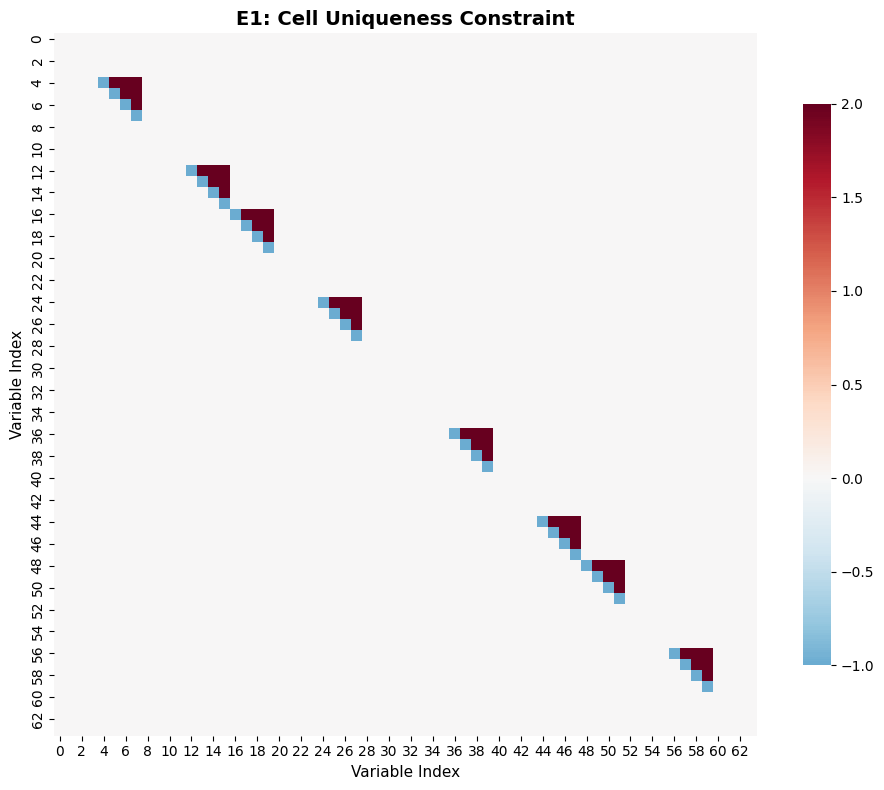


E1 Matrix Statistics:
  Shape: (64, 64)
  Non-zero elements: 80
  Sparsity: 98.0%


In [ ]:
# Visualize E1 matrix structure
visualize_qubo_matrix(Q_E1, title="E1: Cell Uniqueness Constraint", show_values=False)
print(f"\nE1 Matrix Statistics:")
print(f"  Shape: {Q_E1.shape}")
print(f"  Non-zero elements: {np.count_nonzero(Q_E1)}")
print(f"  Sparsity: {(1 - np.count_nonzero(Q_E1) / Q_E1.size) * 100:.1f}%")


### 📊 Matrix Structure Interpretation

The E₁ matrix has a **block diagonal structure** where:
- Each block corresponds to one cell's variables (4×4 for 4×4 Sudoku)
- Within each block, all pairs of variables are coupled (preventing multiple digits in one cell)
- Blocks don't interact (cell constraints are independent)

## Component 2: Row Uniqueness (E₂)

This constraint ensures no row has duplicate or missing digits.

$$E_2 = \sum_{i,k} \left(\sum_j x_{i,j,k} - 1\right)^2$$

When some cells are given, the constraint adjusts to account for already-placed digits.

In [ ]:
# Build E2 (each row has each digit exactly once)
Q_E2, poly_E2, const_E2 = build_E2(N, givens)

print("=" * 70)
print("E2: Each Row Has Each Digit Exactly Once")
print("=" * 70)
print(f"Number of terms: {len(poly_E2)}")
print(f"Constant: {const_E2}")

E2: Each Row Has Each Digit Exactly Once
Number of terms: 48
Constant: 8.0


In [ ]:
# View E2 polynomial
print_polynomial(poly_E2, const_E2, "E2: Each Row Has Each Digit", max_terms=15)


E2: Each Row Has Each Digit
Number of terms: 48
Constant: 8.0

First 15 terms:
  -1.0*x_010
  -1.0*x_030
  2*x_010*x_030
  1.0*x_011
  1.0*x_031
  2*x_011*x_031
  -1.0*x_012
  -1.0*x_032
  2*x_012*x_032
  1.0*x_013
  1.0*x_033
  2*x_013*x_033
  1.0*x_100
  1.0*x_120
  2*x_100*x_120
  ... (33 more terms)


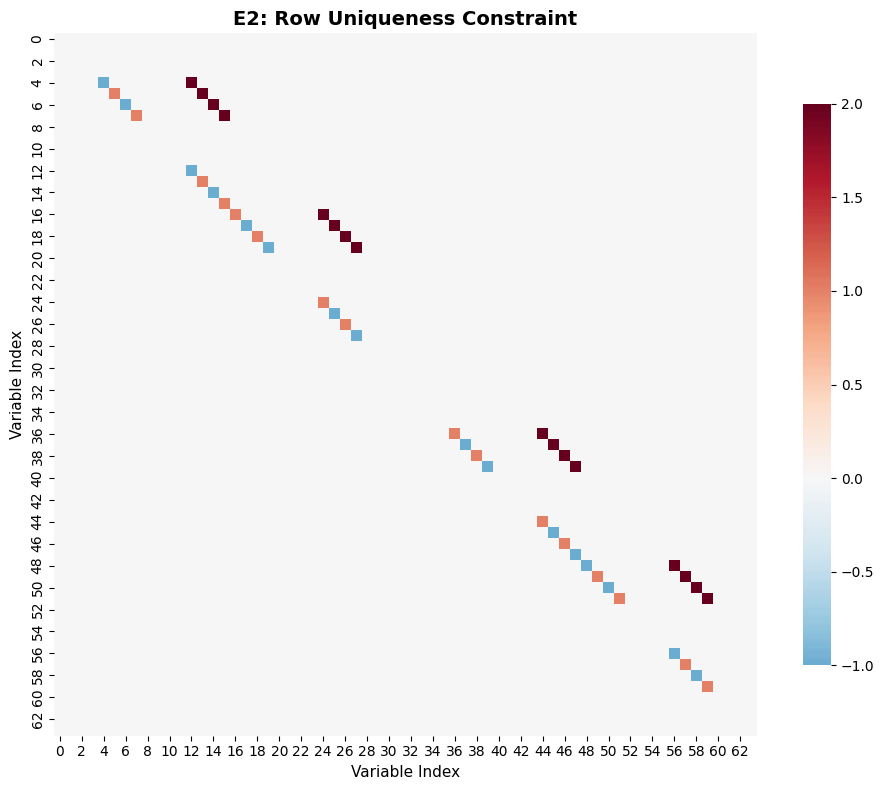


E2 Matrix Statistics:
  Shape: (64, 64)
  Non-zero elements: 48
  Sparsity: 98.8%


In [ ]:
# Visualize E2 matrix structure
visualize_qubo_matrix(Q_E2, title="E2: Row Uniqueness Constraint", show_values=False)
print(f"\nE2 Matrix Statistics:")
print(f"  Shape: {Q_E2.shape}")
print(f"  Non-zero elements: {np.count_nonzero(Q_E2)}")
print(f"  Sparsity: {(1 - np.count_nonzero(Q_E2) / Q_E2.size) * 100:.1f}%")


## Component 3: Column Uniqueness (E₃)

Similar to row constraints, but applied to columns.

$$E_3 = \sum_{j,k} \left(\sum_i x_{i,j,k} - 1\right)^2$$

In [ ]:
# Build E3 (each column has each digit exactly once)
Q_E3, poly_E3, const_E3 = build_E3(N, givens)

print("=" * 70)
print("E3: Each Column Has Each Digit Exactly Once")
print("=" * 70)
print(f"Number of terms: {len(poly_E3)}")
print(f"Constant: {const_E3}")

E3: Each Column Has Each Digit Exactly Once
Number of terms: 48
Constant: 8.0


In [ ]:
# View E3 polynomial
print_polynomial(poly_E3, const_E3, "E3: Each Column Has Each Digit", max_terms=15)


E3: Each Column Has Each Digit
Number of terms: 48
Constant: 8.0

First 15 terms:
  1.0*x_100
  1.0*x_300
  2*x_100*x_300
  1.0*x_101
  1.0*x_301
  2*x_101*x_301
  -1.0*x_102
  -1.0*x_302
  2*x_102*x_302
  -1.0*x_103
  -1.0*x_303
  2*x_103*x_303
  -1.0*x_010
  -1.0*x_210
  2*x_010*x_210
  ... (33 more terms)


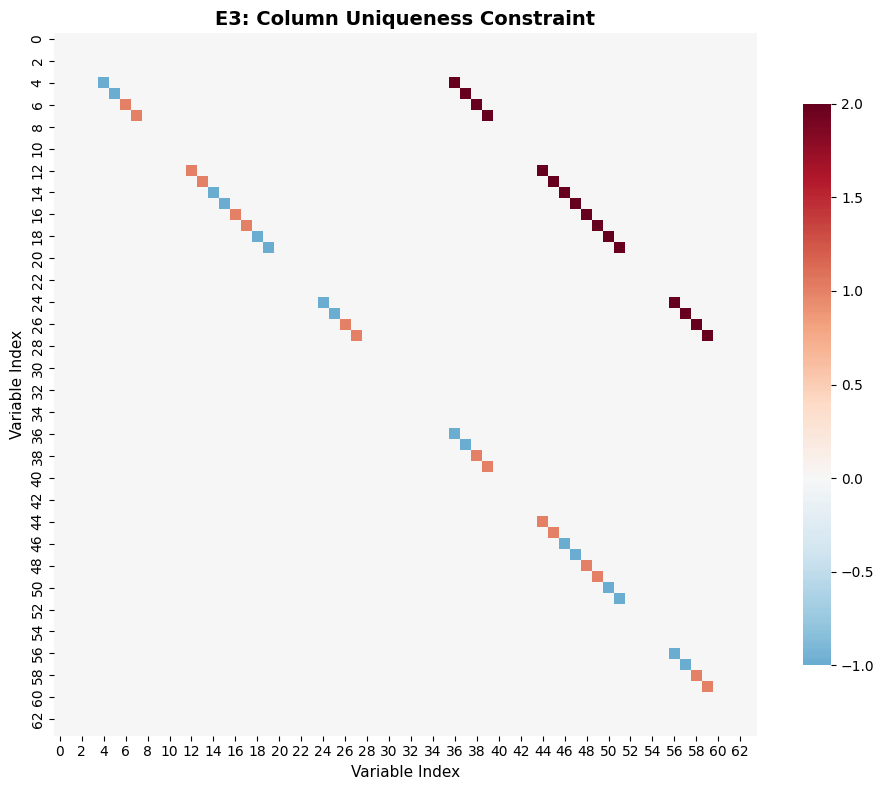


E3 Matrix Statistics:
  Shape: (64, 64)
  Non-zero elements: 48
  Sparsity: 98.8%


In [ ]:
# Visualize E3 matrix structure
visualize_qubo_matrix(Q_E3, title="E3: Column Uniqueness Constraint", show_values=False)
print(f"\nE3 Matrix Statistics:")
print(f"  Shape: {Q_E3.shape}")
print(f"  Non-zero elements: {np.count_nonzero(Q_E3)}")
print(f"  Sparsity: {(1 - np.count_nonzero(Q_E3) / Q_E3.size) * 100:.1f}%")


## Component 4: Box Uniqueness (E₄)

For a 4×4 Sudoku, we have four 2×2 boxes that must each contain digits 1-4 exactly once.

$$E_4 = \sum_{\text{box},k} \left(\sum_{(i,j) \in \text{box}} x_{i,j,k} - 1\right)^2$$

In [ ]:
# Build E4 (each box has each digit exactly once)
Q_E4, poly_E4, const_E4 = build_E4(N, box_size, givens)

print("=" * 70)
print("E4: Each Box Has Each Digit Exactly Once")
print("=" * 70)
print(f"Number of terms: {len(poly_E4)}")
print(f"Constant: {const_E4}")

E4: Each Box Has Each Digit Exactly Once
Number of terms: 48
Constant: 8.0


In [ ]:
# View E4 polynomial
print_polynomial(poly_E4, const_E4, "E4: Each Box Has Each Digit", max_terms=15)


E4: Each Box Has Each Digit
Number of terms: 48
Constant: 8.0

First 15 terms:
  -1.0*x_010
  -1.0*x_100
  2*x_010*x_100
  1.0*x_011
  1.0*x_101
  2*x_011*x_101
  1.0*x_012
  1.0*x_102
  2*x_012*x_102
  -1.0*x_013
  -1.0*x_103
  2*x_013*x_103
  1.0*x_030
  1.0*x_120
  2*x_030*x_120
  ... (33 more terms)


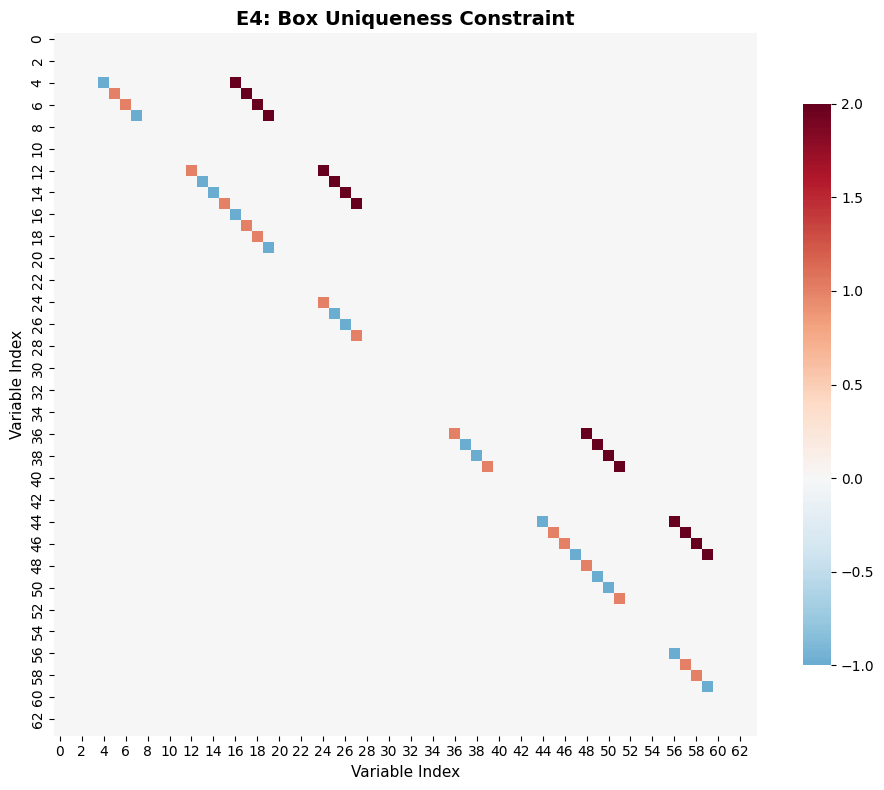


E4 Matrix Statistics:
  Shape: (64, 64)
  Non-zero elements: 48
  Sparsity: 98.8%


In [ ]:
# Visualize E4 matrix structure
visualize_qubo_matrix(Q_E4, title="E4: Box Uniqueness Constraint", show_values=False)
print(f"\nE4 Matrix Statistics:")
print(f"  Shape: {Q_E4.shape}")
print(f"  Non-zero elements: {np.count_nonzero(Q_E4)}")
print(f"  Sparsity: {(1 - np.count_nonzero(Q_E4) / Q_E4.size) * 100:.1f}%")


## Combining All Components

Now we combine all four energy components into a single QUBO matrix.

Since this is a pure constraint satisfaction problem (no objective to minimize), all Lagrange multipliers are set to 1.

$$Q_{\text{total}} = Q_{E_1} + Q_{E_2} + Q_{E_3} + Q_{E_4}$$

Combined QUBO Matrix

QUBO Matrix Statistics:
  Size: 64 × 64
  Total possible entries: 4,096
  Non-zero diagonal entries: 8
  Non-zero off-diagonal entries: 96
  Total non-zero entries: 104
  Sparsity: 97.46%

Given cells: 8
Free variables: 32
Total constant offset: 32.0


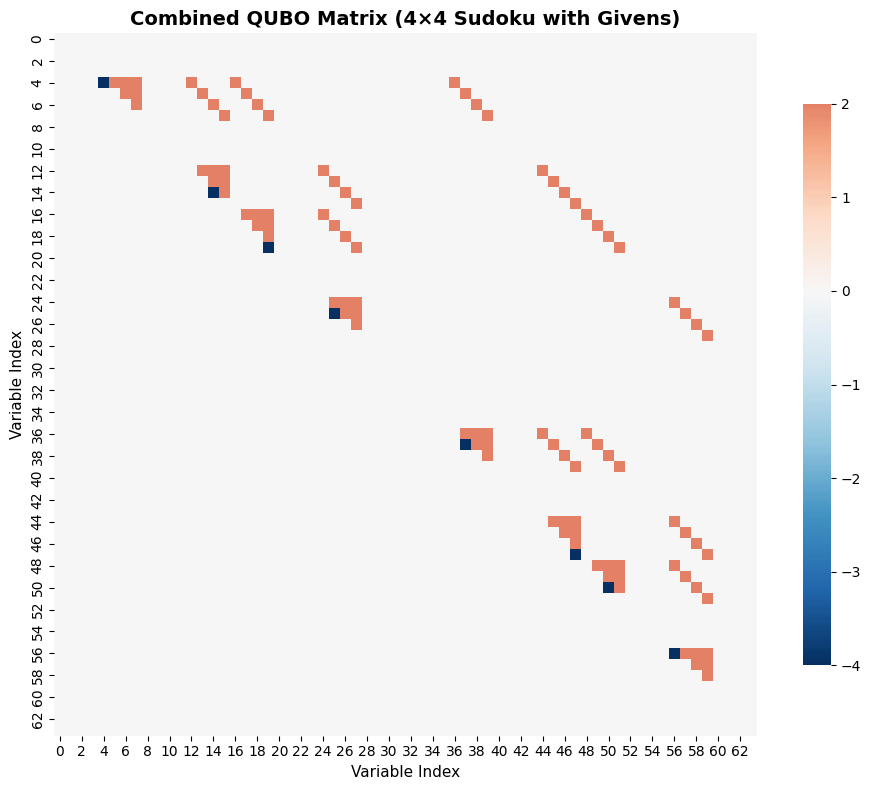

In [ ]:
# Combine all QUBO matrices (all Lagrange multipliers = 1)
Q_total = Q_E1 + Q_E2 + Q_E3 + Q_E4
offset_total = const_E1 + const_E2 + const_E3 + const_E4

print("=" * 70)
print("Combined QUBO Matrix")
print("=" * 70)
print_qubo_stats(Q_total, N, givens)
print(f"Total constant offset: {offset_total}")

# Visualize the combined QUBO
visualize_qubo_matrix(Q_total, f"Combined QUBO Matrix ({N}×{N} Sudoku with Givens)", show_values=False)

### 📊 Interpreting the Combined Matrix

The complete QUBO matrix shows:

1. **Diagonal elements** (linear terms): Encourage variables to take value 1
2. **Off-diagonal elements** (quadratic terms): Encode constraint relationships
3. **Block structure**: Reflects the layered constraint structure
4. **Sparsity**: Most variable pairs don't interact (only constrained pairs have non-zero entries)

The goal is to find a binary assignment that minimizes this quadratic form to reach E=0.

## Testing the QUBO

Let's validate our QUBO by testing it with correct and incorrect solutions.

### Test Case 1: Correct Solution ✅

In [ ]:
# Correct solution bitstring
bitstring_correct = (
    "0100" + "1000" + "0001" + "0010" +  # Row 0: 2,1,4,3
    "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
    "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
    "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
)

print("Test Case 1: Correct Solution")
print("=" * 70)

# Evaluate using calc_mods
energy_calc, breakdown = total_energy(bitstring_correct, N, box_size, verbose=False)
print(f"\ncalc_mods energy: {energy_calc}")
print(f"Breakdown: E1={breakdown[0]}, E2={breakdown[1]}, E3={breakdown[2]}, E4={breakdown[3]}")
print(f"Valid solution: {is_valid_solution(breakdown)}")

# Evaluate using QUBO
Q_full, var_to_idx, idx_to_var, offset_full = build_sudoku_qubo(N, box_size, givens)
energy_qubo = evaluate_qubo(Q_full, bitstring_correct, offset_full)
print(f"\nQUBO energy: {energy_qubo}")

# Visualize the solution
from calc_mods import bitstring_to_tensor
x = bitstring_to_tensor(bitstring_correct, N)
grid = tensor_to_grid(x, N)
print("\nSolution grid:")
print_grid(grid, N, box_size)

Test Case 1: Correct Solution

calc_mods energy: 0.0
Breakdown: E1=0, E2=0, E3=0, E4=0
Valid solution: True

QUBO energy: 0.0

Solution grid:
2 1 | 4 3
4 3 | 2 1
---------
1 2 | 3 4
3 4 | 1 2


### Test Case 2: Incorrect Solution ❌

In [ ]:
# Incorrect solution - swap cells (0,1) and (0,3): 1↔3
bitstring_wrong = (
    "0100" + "0010" + "0001" + "1000" +  # Row 0: 2,3,4,1 (wrong!)
    "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
    "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
    "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
)

print("Test Case 2: Incorrect Solution")
print("=" * 70)

# Evaluate using calc_mods
energy_calc_wrong, breakdown_wrong = total_energy(bitstring_wrong, N, box_size, verbose=True)
print(f"\nValid solution: {is_valid_solution(breakdown_wrong)}")

# Evaluate using QUBO
energy_qubo_wrong = evaluate_qubo(Q_full, bitstring_wrong, offset_full)
print(f"\nQUBO energy: {energy_qubo_wrong}")
print(f"Energy difference from correct: {energy_qubo_wrong - energy_qubo}")

print("\nThe incorrect solution has HIGHER energy, as expected!")

Test Case 2: Incorrect Solution

Tensor x[i,j,k] shape: (4, 4, 4)

Sudoku grid:
2 3 | 4 1
4 3 | 2 1
---------
1 2 | 3 4
3 4 | 1 2

Computing energy components:
  E1 (cell constraint)   = 0
  E2 (row constraint)    = 0
  E3 (column constraint) = 4
  E4 (box constraint)    = 4

Total energy calculation:
  E = 1.0×0 + 1.0×0 + 1.0×4 + 1.0×4
  E = 0.0 + 0.0 + 4.0 + 4.0
  E = 8.0

Valid solution: False

QUBO energy: 8.0
Energy difference from correct: 8.0

The incorrect solution has HIGHER energy, as expected!


**Validation:** Correct solution → E=0 ✓ | Incorrect solution → E>0 ✓

---
# 6. Variable Elimination & Reduction

When cells have **given values**, we can eliminate their variables and reduce the QUBO size dramatically.

For each given cell $(i,j)$ with digit $d$: set $x_{i,j,d-1} = 1$, all others to 0, then remove from QUBO.


In [ ]:
print("="*80)
print("MATRIX REDUCTION: Comparing Two Methods")
print("="*80)
print()

# Method 1: Extraction approach (build full, extract submatrix)
print("Method 1: Extraction from Full QUBO")
print("-" * 40)
Q_reduced_ext, var_to_idx_ext, idx_to_var_ext, offset_ext, info_ext = build_reduced_qubo(
    N, box_size, givens
)
print(f"  Built {Q_reduced_ext.shape[0]}×{Q_reduced_ext.shape[1]} matrix")
print(f"  Non-zero entries: {np.count_nonzero(Q_reduced_ext)}")
print(f"  Process: Build 64×64 → Extract 32×32")
print()

# Method 2: Direct construction (build reduced directly)
print("Method 2: Direct Construction")
print("-" * 40)
Q_reduced_dir, var_to_idx_dir, idx_to_var_dir, offset_dir, info_dir = build_reduced_qubo_direct(
    N, box_size, givens
)
print(f"  Built {Q_reduced_dir.shape[0]}×{Q_reduced_dir.shape[1]} matrix")
print(f"  Non-zero entries: {np.count_nonzero(Q_reduced_dir)}")
print(f"  Process: Build 32×32 directly")
print()

# Verify they're identical
print("Verification")
print("-" * 40)
matrices_match = np.allclose(Q_reduced_ext, Q_reduced_dir)
offsets_match = abs(offset_ext - offset_dir) < 1e-10

print(f"  Matrices identical? {matrices_match} {'✓' if matrices_match else '✗'}")
print(f"  Offsets identical? {offsets_match} {'✓' if offsets_match else '✗'}")
print()

if matrices_match and offsets_match:
    print("✓ SUCCESS: Both methods produce identical results!")
else:
    print("✗ MISMATCH: Methods produced different results")

# Use direct method for remaining work
Q_reduced = Q_reduced_dir
var_to_idx_reduced = var_to_idx_dir
idx_to_var_reduced = idx_to_var_dir
offset_reduced = offset_dir
reduction_info = info_dir

MATRIX REDUCTION: Comparing Two Methods

Method 1: Extraction from Full QUBO
----------------------------------------
  Built 32×32 matrix
  Non-zero entries: 104
  Process: Build 64×64 → Extract 32×32

Method 2: Direct Construction
----------------------------------------
  Built 32×32 matrix
  Non-zero entries: 104
  Process: Build 32×32 directly

Verification
----------------------------------------
  Matrices identical? True ✓
  Offsets identical? True ✓

✓ SUCCESS: Both methods produce identical results!


In [ ]:
# Display detailed reduction statistics
print_reduction_stats(reduction_info, N, box_size)

print("\n" + "="*80)
print("Variable Breakdown")
print("="*80)
print()

print("Given cells and their fixed values:")
for (i, j), digit in sorted(givens.items()):
    print(f"  Cell ({i},{j}) = {digit} → 4 variables ELIMINATED")

print(f"\nFree cells (need to solve):")
free_cells = [(i, j) for i in range(N) for j in range(N) if (i, j) not in givens]
for idx, (i, j) in enumerate(free_cells[:5]):
    print(f"  Cell ({i},{j}) = ? → 4 variables ACTIVE")
if len(free_cells) > 5:
    print(f"  ... and {len(free_cells) - 5} more free cells")

print(f"\nIndex Remapping Example:")
print(f"  Full QUBO uses indices 0-63")
print(f"  Reduced QUBO uses indices 0-31")
print(f"\nSample mappings:")
for i in range(5):
    var = idx_to_var_reduced[i]
    print(f"  Reduced index {i} → x{var} (cell ({var[0]},{var[1]}), digit {var[2]+1})")


Variable Elimination Statistics:
  Total variables: 64
  Given cells: 8
  Eliminated variables: 32
  Free variables: 32
  Variable reduction: 50.0%
  Matrix size reduction: 75.0%

Matrix Dimensions:
  Full QUBO: 64×64 = 4,096 entries
  Reduced QUBO: 32×32 = 1,024 entries
  Savings: 3,072 entries

Variable Breakdown

Given cells and their fixed values:
  Cell (0,0) = 2 → 4 variables ELIMINATED
  Cell (0,2) = 4 → 4 variables ELIMINATED
  Cell (1,1) = 3 → 4 variables ELIMINATED
  Cell (1,3) = 1 → 4 variables ELIMINATED
  Cell (2,0) = 1 → 4 variables ELIMINATED
  Cell (2,2) = 3 → 4 variables ELIMINATED
  Cell (3,1) = 4 → 4 variables ELIMINATED
  Cell (3,3) = 2 → 4 variables ELIMINATED

Free cells (need to solve):
  Cell (0,1) = ? → 4 variables ACTIVE
  Cell (0,3) = ? → 4 variables ACTIVE
  Cell (1,0) = ? → 4 variables ACTIVE
  Cell (1,2) = ? → 4 variables ACTIVE
  Cell (2,1) = ? → 4 variables ACTIVE
  ... and 3 more free cells

Index Remapping Example:
  Full QUBO uses indices 0-63
  Redu

Variable elimination: 64×64 → 32×32 matrix (75% fewer elements). Essential for quantum hardware.

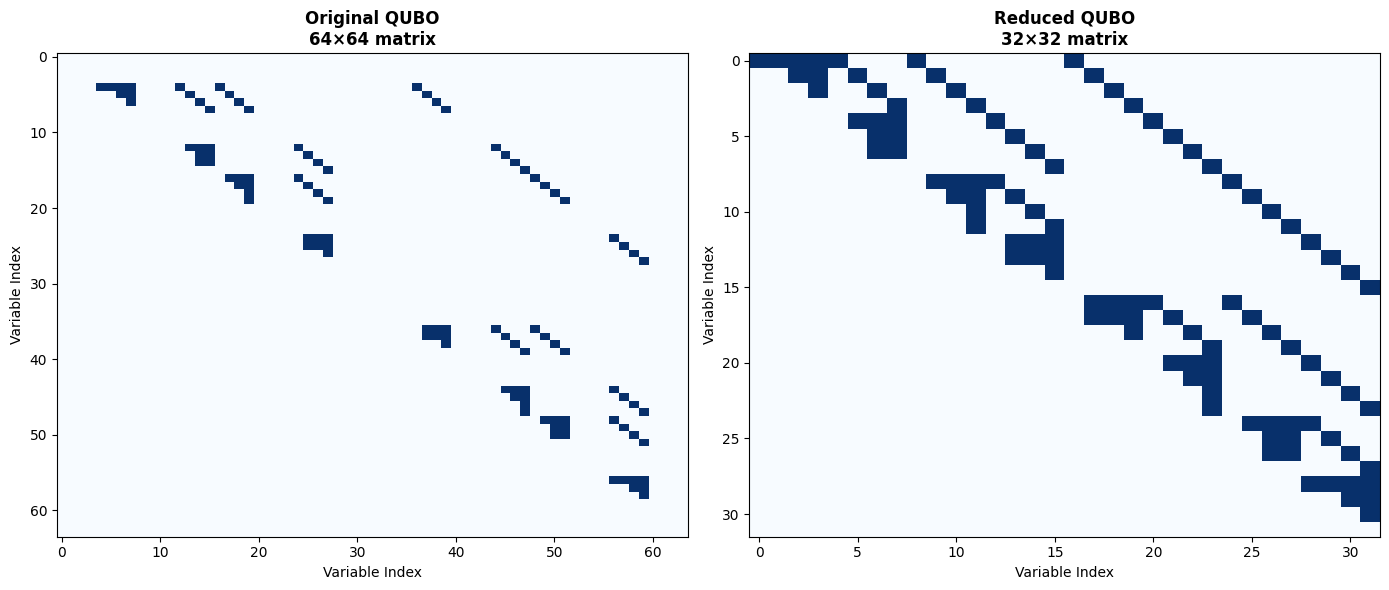


🎯 Variable elimination reduced the problem by 50%


In [ ]:
# Compare original vs reduced matrices side by side
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Original (with givens factored in but not eliminated)
im1 = ax1.imshow(Q_total != 0, cmap='Blues', aspect='auto')
ax1.set_title(f"Original QUBO\n{Q_total.shape[0]}×{Q_total.shape[1]} matrix", fontsize=12, fontweight='bold')
ax1.set_xlabel('Variable Index')
ax1.set_ylabel('Variable Index')

# Reduced (givens eliminated)
im2 = ax2.imshow(Q_reduced != 0, cmap='Blues', aspect='auto')
ax2.set_title(f"Reduced QUBO\n{Q_reduced.shape[0]}×{Q_reduced.shape[1]} matrix", fontsize=12, fontweight='bold')
ax2.set_xlabel('Variable Index')
ax2.set_ylabel('Variable Index')

plt.tight_layout()
plt.show()

print(f"\n🎯 Variable elimination reduced the problem by {((1 - Q_reduced.shape[0]/Q_total.shape[0])*100):.0f}%")


## Testing the Reduced QUBO

Let's verify that the reduced QUBO produces the same energy values as the original.

In [ ]:
print("="*80)
print("Energy Comparison: Full vs Reduced QUBO")
print("="*80)
print()

# Correct solution (from earlier)
bitstring_correct = (
    "0100" + "1000" + "0001" + "0010" +  # Row 0: 2,1,4,3
    "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
    "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
    "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
)

# Build full QUBO
Q_full_test, _, _, offset_full = build_sudoku_qubo(N, box_size, givens)

# Evaluate with full QUBO
energy_full = evaluate_qubo(Q_full_test, bitstring_correct, offset_full)

# Evaluate with reduced QUBO
energy_reduced = evaluate_reduced_qubo(
    Q_reduced, bitstring_correct,
    var_to_idx_reduced, idx_to_var_reduced,
    offset_reduced
)

print("Correct Solution:")
print(f"  Full QUBO energy:    {energy_full:.6f}")
print(f"  Reduced QUBO energy: {energy_reduced:.6f}")
print(f"  Difference:          {abs(energy_full - energy_reduced):.10f}")
print(f"  Match: {'✓ IDENTICAL' if abs(energy_full - energy_reduced) < 1e-10 else '✗ DIFFERENT'}")
print()

# Try an incorrect solution
bitstring_wrong = (
    "0100" + "0010" + "0001" + "1000" +  # Row 0: 2,3,4,1 (WRONG!)
    "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
    "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
    "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
)

energy_full_wrong = evaluate_qubo(Q_full_test, bitstring_wrong, offset_full)
energy_reduced_wrong = evaluate_reduced_qubo(
    Q_reduced, bitstring_wrong,
    var_to_idx_reduced, idx_to_var_reduced,
    offset_reduced
)

print("Incorrect Solution:")
print(f"  Full QUBO energy:    {energy_full_wrong:.6f}")
print(f"  Reduced QUBO energy: {energy_reduced_wrong:.6f}")
print(f"  Difference:          {abs(energy_full_wrong - energy_reduced_wrong):.10f}")
print(f"  Match: {'✓ IDENTICAL' if abs(energy_full_wrong - energy_reduced_wrong) < 1e-10 else '✗ DIFFERENT'}")
print()

print("Penalty Comparison:")
print(f"  Full QUBO:    {energy_full_wrong - energy_full:.6f} penalty for wrong solution")
print(f"  Reduced QUBO: {energy_reduced_wrong - energy_reduced:.6f} penalty for wrong solution")
print()
print("✓ Reduced QUBO preserves the complete energy landscape!")

Energy Comparison: Full vs Reduced QUBO

Correct Solution:
  Full QUBO energy:    0.000000
  Reduced QUBO energy: 0.000000
  Difference:          0.0000000000
  Match: ✓ IDENTICAL

Incorrect Solution:
  Full QUBO energy:    8.000000
  Reduced QUBO energy: 8.000000
  Difference:          0.0000000000
  Match: ✓ IDENTICAL

Penalty Comparison:
  Full QUBO:    8.000000 penalty for wrong solution
  Reduced QUBO: 8.000000 penalty for wrong solution

✓ Reduced QUBO preserves the complete energy landscape!


## Solution Reconstruction

Reduced solutions can be expanded back to full grids by reinserting the given values.

In [ ]:
print("="*80)
print("Solution Reconstruction Demo")
print("="*80)
print()

# Extract just the free variable bits from correct solution
reduced_bits = ""
idx_full = 0
for i in range(N):
    for j in range(N):
        for k in range(N):
            if (i, j, k) in var_to_idx_reduced:
                reduced_bits += bitstring_correct[idx_full]
            idx_full += 1

print(f"Original full solution:     {len(bitstring_correct)} bits")
print(f"  First 32 bits: {bitstring_correct[:32]}")
print(f"  Last 32 bits:  {bitstring_correct[32:]}")
print()

print(f"Extracted reduced solution: {len(reduced_bits)} bits")
print(f"  {reduced_bits}")
print("  (Only bits for free cells!)")
print()

# Reconstruct
reconstructed = reconstruct_full_solution(
    reduced_bits,
    var_to_idx_reduced,
    idx_to_var_reduced,
    givens,
    N
)

print(f"Reconstructed full solution: {len(reconstructed)} bits")
print(f"  First 32 bits: {reconstructed[:32]}")
print(f"  Last 32 bits:  {reconstructed[32:]}")
print()

# Verify
match = (reconstructed == bitstring_correct)
print(f"Match with original: {match} {'✓' if match else '✗'}")
print()

if match:
    print("✓ Perfect reconstruction!")
    print("  • Solved with 32 variables (reduced QUBO)")
    print("  • Reconstructed to 64 bits (full solution)")
    print("  • Added back the 32 bits for given cells")
else:
    print("✗ Reconstruction failed - investigating...")
    # Show where they differ
    for i in range(len(bitstring_correct)):
        if bitstring_correct[i] != reconstructed[i]:
            print(f"  Bit {i}: expected {bitstring_correct[i]}, got {reconstructed[i]}")

Solution Reconstruction Demo

Original full solution:     64 bits
  First 32 bits: 01001000000100100001001001001000
  Last 32 bits:  10000100001000010010000110000100

Extracted reduced solution: 32 bits
  10000010000101000100000100101000
  (Only bits for free cells!)

Reconstructed full solution: 64 bits
  First 32 bits: 01001000000100100001001001001000
  Last 32 bits:  10000100001000010010000110000100

Match with original: True ✓

✓ Perfect reconstruction!
  • Solved with 32 variables (reduced QUBO)
  • Reconstructed to 64 bits (full solution)
  • Added back the 32 bits for given cells


---
# 7. Scaling to 9×9

| Metric | 4×4 | 9×9 | Growth |
|--------|-----|-----|--------|
| Cells | 16 | 81 | 5× |
| Variables | 64 | 729 | 11× |
| Matrix elements | 4,096 | 531,441 | 130× |


In [ ]:
# Build QUBO for blank 9×9 Sudoku (construction only)
N_large = 9
box_size_large = 3
givens_large = None

print("Building 9×9 Sudoku QUBO...")
Q_large, var_to_idx_large, idx_to_var_large, offset_large = build_sudoku_qubo(
    N_large, box_size_large, givens_large
)

print("\n" + "=" * 70)
print("Blank 9×9 Sudoku")
print("=" * 70)
print_qubo_stats(Q_large, N_large, givens_large)
print(f"Total constant offset: {offset_large}")

print("\nThe 9×9 QUBO has been successfully constructed!")
print(f"Matrix size: {Q_large.shape[0]}×{Q_large.shape[1]}")

Building 9×9 Sudoku QUBO...

Blank 9×9 Sudoku

QUBO Matrix Statistics:
  Size: 729 × 729
  Total possible entries: 531,441
  Non-zero diagonal entries: 729
  Non-zero off-diagonal entries: 10206
  Total non-zero entries: 10935
  Sparsity: 97.94%
Total constant offset: 324.0

The 9×9 QUBO has been successfully constructed!
Matrix size: 729×729


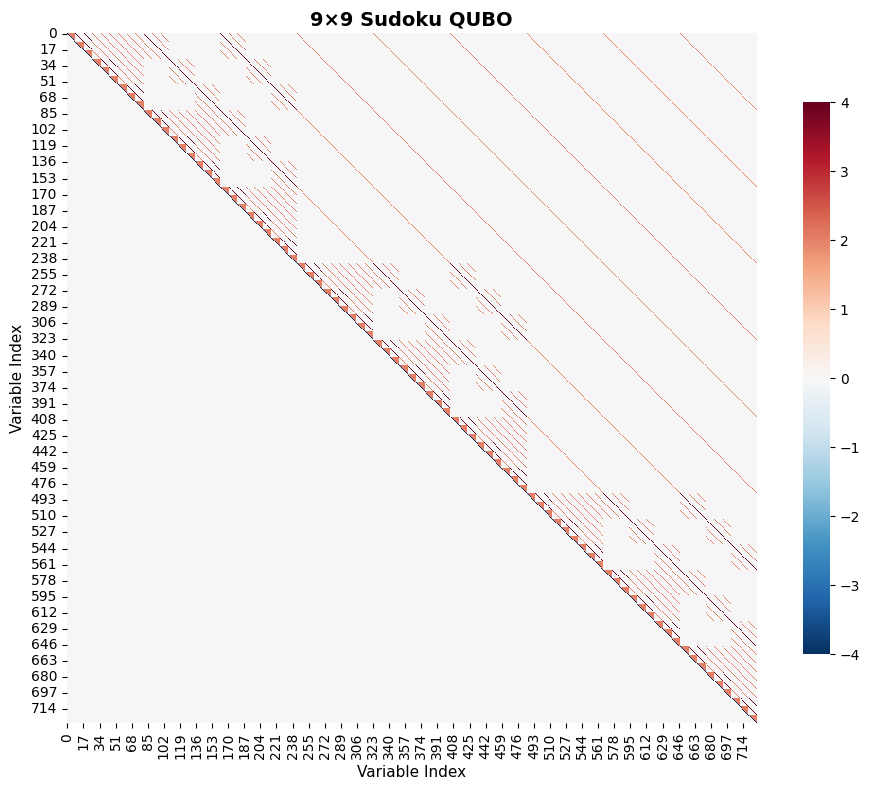


9×9 SUDOKU QUBO STATISTICS
Matrix shape: (729, 729)
Total elements: 531,441
Non-zero elements: 10,935
Sparsity: 97.9%

This is a 729×729 matrix!

This is a blank 9×9 Sudoku with all 729 variables free to optimize.


In [ ]:
# Visualize the 9x9 QUBO structure
visualize_qubo_matrix(Q_large, title="9×9 Sudoku QUBO", show_values=False)

print(f"\n{'='*80}")
print("9×9 SUDOKU QUBO STATISTICS")
print(f"{'='*80}")
print(f"Matrix shape: {Q_large.shape}")
print(f"Total elements: {Q_large.size:,}")
print(f"Non-zero elements: {np.count_nonzero(Q_large):,}")
print(f"Sparsity: {(1 - np.count_nonzero(Q_large) / Q_large.size) * 100:.1f}%")
print(f"\nThis is a {Q_large.shape[0]}×{Q_large.shape[1]} matrix!")
if givens_large:
    print(f"\nWith {len(givens_large)} givens, we have {Q_large.shape[0]} free variables to optimize.")
else:
    print(f"\nThis is a blank 9×9 Sudoku with all {Q_large.shape[0]} variables free to optimize.")


## Scaling Analysis


Scaling Analysis:
 N  Variables  Constraints Matrix Size Sparsity
 4         64           64       64×64   89.06%
 9        729          324     729×729   99.50%
16       4096         1024   4096×4096   99.94%
25      15625         2500 15625×15625   99.99%


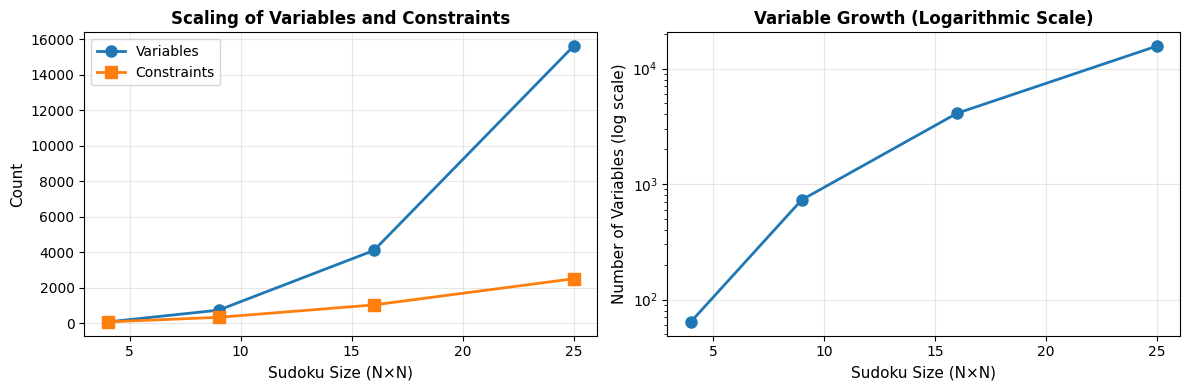

In [ ]:
# Analyze scaling
sizes = [(4, 4), (9, 9), (16, 16), (25, 25)]
data = []

for n in [4, 9, 16, 25]:
    n_vars = n ** 3
    n_constraints = 4 * n * n
    # Estimate non-zero entries (empirical from our examples)
    sparsity = 1 - (n_vars + 4 * 6 * n * n) / (n_vars ** 2)
    data.append({
        'N': n,
        'Variables': n_vars,
        'Constraints': n_constraints,
        'Matrix Size': f'{n_vars}×{n_vars}',
        'Sparsity': f'{sparsity*100:.2f}%'
    })

import pandas as pd
df = pd.DataFrame(data)
print("\nScaling Analysis:")
print("=" * 70)
print(df.to_string(index=False))

# Plot scaling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ns = [4, 9, 16, 25]
vars = [n**3 for n in ns]
constraints = [4*n*n for n in ns]

ax1.plot(ns, vars, 'o-', linewidth=2, markersize=8, label='Variables')
ax1.plot(ns, constraints, 's-', linewidth=2, markersize=8, label='Constraints')
ax1.set_xlabel('Sudoku Size (N×N)', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('Scaling of Variables and Constraints', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.semilogy(ns, vars, 'o-', linewidth=2, markersize=8)
ax2.set_xlabel('Sudoku Size (N×N)', fontsize=11)
ax2.set_ylabel('Number of Variables (log scale)', fontsize=11)
ax2.set_title('Variable Growth (Logarithmic Scale)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Key insight:** Matrix size grows as $O(N^6)$. Variable elimination is essential for 9×9 and larger.

---
# 8. Classical Baseline: Simulated Annealing

Now let's **solve** the QUBO using Simulated Annealing (SA) from D-Wave's `neal` package.

**Simulated Annealing** is a probabilistic optimization inspired by metallurgical annealing:
- High temperature → explore (accept worse moves)
- Cooling → exploit (converge to minimum)

At temperature $T$, uphill moves are accepted with probability $e^{-\Delta E / T}$.


In [ ]:
# Install D-Wave's neal package for Simulated Annealing
!pip install dwave-ocean-sdk dwave-neal -q

print("✓ D-Wave Ocean SDK installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.5/167.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
✓ D-Wave Ocean SDK installed


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# D-Wave imports
from dimod import BinaryQuadraticModel
from neal import SimulatedAnnealingSampler

print("✓ Imports successful")

✓ Imports successful


## 8.2 Converting QUBO to BinaryQuadraticModel

D-Wave's `neal` sampler expects a `BinaryQuadraticModel`. We convert our NumPy QUBO matrix:

In [ ]:
def qubo_matrix_to_bqm(Q, offset=0.0):
    """
    Convert a QUBO matrix (NumPy array) to a D-Wave BinaryQuadraticModel.

    Args:
        Q: QUBO matrix (n x n numpy array)
        offset: Constant energy offset

    Returns:
        BinaryQuadraticModel in BINARY vartype
    """
    n = Q.shape[0]
    linear = {}
    quadratic = {}

    for i in range(n):
        # Diagonal elements are linear biases
        if Q[i, i] != 0:
            linear[i] = Q[i, i]

        # Off-diagonal elements are quadratic biases
        for j in range(i + 1, n):
            # QUBO matrices store Q[i,j] + Q[j,i] for the coupling
            coupling = Q[i, j] + Q[j, i]
            if coupling != 0:
                quadratic[(i, j)] = coupling

    return BinaryQuadraticModel(linear, quadratic, offset, vartype='BINARY')

print("✓ QUBO to BQM converter defined")

✓ QUBO to BQM converter defined


## 8.3 Test Case 1: Blank 4×4 Sudoku

First, let's solve the **blank 4×4 Sudoku** (no givens). This has 64 binary variables.

Since there are no clues, any valid Sudoku solution should achieve energy = 0.

In [ ]:
# Build QUBO for blank 4×4 Sudoku
N_4x4 = 4
box_size_4x4 = 2
givens_4x4 = None  # No givens = blank puzzle

Q_4x4, var_to_idx_4x4, idx_to_var_4x4, offset_4x4 = build_sudoku_qubo(
    N_4x4, box_size_4x4, givens_4x4
)

print("=" * 60)
print("BLANK 4×4 SUDOKU QUBO")
print("=" * 60)
print(f"Matrix size: {Q_4x4.shape[0]} × {Q_4x4.shape[1]}")
print(f"Number of variables: {Q_4x4.shape[0]}")
print(f"Non-zero elements: {np.count_nonzero(Q_4x4)}")
print(f"Offset: {offset_4x4}")

BLANK 4×4 SUDOKU QUBO
Matrix size: 64 × 64
Number of variables: 64
Non-zero elements: 384
Offset: 64.0


In [ ]:
# Convert to BQM
bqm_4x4 = qubo_matrix_to_bqm(Q_4x4, offset_4x4)

print("BinaryQuadraticModel created:")
print(f"  Variables: {len(bqm_4x4.variables)}")
print(f"  Linear biases: {len(bqm_4x4.linear)}")
print(f"  Quadratic interactions: {len(bqm_4x4.quadratic)}")
print(f"  Offset: {bqm_4x4.offset}")

BinaryQuadraticModel created:
  Variables: 64
  Linear biases: 64
  Quadratic interactions: 320
  Offset: 64.0


In [ ]:
# Solve using Simulated Annealing
sa_sampler = SimulatedAnnealingSampler()

NUM_READS = 100
sa_result_4x4 = sa_sampler.sample(bqm_4x4, num_reads=NUM_READS)

# Get the best solution
best_4x4 = sa_result_4x4.first

print("=" * 60)
print("SIMULATED ANNEALING RESULTS: Blank 4×4 Sudoku")
print("=" * 60)
print(f"Best energy: {best_4x4.energy}")
print(f"Target energy (valid solution): 0")
print(f"Found valid solution: {'✓ YES' if best_4x4.energy == 0 else '✗ NO'}")
print(f"\nNumber of reads: {NUM_READS}")

# Energy statistics
energies_4x4 = [s.energy for s in sa_result_4x4.data()]
print(f"\nEnergy statistics:")
print(f"  Min: {min(energies_4x4)}")
print(f"  Max: {max(energies_4x4)}")
print(f"  Mean: {np.mean(energies_4x4):.2f}")
print(f"  Std: {np.std(energies_4x4):.2f}")

SIMULATED ANNEALING RESULTS: Blank 4×4 Sudoku
Best energy: 0.0
Target energy (valid solution): 0
Found valid solution: ✓ YES

Number of reads: 100

Energy statistics:
  Min: 0.0
  Max: 4.0
  Mean: 0.08
  Std: 0.56


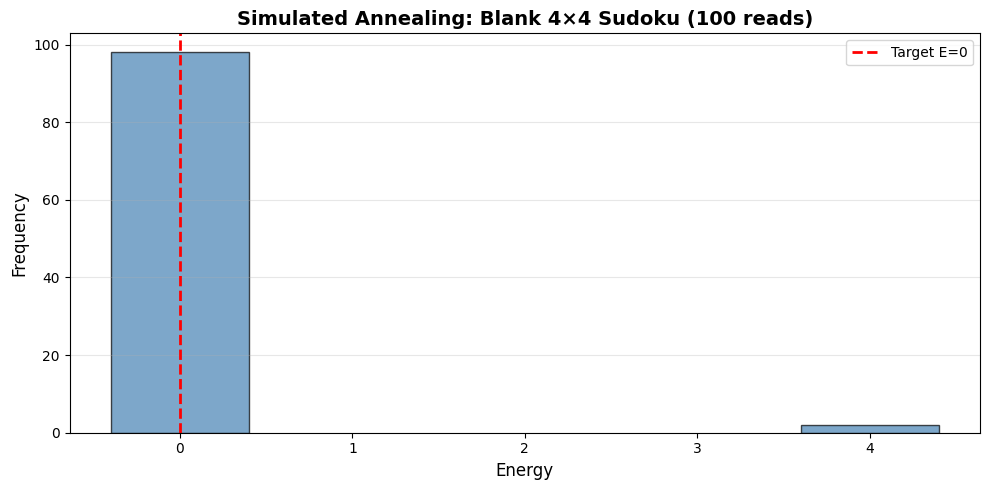


Success rate: 98/100 = 98.0%


In [ ]:
# Visualize energy distribution
plt.figure(figsize=(10, 5))

energy_counts_4x4 = Counter(energies_4x4)
energies_sorted = sorted(energy_counts_4x4.keys())
counts = [energy_counts_4x4[e] for e in energies_sorted]

plt.bar(energies_sorted, counts, color='steelblue', alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Target E=0')
plt.xlabel('Energy', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Simulated Annealing: Blank 4×4 Sudoku ({NUM_READS} reads)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Success rate
n_optimal = sum(1 for e in energies_4x4 if e == 0)
print(f"\nSuccess rate: {n_optimal}/{NUM_READS} = {100*n_optimal/NUM_READS:.1f}%")

In [ ]:
def solution_to_grid(sample, idx_to_var, N):
    """
    Convert a BQM solution to a Sudoku grid.

    Args:
        sample: Dict mapping variable index to value (0 or 1)
        idx_to_var: Mapping from index to (i, j, k) tuple
        N: Sudoku size

    Returns:
        grid: N×N numpy array with digits 1-N (0 for unfilled)
    """
    grid = np.zeros((N, N), dtype=int)

    for idx, val in sample.items():
        if val == 1:
            i, j, k = idx_to_var[idx]
            grid[i, j] = k + 1  # k is 0-indexed, digits are 1-indexed

    return grid

def visualize_sudoku(grid, N, box_size, title="Sudoku Solution", givens=None):
    """
    Visualize a Sudoku grid.
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, N)
    ax.set_ylim(0, N)
    ax.set_aspect('equal')

    # Draw grid lines
    for i in range(N + 1):
        lw = 2.5 if i % box_size == 0 else 0.5
        ax.axhline(y=i, color='black', linewidth=lw)
        ax.axvline(x=i, color='black', linewidth=lw)

    # Fill in numbers
    for i in range(N):
        for j in range(N):
            if grid[i, j] != 0:
                # Check if this was a given
                is_given = givens and (i, j) in givens
                color = 'blue' if is_given else 'black'
                weight = 'bold' if is_given else 'normal'
                ax.text(j + 0.5, N - i - 0.5, str(grid[i, j]),
                       ha='center', va='center', fontsize=18,
                       fontweight=weight, color=color)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("✓ Visualization functions defined")

✓ Visualization functions defined


Best solution found:
[[4 3 1 2]
 [1 2 4 3]
 [3 4 2 1]
 [2 1 3 4]]



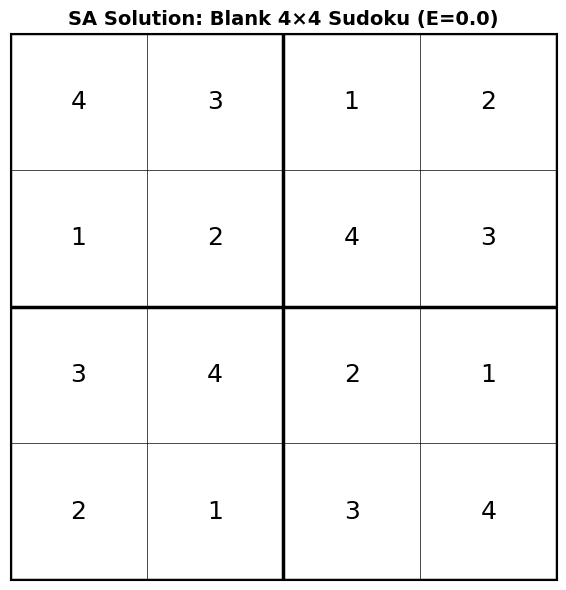

Validation:
  All cells filled: ✓
  Rows valid: ✓
  Cols valid: ✓


In [ ]:
# Convert best solution to grid and visualize
grid_4x4 = solution_to_grid(best_4x4.sample, idx_to_var_4x4, N_4x4)

print("Best solution found:")
print(grid_4x4)
print()

visualize_sudoku(grid_4x4, N_4x4, box_size_4x4,
                 f"SA Solution: Blank 4×4 Sudoku (E={best_4x4.energy})")

# Validate
print("Validation:")
print(f"  All cells filled: {'✓' if np.all(grid_4x4 > 0) else '✗'}")
print(f"  Rows valid: {'✓' if all(len(set(grid_4x4[i,:])) == N_4x4 and 0 not in grid_4x4[i,:] for i in range(N_4x4)) else '✗'}")
print(f"  Cols valid: {'✓' if all(len(set(grid_4x4[:,j])) == N_4x4 and 0 not in grid_4x4[:,j] for j in range(N_4x4)) else '✗'}")

## 8.4 Test Case 2: Partially-Filled 9×9 Sudoku

Now let's try a more realistic problem: a **9×9 Sudoku with givens**.

We'll use a puzzle with ~30 clues, which reduces our variable count significantly.

In [ ]:
# Define a 9×9 Sudoku puzzle with givens
# This is a standard "easy" puzzle
N_9x9 = 9
box_size_9x9 = 3

# Puzzle (0 = empty, digits 1-9 for givens)
puzzle_9x9 = [
    [5, 3, 0, 0, 7, 0, 0, 0, 0],
    [6, 0, 0, 1, 9, 5, 0, 0, 0],
    [0, 9, 8, 0, 0, 0, 0, 6, 0],
    [8, 0, 0, 0, 6, 0, 0, 0, 3],
    [4, 0, 0, 8, 0, 3, 0, 0, 1],
    [7, 0, 0, 0, 2, 0, 0, 0, 6],
    [0, 6, 0, 0, 0, 0, 2, 8, 0],
    [0, 0, 0, 4, 1, 9, 0, 0, 5],
    [0, 0, 0, 0, 8, 0, 0, 7, 9]
]

# Convert to givens dict
givens_9x9 = {}
for i in range(N_9x9):
    for j in range(N_9x9):
        if puzzle_9x9[i][j] != 0:
            givens_9x9[(i, j)] = puzzle_9x9[i][j]

print(f"9×9 Sudoku puzzle:")
print(f"  Given cells: {len(givens_9x9)}")
print(f"  Empty cells: {81 - len(givens_9x9)}")
print(f"  Variables without reduction: {9 * 9 * 9} = 729")
print(f"  Variables with reduction: {(81 - len(givens_9x9)) * 9}")

# Display puzzle
print("\nPuzzle:")
for i, row in enumerate(puzzle_9x9):
    if i % 3 == 0 and i > 0:
        print("-" * 21)
    row_str = ""
    for j, val in enumerate(row):
        if j % 3 == 0 and j > 0:
            row_str += "| "
        row_str += f"{val if val != 0 else '.'} "
    print(row_str)

9×9 Sudoku puzzle:
  Given cells: 30
  Empty cells: 51
  Variables without reduction: 729 = 729
  Variables with reduction: 459

Puzzle:
5 3 . | . 7 . | . . . 
6 . . | 1 9 5 | . . . 
. 9 8 | . . . | . 6 . 
---------------------
8 . . | . 6 . | . . 3 
4 . . | 8 . 3 | . . 1 
7 . . | . 2 . | . . 6 
---------------------
. 6 . | . . . | 2 8 . 
. . . | 4 1 9 | . . 5 
. . . | . 8 . | . 7 9 


In [ ]:
# Build reduced QUBO for 9×9 puzzle
print("Building reduced QUBO for 9×9 Sudoku...")

Q_9x9, var_to_idx_9x9, idx_to_var_9x9, offset_9x9, info_9x9 = build_reduced_qubo(
    N_9x9, box_size_9x9, givens_9x9
)

print("\n" + "=" * 60)
print("9×9 SUDOKU REDUCED QUBO")
print("=" * 60)
print(f"Matrix size: {Q_9x9.shape[0]} × {Q_9x9.shape[1]}")
print(f"Number of variables: {Q_9x9.shape[0]}")
print(f"Non-zero elements: {np.count_nonzero(Q_9x9)}")
print(f"Sparsity: {(1 - np.count_nonzero(Q_9x9) / Q_9x9.size) * 100:.1f}%")
print(f"Offset: {offset_9x9}")

Building reduced QUBO for 9×9 Sudoku...

9×9 SUDOKU REDUCED QUBO
Matrix size: 459 × 459
Number of variables: 459
Non-zero elements: 4996
Sparsity: 97.6%
Offset: 204.0


In [ ]:
# Convert to BQM
bqm_9x9 = qubo_matrix_to_bqm(Q_9x9, offset_9x9)

print("BinaryQuadraticModel created:")
print(f"  Variables: {len(bqm_9x9.variables)}")
print(f"  Linear biases: {len(bqm_9x9.linear)}")
print(f"  Quadratic interactions: {len(bqm_9x9.quadratic)}")

BinaryQuadraticModel created:
  Variables: 459
  Linear biases: 459
  Quadratic interactions: 4653


In [ ]:
# Solve using Simulated Annealing
# Use more reads and sweeps for larger problem

print("Running Simulated Annealing on 9×9 Sudoku...")
print("(This may take a moment)\n")

sa_result_9x9 = sa_sampler.sample(
    bqm_9x9,
    num_reads=NUM_READS,
    num_sweeps=1000  # More sweeps for larger problem
)

best_9x9 = sa_result_9x9.first

print("=" * 60)
print("SIMULATED ANNEALING RESULTS: 9×9 Sudoku")
print("=" * 60)
print(f"Best energy: {best_9x9.energy}")
print(f"Target energy (valid solution): 0")
print(f"Found valid solution: {'✓ YES' if best_9x9.energy == 0 else '✗ NO'}")

# Energy statistics
energies_9x9 = [s.energy for s in sa_result_9x9.data()]
print(f"\nEnergy statistics:")
print(f"  Min: {min(energies_9x9)}")
print(f"  Max: {max(energies_9x9)}")
print(f"  Mean: {np.mean(energies_9x9):.2f}")
print(f"  Std: {np.std(energies_9x9):.2f}")

Running Simulated Annealing on 9×9 Sudoku...
(This may take a moment)

SIMULATED ANNEALING RESULTS: 9×9 Sudoku
Best energy: 0.0
Target energy (valid solution): 0
Found valid solution: ✓ YES

Energy statistics:
  Min: 0.0
  Max: 20.0
  Mean: 7.16
  Std: 4.28


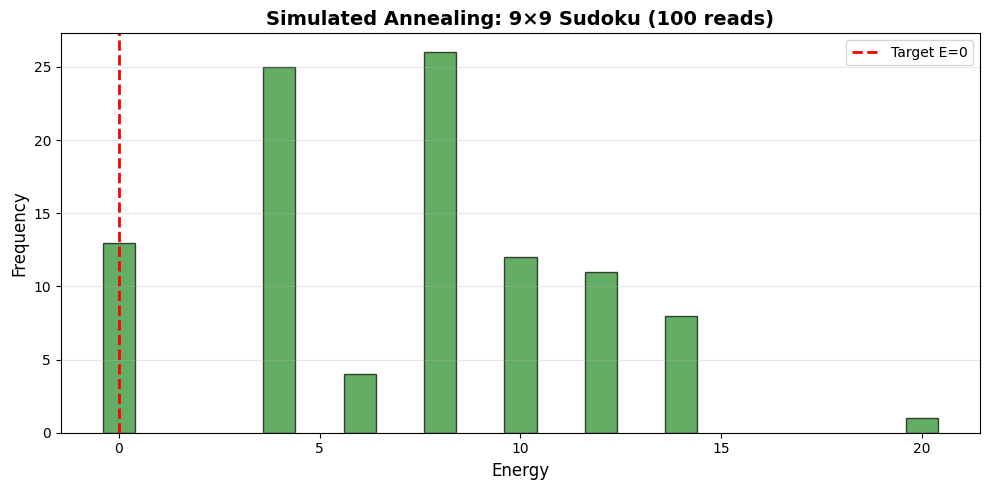


Success rate: 13/100 = 13.0%


In [ ]:
# Visualize energy distribution
plt.figure(figsize=(10, 5))

energy_counts_9x9 = Counter(energies_9x9)
energies_sorted_9x9 = sorted(energy_counts_9x9.keys())
counts_9x9 = [energy_counts_9x9[e] for e in energies_sorted_9x9]

plt.bar(energies_sorted_9x9, counts_9x9, color='forestgreen', alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Target E=0')
plt.xlabel('Energy', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Simulated Annealing: 9×9 Sudoku ({NUM_READS} reads)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Success rate
n_optimal_9x9 = sum(1 for e in energies_9x9 if e == 0)
print(f"\nSuccess rate: {n_optimal_9x9}/{NUM_READS} = {100*n_optimal_9x9/NUM_READS:.1f}%")

In [ ]:
def reduced_solution_to_grid(sample, idx_to_var, givens, N):
    """
    Convert a reduced BQM solution back to a full Sudoku grid.
    """
    grid = np.zeros((N, N), dtype=int)

    # Fill in givens first
    for (i, j), digit in givens.items():
        grid[i, j] = digit

    # Fill in solved cells
    for idx, val in sample.items():
        if val == 1:
            i, j, k = idx_to_var[idx]
            grid[i, j] = k + 1

    return grid

# Convert best solution to grid
grid_9x9 = reduced_solution_to_grid(best_9x9.sample, idx_to_var_9x9, givens_9x9, N_9x9)

print("Best solution found:")
for i, row in enumerate(grid_9x9):
    if i % 3 == 0 and i > 0:
        print("-" * 21)
    row_str = ""
    for j, val in enumerate(row):
        if j % 3 == 0 and j > 0:
            row_str += "| "
        row_str += f"{val if val != 0 else '.'} "
    print(row_str)

Best solution found:
5 3 4 | 6 7 8 | 9 1 2 
6 7 2 | 1 9 5 | 3 4 8 
1 9 8 | 3 4 2 | 5 6 7 
---------------------
8 5 9 | 7 6 1 | 4 2 3 
4 2 6 | 8 5 3 | 7 9 1 
7 1 3 | 9 2 4 | 8 5 6 
---------------------
9 6 1 | 5 3 7 | 2 8 4 
2 8 7 | 4 1 9 | 6 3 5 
3 4 5 | 2 8 6 | 1 7 9 


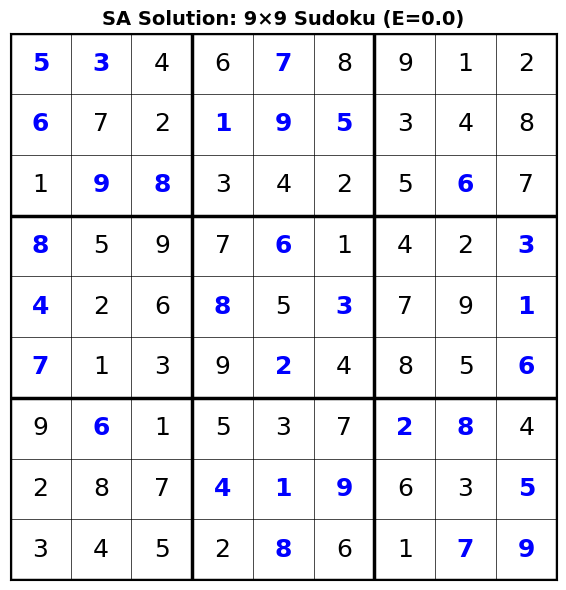


Validation:
  All cells filled: ✓
  Rows valid: ✓
  Columns valid: ✓
  Boxes valid: ✓
  Overall: ✓ VALID SUDOKU


In [ ]:
# Visualize the solution
visualize_sudoku(grid_9x9, N_9x9, box_size_9x9,
                 f"SA Solution: 9×9 Sudoku (E={best_9x9.energy})",
                 givens=givens_9x9)

# Detailed validation
print("\nValidation:")
all_filled = np.all(grid_9x9 > 0)
rows_valid = all(len(set(grid_9x9[i,:])) == N_9x9 for i in range(N_9x9))
cols_valid = all(len(set(grid_9x9[:,j])) == N_9x9 for j in range(N_9x9))

# Check boxes
boxes_valid = True
for box_r in range(3):
    for box_c in range(3):
        box = grid_9x9[box_r*3:(box_r+1)*3, box_c*3:(box_c+1)*3].flatten()
        if len(set(box)) != 9:
            boxes_valid = False

print(f"  All cells filled: {'✓' if all_filled else '✗'}")
print(f"  Rows valid: {'✓' if rows_valid else '✗'}")
print(f"  Columns valid: {'✓' if cols_valid else '✗'}")
print(f"  Boxes valid: {'✓' if boxes_valid else '✗'}")
print(f"  Overall: {'✓ VALID SUDOKU' if all([all_filled, rows_valid, cols_valid, boxes_valid]) else '✗ INVALID'}")

## 8.5 Results Summary

In [ ]:
import pandas as pd

# Create comparison table
results = {
    'Metric': [
        'Grid Size',
        'Given Cells',
        'Variables',
        'Best Energy',
        'Found Optimal (E=0)',
        'Success Rate',
        'Mean Energy',
        'Std Dev'
    ],
    'Blank 4×4': [
        '4×4',
        '0',
        f'{Q_4x4.shape[0]}',
        f'{best_4x4.energy}',
        '✓' if best_4x4.energy == 0 else '✗',
        f'{100*sum(1 for e in energies_4x4 if e==0)/NUM_READS:.1f}%',
        f'{np.mean(energies_4x4):.2f}',
        f'{np.std(energies_4x4):.2f}'
    ],
    '9×9 with Givens': [
        '9×9',
        f'{len(givens_9x9)}',
        f'{Q_9x9.shape[0]}',
        f'{best_9x9.energy}',
        '✓' if best_9x9.energy == 0 else '✗',
        f'{100*sum(1 for e in energies_9x9 if e==0)/NUM_READS:.1f}%',
        f'{np.mean(energies_9x9):.2f}',
        f'{np.std(energies_9x9):.2f}'
    ]
}

df = pd.DataFrame(results)
print("=" * 70)
print("SIMULATED ANNEALING RESULTS SUMMARY")
print("=" * 70)
print(df.to_string(index=False))

SIMULATED ANNEALING RESULTS SUMMARY
             Metric Blank 4×4 9×9 with Givens
          Grid Size       4×4             9×9
        Given Cells         0              30
          Variables        64             459
        Best Energy       0.0             0.0
Found Optimal (E=0)         ✓               ✓
       Success Rate     98.0%           13.0%
        Mean Energy      0.08            7.16
            Std Dev      0.56            4.28


---
# 1. Problem Definition

## The Sudoku Problem

Sudoku is a **constraint satisfaction puzzle** where we fill an N×N grid with digits 1 through N.

### The Four Golden Rules

Every valid Sudoku solution must satisfy:

| Constraint | Description |
|------------|-------------|
| **Rule 1: Cell Uniqueness** | Each cell contains exactly one digit |
| **Rule 2: Row Uniqueness** | Each row contains each digit exactly once |
| **Rule 3: Column Uniqueness** | Each column contains each digit exactly once |
| **Rule 4: Box Uniqueness** | Each box contains each digit exactly once |

### Problem Sizes

**4×4 Sudoku:**
- 4 rows × 4 columns = 16 cells
- 4 boxes of size 2×2
- Digits: 1, 2, 3, 4

**9×9 Sudoku:**
- 9 rows × 9 columns = 81 cells
- 9 boxes of size 3×3  
- Digits: 1, 2, 3, 4, 5, 6, 7, 8, 9

### What are "Givens"?

**Givens** (or clues) are pre-filled cells that:
- Reduce the search space
- Make the puzzle solvable with unique solution
- Will be fixed in our QUBO formulation

---
# 2. Mathematical Formulation

## Binary Variable Encoding

We use **one-hot encoding** to represent which digit goes in each cell:

$$x_{i,j,k} = \begin{cases}
1 & \text{if cell }(i,j)\text{ contains digit }k+1 \\
0 & \text{otherwise}
\end{cases}$$

### Index Notation

- $i \in \{0, 1, ..., N-1\}$ — row index
- $j \in \{0, 1, ..., N-1\}$ — column index
- $k \in \{0, 1, ..., N-1\}$ — digit index (k=0 means digit 1, k=1 means digit 2, etc.)

### Problem Scale

| Sudoku Size | Binary Variables | Typical Givens | Free Variables |
|-------------|------------------|----------------|----------------|
| 4×4 | 64 | 6-8 | ~48-56 |
| 9×9 | 729 | 25-30 | ~675-700 |
| 16×16 | 4,096 | 100-120 | ~3,900-3,950 |

## Energy Function: Converting Constraints to Penalties

The total energy is the sum of all constraint violations:

$$E_{\text{total}} = E_1 + E_2 + E_3 + E_4$$

Each constraint is formulated as a **squared penalty** that equals zero when satisfied:

### E₁: Cell Uniqueness
$$E_1 = \sum_{i,j} \left(\sum_k x_{i,j,k} - 1\right)^2$$

**Interpretation:** For each cell, the sum of all digit indicators should equal 1.

### E₂: Row Uniqueness
$$E_2 = \sum_{i,k} \left(\sum_j x_{i,j,k} - 1\right)^2$$

**Interpretation:** In each row, each digit should appear exactly once.

### E₃: Column Uniqueness
$$E_3 = \sum_{j,k} \left(\sum_i x_{i,j,k} - 1\right)^2$$

**Interpretation:** In each column, each digit should appear exactly once.

### E₄: Box Uniqueness
$$E_4 = \sum_{\text{box},k} \left(\sum_{(i,j) \in \text{box}} x_{i,j,k} - 1\right)^2$$

**Interpretation:** In each box, each digit should appear exactly once.

## 💡 Key Insight

A valid Sudoku solution has $E_{\text{total}} = 0$ (all constraints satisfied). Any invalid configuration has $E_{\text{total}} > 0$.

---
# 3. QUBO Construction

## Setup: Generating Support Files

First, we'll create three Python modules that contain our QUBO construction functions. These have been pre-tested and validated.

### Module 1: QUBO Generation (`qubo_generation.py`)

This module contains the core QUBO construction logic.

In [ ]:
# @title qubo_generation
%%writefile qubo_generation.py

"""
Sudoku QUBO Construction
Builds full QUBO matrices for Sudoku puzzles.
"""

import numpy as np


def build_sudoku_qubo(N, box_size, givens=None, L1=1.0, L2=1.0, L3=1.0, L4=1.0):
    """
    Build complete QUBO matrix for Sudoku.

    Args:
        N: Sudoku size (4 for 4x4, 9 for 9x9)
        box_size: Box size (2 for 4x4, 3 for 9x9)
        givens: Dict {(i,j): digit} for known cells (1-indexed digits)
        L1, L2, L3, L4: Lagrange multipliers

    Returns:
        Q: QUBO matrix (N³ × N³)
        var_to_idx: Dict mapping (i,j,k) → index
        idx_to_var: Dict mapping index → (i,j,k)
        constant_offset: Constant term
    """
    n_vars = N * N * N
    Q = np.zeros((n_vars, n_vars))
    constant_offset = 0.0

    var_to_idx = {}
    idx_to_var = {}
    idx = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                var_to_idx[(i, j, k)] = idx
                idx_to_var[idx] = (i, j, k)
                idx += 1

    def add_quadratic(var1, var2, coeff):
        idx1 = var_to_idx[var1]
        idx2 = var_to_idx[var2]
        if idx1 <= idx2:
            Q[idx1, idx2] += coeff
        else:
            Q[idx2, idx1] += coeff

    def add_linear(var, coeff):
        idx = var_to_idx[var]
        Q[idx, idx] += coeff

    # E1: Each cell has exactly one digit
    for i in range(N):
        for j in range(N):
            if givens and (i, j) in givens:
                continue

            for k in range(N):
                add_linear((i, j, k), -L1)

            for k in range(N):
                for kp in range(k + 1, N):
                    add_quadratic((i, j, k), (i, j, kp), 2 * L1)

            constant_offset += L1

    # E2: Each row has each digit exactly once
    for i in range(N):
        for k in range(N):
            given_count = 0
            free_cells = []

            for j in range(N):
                if givens and (i, j) in givens:
                    if givens[(i, j)] == k + 1:
                        given_count += 1
                else:
                    free_cells.append(j)

            if given_count == 1 and len(free_cells) == 0:
                continue

            target_adjustment = 1 - given_count

            for j in free_cells:
                add_linear((i, j, k), L2 * (1 - 2 * target_adjustment))

            for j_idx, j in enumerate(free_cells):
                for jp in free_cells[j_idx + 1:]:
                    add_quadratic((i, j, k), (i, jp, k), 2 * L2)

            constant_offset += L2 * (target_adjustment ** 2)

    # E3: Each column has each digit exactly once
    for j in range(N):
        for k in range(N):
            given_count = 0
            free_cells = []

            for i in range(N):
                if givens and (i, j) in givens:
                    if givens[(i, j)] == k + 1:
                        given_count += 1
                else:
                    free_cells.append(i)

            if given_count == 1 and len(free_cells) == 0:
                continue

            target_adjustment = 1 - given_count

            for i in free_cells:
                add_linear((i, j, k), L3 * (1 - 2 * target_adjustment))

            for i_idx, i in enumerate(free_cells):
                for ip in free_cells[i_idx + 1:]:
                    add_quadratic((i, j, k), (ip, j, k), 2 * L3)

            constant_offset += L3 * (target_adjustment ** 2)

    # E4: Each box has each digit exactly once
    boxes_per_side = N // box_size

    for box_row in range(boxes_per_side):
        for box_col in range(boxes_per_side):
            for k in range(N):
                given_count = 0
                free_cells = []

                for i in range(box_row * box_size, (box_row + 1) * box_size):
                    for j in range(box_col * box_size, (box_col + 1) * box_size):
                        if givens and (i, j) in givens:
                            if givens[(i, j)] == k + 1:
                                given_count += 1
                        else:
                            free_cells.append((i, j))

                if given_count == 1 and len(free_cells) == 0:
                    continue

                target_adjustment = 1 - given_count

                for (i, j) in free_cells:
                    add_linear((i, j, k), L4 * (1 - 2 * target_adjustment))

                for cell_idx, (i, j) in enumerate(free_cells):
                    for (ip, jp) in free_cells[cell_idx + 1:]:
                        add_quadratic((i, j, k), (ip, jp, k), 2 * L4)

                constant_offset += L4 * (target_adjustment ** 2)

    return Q, var_to_idx, idx_to_var, constant_offset


def evaluate_qubo(Q, bitstring, constant_offset=0):
    """
    Evaluate QUBO energy: E = x^T Q x + constant

    Args:
        Q: QUBO matrix
        bitstring: Binary string (spaces allowed)
        constant_offset: Constant term

    Returns:
        Energy value
    """
    x = np.array([int(b) for b in bitstring.replace(' ', '')])

    energy = constant_offset

    for i in range(len(x)):
        energy += Q[i, i] * x[i]

    for i in range(len(x)):
        for j in range(i + 1, len(x)):
            energy += 2 * Q[i, j] * x[i] * x[j]

    return energy


def build_E1(N, givens=None, L1=1.0):
    """Build E1: Each cell has exactly one digit"""
    n_vars = N * N * N
    Q = np.zeros((n_vars, n_vars))
    constant = 0.0
    poly_terms = []

    var_to_idx = {}
    idx = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                var_to_idx[(i, j, k)] = idx
                idx += 1

    for i in range(N):
        for j in range(N):
            if givens and (i, j) in givens:
                continue

            for k in range(N):
                idx = var_to_idx[(i, j, k)]
                Q[idx, idx] += -L1
                poly_terms.append(f"-{L1:.0f}*x_{i}{j}{k}")

            for k in range(N):
                for kp in range(k + 1, N):
                    idx1 = var_to_idx[(i, j, k)]
                    idx2 = var_to_idx[(i, j, kp)]
                    Q[idx1, idx2] += 2 * L1
                    poly_terms.append(f"{2*L1:.0f}*x_{i}{j}{k}*x_{i}{j}{kp}")

            constant += L1

    return Q, poly_terms, constant


def build_E2(N, givens=None, L2=1.0):
    """Build E2: Each row has each digit exactly once"""
    n_vars = N * N * N
    Q = np.zeros((n_vars, n_vars))
    constant = 0.0
    poly_terms = []

    var_to_idx = {}
    idx = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                var_to_idx[(i, j, k)] = idx
                idx += 1

    for i in range(N):
        for k in range(N):
            given_count = 0
            free_cells = []

            for j in range(N):
                if givens and (i, j) in givens:
                    if givens[(i, j)] == k + 1:
                        given_count += 1
                else:
                    free_cells.append(j)

            if given_count == 1 and len(free_cells) == 0:
                continue

            target_adjustment = 1 - given_count

            for j in free_cells:
                idx = var_to_idx[(i, j, k)]
                coeff = L2 * (1 - 2 * target_adjustment)
                Q[idx, idx] += coeff
                if coeff != 0:
                    poly_terms.append(f"{coeff:.1f}*x_{i}{j}{k}")

            for j_idx, j in enumerate(free_cells):
                for jp in free_cells[j_idx + 1:]:
                    idx1 = var_to_idx[(i, j, k)]
                    idx2 = var_to_idx[(i, jp, k)]
                    Q[idx1, idx2] += 2 * L2
                    poly_terms.append(f"{2*L2:.0f}*x_{i}{j}{k}*x_{i}{jp}{k}")

            constant += L2 * (target_adjustment ** 2)

    return Q, poly_terms, constant


def build_E3(N, givens=None, L3=1.0):
    """Build E3: Each column has each digit exactly once"""
    n_vars = N * N * N
    Q = np.zeros((n_vars, n_vars))
    constant = 0.0
    poly_terms = []

    var_to_idx = {}
    idx = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                var_to_idx[(i, j, k)] = idx
                idx += 1

    for j in range(N):
        for k in range(N):
            given_count = 0
            free_cells = []

            for i in range(N):
                if givens and (i, j) in givens:
                    if givens[(i, j)] == k + 1:
                        given_count += 1
                else:
                    free_cells.append(i)

            if given_count == 1 and len(free_cells) == 0:
                continue

            target_adjustment = 1 - given_count

            for i in free_cells:
                idx = var_to_idx[(i, j, k)]
                coeff = L3 * (1 - 2 * target_adjustment)
                Q[idx, idx] += coeff
                if coeff != 0:
                    poly_terms.append(f"{coeff:.1f}*x_{i}{j}{k}")

            for i_idx, i in enumerate(free_cells):
                for ip in free_cells[i_idx + 1:]:
                    idx1 = var_to_idx[(i, j, k)]
                    idx2 = var_to_idx[(ip, j, k)]
                    Q[idx1, idx2] += 2 * L3
                    poly_terms.append(f"{2*L3:.0f}*x_{i}{j}{k}*x_{ip}{j}{k}")

            constant += L3 * (target_adjustment ** 2)

    return Q, poly_terms, constant


def build_E4(N, box_size, givens=None, L4=1.0):
    """Build E4: Each box has each digit exactly once"""
    n_vars = N * N * N
    Q = np.zeros((n_vars, n_vars))
    constant = 0.0
    poly_terms = []

    var_to_idx = {}
    idx = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                var_to_idx[(i, j, k)] = idx
                idx += 1

    boxes_per_side = N // box_size

    for box_row in range(boxes_per_side):
        for box_col in range(boxes_per_side):
            for k in range(N):
                given_count = 0
                free_cells = []

                for i in range(box_row * box_size, (box_row + 1) * box_size):
                    for j in range(box_col * box_size, (box_col + 1) * box_size):
                        if givens and (i, j) in givens:
                            if givens[(i, j)] == k + 1:
                                given_count += 1
                        else:
                            free_cells.append((i, j))

                if given_count == 1 and len(free_cells) == 0:
                    continue

                target_adjustment = 1 - given_count

                for (i, j) in free_cells:
                    idx = var_to_idx[(i, j, k)]
                    coeff = L4 * (1 - 2 * target_adjustment)
                    Q[idx, idx] += coeff
                    if coeff != 0:
                        poly_terms.append(f"{coeff:.1f}*x_{i}{j}{k}")

                for cell_idx, (i, j) in enumerate(free_cells):
                    for (ip, jp) in free_cells[cell_idx + 1:]:
                        idx1 = var_to_idx[(i, j, k)]
                        idx2 = var_to_idx[(ip, jp, k)]
                        Q[idx1, idx2] += 2 * L4
                        poly_terms.append(f"{2*L4:.0f}*x_{i}{j}{k}*x_{ip}{jp}{k}")

                constant += L4 * (target_adjustment ** 2)

    return Q, poly_terms, constant


def print_E1_details(N, givens=None):
    """Print E1 construction details"""
    Q, _, const = build_E1(N, givens)
    print("E1: Each cell has exactly one digit")
    print(f"Constant: {const}")
    return Q, None, const


def print_E2_details(N, givens=None):
    """Print E2 construction details"""
    Q, _, const = build_E2(N, givens)
    print("E2: Each row has each digit exactly once")
    print(f"Constant: {const}")
    return Q, None, const


def print_E3_details(N, givens=None):
    """Print E3 construction details"""
    Q, _, const = build_E3(N, givens)
    print("E3: Each column has each digit exactly once")
    print(f"Constant: {const}")
    return Q, None, const


def print_E4_details(N, box_size, givens=None):
    """Print E4 construction details"""
    Q, _, const = build_E4(N, box_size, givens)
    print("E4: Each box has each digit exactly once")
    print(f"Constant: {const}")
    return Q, None, const

def print_qubo_stats(Q, N, givens=None):
    """Print statistics about the QUBO matrix"""
    n_vars = N * N * N

    print(f"\nQUBO Matrix Statistics:")
    print(f"  Size: {n_vars} × {n_vars}")
    print(f"  Total possible entries: {n_vars * n_vars:,}")

    # Count non-zero entries
    nonzero_diag = np.count_nonzero(np.diag(Q))
    nonzero_upper = np.count_nonzero(np.triu(Q, k=1))
    total_nonzero = nonzero_diag + nonzero_upper

    print(f"  Non-zero diagonal entries: {nonzero_diag}")
    print(f"  Non-zero off-diagonal entries: {nonzero_upper}")
    print(f"  Total non-zero entries: {total_nonzero}")
    print(f"  Sparsity: {100 * (1 - total_nonzero / (n_vars * n_vars)):.2f}%")

    if givens:
        print(f"\nGiven cells: {len(givens)}")
        print(f"Free variables: {n_vars - len(givens) * N}")

Writing qubo_generation.py


### Module 2: Component Builders (`calc_mods.py`)

This module contains functions to build individual constraint components (E1, E2, E3, E4).

In [ ]:
# @title calc_mods
%%writefile calc_mods.py

import numpy as np

# === Lagrange Penalties (Globals) ===
L1, L2, L3, L4 = 1.0, 1.0, 1.0, 1.0  # All set to 1.0

def compute_E1(x, N):
    """
    Ensures each cell has exactly one digit
    E1 = Σ(i,j) [Σk x[i,j,k] - 1]²
    """
    E1 = 0
    for i in range(N):
        for j in range(N):
            cell_sum = np.sum(x[i, j, :])
            E1 += (cell_sum - 1) ** 2
    return int(E1)

def compute_E2(x, N):
    """
    Ensures each row has each digit exactly once
    E2 = Σ(i,k) [Σj x[i,j,k] - 1]²
    """
    E2 = 0
    for i in range(N):
        for k in range(N):
            row_digit_sum = np.sum(x[i, :, k])
            E2 += (row_digit_sum - 1) ** 2
    return int(E2)

def compute_E3(x, N):
    """
    Ensures each column has each digit exactly once
    E3 = Σ(j,k) [Σi x[i,j,k] - 1]²
    """
    E3 = 0
    for j in range(N):
        for k in range(N):
            col_digit_sum = np.sum(x[:, j, k])
            E3 += (col_digit_sum - 1) ** 2
    return int(E3)

def compute_E4(x, N, box_size):
    """
    Ensures each box has each digit exactly once
    E4 = Σ(box,k) [Σ(i,j in box) x[i,j,k] - 1]²

    For N=4, box_size=2, we have 4 boxes (2x2 grid of boxes)
    For N=9, box_size=3, we have 9 boxes (3x3 grid of boxes)
    """
    E4 = 0
    boxes_per_side = N // box_size

    for box_row in range(boxes_per_side):
        for box_col in range(boxes_per_side):
            for k in range(N):
                box_digit_sum = 0
                for i in range(box_row * box_size, (box_row + 1) * box_size):
                    for j in range(box_col * box_size, (box_col + 1) * box_size):
                        box_digit_sum += x[i, j, k]
                E4 += (box_digit_sum - 1) ** 2

    return int(E4)

def bitstring_to_tensor(bitstring, N):
    """
    Convert bitstring to 3D tensor x[i,j,k]
    bitstring has length N³, ordered as (i, j, k)
    """
    x = np.zeros((N, N, N), dtype=int)
    idx = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                x[i, j, k] = int(bitstring[idx])
                idx += 1
    return x

def tensor_to_grid(x, N):
    """
    Convert 3D tensor x[i,j,k] to 2D Sudoku grid
    Returns None if a cell doesn't have exactly one digit
    """
    grid = np.zeros((N, N), dtype=int)
    for i in range(N):
        for j in range(N):
            digits = np.where(x[i, j, :] == 1)[0]
            if len(digits) == 1:
                grid[i, j] = digits[0] + 1  # Convert from 0-indexed to 1-indexed
            else:
                return None  # Invalid: cell has 0 or multiple digits
    return grid

def total_energy(bitstring, N, box_size, L1=1.0, L2=1.0, L3=1.0, L4=1.0, verbose=False):
    """
    Compute total QUBO energy for Sudoku with optional debug output

    Args:
        bitstring: Binary string of length N³
        N: Size of Sudoku (4 for 4x4, 9 for 9x9)
        box_size: Size of each box (2 for 4x4, 3 for 9x9)
        L1, L2, L3, L4: Lagrange multipliers
        verbose: Whether to print detailed output
    """
    x = bitstring_to_tensor(bitstring, N)

    if verbose:
        print("\nTensor x[i,j,k] shape:", x.shape)
        grid = tensor_to_grid(x, N)
        if grid is not None:
            print("\nSudoku grid:")
            print_grid(grid, N, box_size)
        else:
            print("\nInvalid grid (cells with 0 or multiple digits)")
        print("\nComputing energy components:")

    E_1 = compute_E1(x, N)
    E_2 = compute_E2(x, N)
    E_3 = compute_E3(x, N)
    E_4 = compute_E4(x, N, box_size)

    total = L1*E_1 + L2*E_2 + L3*E_3 + L4*E_4

    if verbose:
        print(f"  E1 (cell constraint)   = {E_1}")
        print(f"  E2 (row constraint)    = {E_2}")
        print(f"  E3 (column constraint) = {E_3}")
        print(f"  E4 (box constraint)    = {E_4}")
        print(f"\nTotal energy calculation:")
        print(f"  E = {L1}×{E_1} + {L2}×{E_2} + {L3}×{E_3} + {L4}×{E_4}")
        print(f"  E = {L1*E_1} + {L2*E_2} + {L3*E_3} + {L4*E_4}")
        print(f"  E = {total}")

    return total, (E_1, E_2, E_3, E_4)

def is_valid_solution(breakdown):
    """Check if configuration satisfies all constraints"""
    E1, E2, E3, E4 = breakdown
    return E1 == 0 and E2 == 0 and E3 == 0 and E4 == 0

def print_grid(grid, N, box_size):
    """Pretty print Sudoku grid with box separators"""
    for i in range(N):
        if i > 0 and i % box_size == 0:
            print("-" * (2*N + box_size - 1))
        row_str = ""
        for j in range(N):
            if j > 0 and j % box_size == 0:
                row_str += "| "
            row_str += str(grid[i, j]) + " "
        print(row_str.rstrip())

def grid_to_bitstring(grid, N):
    """
    Convert 2D Sudoku grid to bitstring
    grid[i,j] should contain digit 1 to N
    """
    bitstring = ""
    for i in range(N):
        for j in range(N):
            for k in range(N):
                # k is 0-indexed, grid values are 1-indexed
                if grid[i, j] == k + 1:
                    bitstring += "1"
                else:
                    bitstring += "0"
    return bitstring

if __name__ == "__main__":
    N = 4  # 4x4 Sudoku
    box_size = 2

    # Example 1: Valid complete solution
    print("="*60)
    print("=== Example 1: Valid complete solution ===")
    print("="*60)

    # Grid representation:
    # 2 1 | 4 3
    # 4 3 | 2 1
    # -----+----
    # 1 2 | 3 4
    # 3 4 | 1 2

    bitstring1 = (
        "0100" + "1000" + "0001" + "0010" +  # Row 0: 2,1,4,3
        "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
        "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
        "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
    )
    total_E, breakdown = total_energy(bitstring1, N, box_size, L1, L2, L3, L4, verbose=True)
    print(f"\nTotal Energy: {total_E}")
    print(f"Energy Breakdown: E1={breakdown[0]}, E2={breakdown[1]}, E3={breakdown[2]}, E4={breakdown[3]}")
    print(f"Valid solution: {is_valid_solution(breakdown)}")

    # Example 2: Column and box violations (no row violation)
    print("\n" + "="*60)
    print("=== Example 2: Column and box violations ===")
    print("="*60)

    # Grid representation:
    # 2 1 | 4 3
    # 2 3 | 4 1    <- Swapped (1,0) and (1,2): 4->2 and 2->4
    # -----+----
    # 1 2 | 3 4
    # 3 4 | 1 2

    bitstring2 = (
        "0100" + "1000" + "0001" + "0010" +  # Row 0: 2,1,4,3
        "0100" + "0010" + "0001" + "1000" +  # Row 1: 2,3,4,1 (violations!)
        "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
        "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
    )
    total_E, breakdown = total_energy(bitstring2, N, box_size, L1, L2, L3, L4, verbose=True)
    print(f"\nTotal Energy: {total_E}")
    print(f"Energy Breakdown: E1={breakdown[0]}, E2={breakdown[1]}, E3={breakdown[2]}, E4={breakdown[3]}")
    print(f"Valid solution: {is_valid_solution(breakdown)}")
    print("\nNote: Row 1 has all digits 1-4 once (no row violation)")
    print("      Column 0 has two 2's, Column 2 has two 4's")
    print("      Box 0 (top-left) has two 2's, Box 1 (top-right) has two 4's")

    # Example 3: Multiple violations
    print("\n" + "="*60)
    print("=== Example 3: Multiple violations ===")
    print("="*60)

    # Grid representation:
    # 2 2 | 4 3    <- Row 0 has two 2's, missing 1
    # 4 3 | 2 1
    # -----+----
    # 1 2 | 3 4
    # 3 4 | 1 2

    bitstring3 = (
        "0100" + "0100" + "0001" + "0010" +  # Row 0: 2,2,4,3 (violations!)
        "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
        "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
        "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
    )
    total_E, breakdown = total_energy(bitstring3, N, box_size, L1, L2, L3, L4, verbose=True)
    print(f"\nTotal Energy: {total_E}")
    print(f"Energy Breakdown: E1={breakdown[0]}, E2={breakdown[1]}, E3={breakdown[2]}, E4={breakdown[3]}")
    print(f"Valid solution: {is_valid_solution(breakdown)}")
    print("\nNote: Row 0 has two 2's (no 1)")
    print("      Column 1 has two 2's (no 1)")
    print("      Box 0 (top-left) has two 2's (no 1)")

    # Example 4: E1 violation - cell with multiple digits
    print("\n" + "="*60)
    print("=== Example 4: E1 violation (raw bitstring input) ===")
    print("="*60)

    # This example shows why we need raw bitstring input from QPU:
    # Some cells can have 0 digits or multiple digits assigned - impossible
    # to represent as a simple grid, but possible as QPU output.
    #
    # Grid representation (invalid):
    # {1,2} 3 | 4 _    <- Cell (0,0) has TWO digits, cell (0,3) has NONE
    # 4     3 | 2 1
    # ---------+------
    # 1     2 | 3 4
    # 3     4 | 1 2

    bitstring4 = (
        "1100" + "0010" + "0001" + "0000" +  # Row 0: {1,2},3,4,_ (E1 violations!)
        "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
        "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
        "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
    )

    total_E, breakdown = total_energy(bitstring4, N, box_size, L1, L2, L3, L4, verbose=True)
    print(f"\nTotal Energy: {total_E}")
    print(f"Energy Breakdown: E1={breakdown[0]}, E2={breakdown[1]}, E3={breakdown[2]}, E4={breakdown[3]}")
    print(f"Valid solution: {is_valid_solution(breakdown)}")
    print("\nNote: Cell (0,0) has 2 digits assigned → E1 += (2-1)² = 1")
    print("      Cell (0,3) has 0 digits assigned → E1 += (0-1)² = 1")
    print("      Total E1 = 2")



Writing calc_mods.py


### Module 3: Matrix Reduction (`matrix_reduction.py`)

This module implements variable elimination for given cells.

In [ ]:
# @title matrix_reduction
%%writefile matrix_reduction.py

"""
Sudoku QUBO Matrix Reduction
Variable elimination for puzzles with given cells.
"""

import numpy as np
from qubo_generation import build_sudoku_qubo


def build_reduced_qubo(N, box_size, givens, L1=1.0, L2=1.0, L3=1.0, L4=1.0):
    """
    Build reduced QUBO by extracting submatrix from full QUBO.

    Args:
        N: Sudoku size
        box_size: Box size
        givens: Dict {(i,j): digit} (REQUIRED)
        L1, L2, L3, L4: Lagrange multipliers

    Returns:
        Q_reduced: Reduced QUBO matrix
        var_to_idx: Mapping (i,j,k) → reduced index
        idx_to_var: Mapping reduced index → (i,j,k)
        offset: Constant offset
        info: Statistics dictionary
    """
    if givens is None:
        raise ValueError("givens required")

    Q_full, var_to_idx_full, idx_to_var_full, offset = build_sudoku_qubo(
        N, box_size, givens, L1, L2, L3, L4
    )

    free_vars = []
    for i in range(N):
        for j in range(N):
            if (i, j) not in givens:
                for k in range(N):
                    free_vars.append((i, j, k))

    n_free = len(free_vars)

    var_to_idx_reduced = {}
    idx_to_var_reduced = {}
    old_to_new = {}

    for new_idx, var in enumerate(free_vars):
        var_to_idx_reduced[var] = new_idx
        idx_to_var_reduced[new_idx] = var
        old_idx = var_to_idx_full[var]
        old_to_new[old_idx] = new_idx

    Q_reduced = np.zeros((n_free, n_free))

    for var_i in free_vars:
        old_i = var_to_idx_full[var_i]
        new_i = old_to_new[old_i]

        for var_j in free_vars:
            old_j = var_to_idx_full[var_j]
            new_j = old_to_new[old_j]

            Q_reduced[new_i, new_j] = Q_full[old_i, old_j]

    info = {
        'n_total_vars': N * N * N,
        'n_free_vars': n_free,
        'n_eliminated_vars': N * N * N - n_free,
        'n_given_cells': len(givens),
        'reduction_pct': 100 * (1 - n_free / (N * N * N)),
        'matrix_size_reduction_pct': 100 * (1 - (n_free ** 2) / ((N * N * N) ** 2))
    }

    return Q_reduced, var_to_idx_reduced, idx_to_var_reduced, offset, info


def build_reduced_qubo_direct(N, box_size, givens, L1=1.0, L2=1.0, L3=1.0, L4=1.0):
    """
    Build reduced QUBO directly (more efficient).

    Args:
        N: Sudoku size
        box_size: Box size
        givens: Dict {(i,j): digit} (REQUIRED)
        L1, L2, L3, L4: Lagrange multipliers

    Returns:
        Q: Reduced QUBO matrix
        var_to_idx: Mapping (i,j,k) → index
        idx_to_var: Mapping index → (i,j,k)
        offset: Constant offset
        info: Statistics dictionary
    """
    if givens is None:
        raise ValueError("givens required")

    free_vars = []
    for i in range(N):
        for j in range(N):
            if (i, j) not in givens:
                for k in range(N):
                    free_vars.append((i, j, k))

    n_free = len(free_vars)

    var_to_idx = {}
    idx_to_var = {}

    for idx, var in enumerate(free_vars):
        var_to_idx[var] = idx
        idx_to_var[idx] = var

    Q = np.zeros((n_free, n_free))
    constant_offset = 0.0

    def add_quadratic(var1, var2, coeff):
        if var1 in var_to_idx and var2 in var_to_idx:
            idx1 = var_to_idx[var1]
            idx2 = var_to_idx[var2]
            if idx1 <= idx2:
                Q[idx1, idx2] += coeff
            else:
                Q[idx2, idx1] += coeff

    def add_linear(var, coeff):
        if var in var_to_idx:
            idx = var_to_idx[var]
            Q[idx, idx] += coeff

    # E1: Each cell has exactly one digit
    for i in range(N):
        for j in range(N):
            if (i, j) in givens:
                continue

            for k in range(N):
                add_linear((i, j, k), -L1)

            for k in range(N):
                for kp in range(k + 1, N):
                    add_quadratic((i, j, k), (i, j, kp), 2 * L1)

            constant_offset += L1

    # E2: Each row has each digit exactly once
    for i in range(N):
        for k in range(N):
            given_count = 0
            free_cells = []

            for j in range(N):
                if (i, j) in givens:
                    if givens[(i, j)] == k + 1:
                        given_count += 1
                else:
                    free_cells.append(j)

            if given_count == 1 and len(free_cells) == 0:
                continue

            target_adjustment = 1 - given_count

            for j in free_cells:
                add_linear((i, j, k), L2 * (1 - 2 * target_adjustment))

            for j_idx, j in enumerate(free_cells):
                for jp in free_cells[j_idx + 1:]:
                    add_quadratic((i, j, k), (i, jp, k), 2 * L2)

            constant_offset += L2 * (target_adjustment ** 2)

    # E3: Each column has each digit exactly once
    for j in range(N):
        for k in range(N):
            given_count = 0
            free_cells = []

            for i in range(N):
                if (i, j) in givens:
                    if givens[(i, j)] == k + 1:
                        given_count += 1
                else:
                    free_cells.append(i)

            if given_count == 1 and len(free_cells) == 0:
                continue

            target_adjustment = 1 - given_count

            for i in free_cells:
                add_linear((i, j, k), L3 * (1 - 2 * target_adjustment))

            for i_idx, i in enumerate(free_cells):
                for ip in free_cells[i_idx + 1:]:
                    add_quadratic((i, j, k), (ip, j, k), 2 * L3)

            constant_offset += L3 * (target_adjustment ** 2)

    # E4: Each box has each digit exactly once
    boxes_per_side = N // box_size

    for box_row in range(boxes_per_side):
        for box_col in range(boxes_per_side):
            for k in range(N):
                given_count = 0
                free_cells = []

                for i in range(box_row * box_size, (box_row + 1) * box_size):
                    for j in range(box_col * box_size, (box_col + 1) * box_size):
                        if (i, j) in givens:
                            if givens[(i, j)] == k + 1:
                                given_count += 1
                        else:
                            free_cells.append((i, j))

                if given_count == 1 and len(free_cells) == 0:
                    continue

                target_adjustment = 1 - given_count

                for (i, j) in free_cells:
                    add_linear((i, j, k), L4 * (1 - 2 * target_adjustment))

                for cell_idx, (i, j) in enumerate(free_cells):
                    for (ip, jp) in free_cells[cell_idx + 1:]:
                        add_quadratic((i, j, k), (ip, jp, k), 2 * L4)

                constant_offset += L4 * (target_adjustment ** 2)

    info = {
        'n_total_vars': N * N * N,
        'n_free_vars': n_free,
        'n_eliminated_vars': N * N * N - n_free,
        'n_given_cells': len(givens),
        'reduction_pct': 100 * (1 - n_free / (N * N * N)),
        'matrix_size_reduction_pct': 100 * (1 - (n_free ** 2) / ((N * N * N) ** 2))
    }

    return Q, var_to_idx, idx_to_var, constant_offset, info


def evaluate_reduced_qubo(Q_reduced, bitstring_full, var_to_idx, idx_to_var, constant_offset=0):
    """
    Evaluate reduced QUBO energy given full bitstring.

    Args:
        Q_reduced: Reduced QUBO matrix
        bitstring_full: Full bitstring (includes given cells)
        var_to_idx: Mapping (i,j,k) → index
        idx_to_var: Mapping index → (i,j,k)
        constant_offset: Constant term

    Returns:
        Energy value
    """
    n_free = len(idx_to_var)
    x_reduced = np.zeros(n_free, dtype=int)

    bitstring_clean = bitstring_full.replace(' ', '')
    N = int(round(len(bitstring_clean) ** (1/3)))

    idx_full = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                var = (i, j, k)
                if idx_full < len(bitstring_clean):
                    bit_val = int(bitstring_clean[idx_full])

                    if var in var_to_idx:
                        reduced_idx = var_to_idx[var]
                        x_reduced[reduced_idx] = bit_val

                idx_full += 1

    energy = 0.0

    for i in range(n_free):
        energy += Q_reduced[i, i] * x_reduced[i]

    for i in range(n_free):
        for j in range(i + 1, n_free):
            energy += 2 * Q_reduced[i, j] * x_reduced[i] * x_reduced[j]

    energy += constant_offset

    return energy


def reconstruct_full_solution(reduced_bitstring, var_to_idx, idx_to_var, givens, N):
    """
    Convert reduced solution to full solution.

    Args:
        reduced_bitstring: Reduced bitstring (free variables only)
        var_to_idx: Mapping (i,j,k) → index
        idx_to_var: Mapping index → (i,j,k)
        givens: Dict {(i,j): digit}
        N: Sudoku size

    Returns:
        Full bitstring
    """
    full_solution = ['0'] * (N * N * N)

    for reduced_idx, bit in enumerate(reduced_bitstring):
        i, j, k = idx_to_var[reduced_idx]
        full_idx = i * (N * N) + j * N + k
        full_solution[full_idx] = bit

    for (i, j), digit in givens.items():
        for k in range(N):
            full_idx = i * (N * N) + j * N + k
            if k == (digit - 1):
                full_solution[full_idx] = '1'
            else:
                full_solution[full_idx] = '0'

    return ''.join(full_solution)


def print_reduction_stats(info, N, box_size):
    """Print variable elimination statistics"""
    print("\nVariable Elimination Statistics:")
    print(f"  Total variables: {info['n_total_vars']}")
    print(f"  Given cells: {info['n_given_cells']}")
    print(f"  Eliminated variables: {info['n_eliminated_vars']}")
    print(f"  Free variables: {info['n_free_vars']}")
    print(f"  Variable reduction: {info['reduction_pct']:.1f}%")
    print(f"  Matrix size reduction: {info['matrix_size_reduction_pct']:.1f}%")

    full_size = info['n_total_vars']
    reduced_size = info['n_free_vars']

    print(f"\nMatrix Dimensions:")
    print(f"  Full QUBO: {full_size}×{full_size} = {full_size**2:,} entries")
    print(f"  Reduced QUBO: {reduced_size}×{reduced_size} = {reduced_size**2:,} entries")
    print(f"  Savings: {full_size**2 - reduced_size**2:,} entries")

Writing matrix_reduction.py


## Importing Our Functions

Now we import the modules and visualization tools.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from calc_mods import total_energy, is_valid_solution, tensor_to_grid, print_grid

# Import our tested QUBO construction functions
from qubo_generation import (
    build_E1, build_E2, build_E3, build_E4,
    build_sudoku_qubo, evaluate_qubo,
    print_E1_details, print_E2_details, print_E3_details, print_E4_details, print_qubo_stats
)

# Import matrix reduction functions
from matrix_reduction import (
    build_reduced_qubo,
    build_reduced_qubo_direct,
    evaluate_reduced_qubo,
    reconstruct_full_solution,
    print_reduction_stats
)

## Visualization Functions

We'll create helper functions to visualize QUBO matrices and understand their structure.

In [ ]:
def visualize_qubo_matrix(Q, title="QUBO Matrix", show_values=False):
    """
    Visualize a QUBO matrix as a heatmap.

    Args:
        Q: QUBO matrix
        title: Title for the plot
        show_values: Whether to show numerical values in cells
    """
    plt.figure(figsize=(10, 8))

    if show_values and Q.shape[0] <= 20:
        sns.heatmap(Q, annot=True, fmt='.1f', cmap='RdBu_r', center=0,
                   square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    else:
        sns.heatmap(Q, cmap='RdBu_r', center=0,
                   square=True, cbar_kws={"shrink": 0.8})

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Variable Index', fontsize=11)
    plt.ylabel('Variable Index', fontsize=11)
    plt.tight_layout()
    plt.show()


def print_polynomial(poly_terms, constant, title, max_terms=10):
    """
    Print a polynomial in readable format.

    Args:
        poly_terms: List of polynomial term strings
        constant: Constant term
        title: Title for the polynomial
        max_terms: Maximum number of terms to display
    """
    print(f"\n{title}")
    print("=" * 70)
    print(f"Number of terms: {len(poly_terms)}")
    print(f"Constant: {constant}")

    if len(poly_terms) > 0:
        print(f"\nFirst {min(max_terms, len(poly_terms))} terms:")
        for i, term in enumerate(poly_terms[:max_terms]):
            print(f"  {term}")

        if len(poly_terms) > max_terms:
            print(f"  ... ({len(poly_terms) - max_terms} more terms)")


def visualize_sudoku(grid, N, box_size, title="Sudoku Grid"):
    """
    Visualize a Sudoku grid.

    Args:
        grid: N×N numpy array with digit values
        N: Size of Sudoku
        box_size: Size of each box
        title: Title for the plot
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    # Create colored grid
    ax.imshow(np.ones((N, N)), cmap='Greys', alpha=0.1)

    # Draw grid lines
    for i in range(N + 1):
        linewidth = 2 if i % box_size == 0 else 0.5
        ax.axhline(i - 0.5, color='black', linewidth=linewidth)
        ax.axvline(i - 0.5, color='black', linewidth=linewidth)

    # Add numbers
    for i in range(N):
        for j in range(N):
            if grid[i, j] != 0:
                ax.text(j, i, str(grid[i, j]),
                       ha='center', va='center', fontsize=16, fontweight='bold')

    ax.set_xlim(-0.5, N - 0.5)
    ax.set_ylim(N - 0.5, -0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

---
# 4. Worked Example: 4×4 Sudoku

Let's work through a complete example to understand how QUBO formulation works.

## The Puzzle

We'll solve this partially-filled 4×4 Sudoku:

```
Given:              Solution:
2 _ | 4 _           2 1 | 4 3
_ 3 | _ 1           4 3 | 2 1
-----+----          -----+----
1 _ | 3 _           1 2 | 3 4
_ 4 | _ 2           3 4 | 1 2
```

### Key Statistics

- **Grid size:** 4×4 = 16 cells
- **Total variables without givens:** 4 × 4 × 4 = 64
- **Given cells (clues):** 8  
- **Free cells:** 8
- **Effective variables:** 8 cells × 4 digits = 32 binary variables

## Setting Up the Puzzle

In [ ]:
# Define the 4×4 Sudoku puzzle
N = 4
box_size = 2

# Given cells (using 0-indexed positions, 1-indexed digits)
givens = {
    (0, 0): 2,           (0, 2): 4,
              (1, 1): 3,           (1, 3): 1,
    (2, 0): 1,           (2, 2): 3,
              (3, 1): 4,           (3, 3): 2
}

print(f"Sudoku size: {N}×{N}")
print(f"Box size: {box_size}×{box_size}")
print(f"Number of givens: {len(givens)}")
print(f"Number of variables: {N * N * N} (before eliminating givens)")
print(f"Free variables: {(N*N - len(givens)) * N}")

# Visualize the puzzle
print("\nGiven cells:")
for i in range(N):
    row_str = ""
    for j in range(N):
        if j > 0 and j % box_size == 0:
            row_str += "| "
        if (i, j) in givens:
            row_str += str(givens[(i, j)]) + " "
        else:
            row_str += "_ "
    print(row_str.rstrip())
    if i == box_size - 1:
        print("-" * (2*N + box_size - 1))

Sudoku size: 4×4
Box size: 2×2
Number of givens: 8
Number of variables: 64 (before eliminating givens)
Free variables: 32

Given cells:
2 _ | 4 _
_ 3 | _ 1
---------
1 _ | 3 _
_ 4 | _ 2


---
# 5. Component Analysis & Visualization

Now let's build each QUBO component separately and visualize how they contribute to the total energy function.

## Component 1: Cell Uniqueness (E₁)

This constraint ensures that each cell contains **exactly one digit**.

### Mathematical Form
$$E_1 = \sum_{i,j} \left(\sum_k x_{i,j,k} - 1\right)^2$$

### When Expanded to QUBO Form
$$E_1 = \sum_{i,j} \left[-\sum_k x_{i,j,k} + 2\sum_{k<k'} x_{i,j,k} \cdot x_{i,j,k'} + 1\right]$$

The linear terms ($-x_{i,j,k}$) encourage setting variables to 1, while the quadratic terms ($2x_{i,j,k} \cdot x_{i,j,k'}$) penalize setting multiple variables to 1 in the same cell.

### Building E₁

In [ ]:
# Build E1 (each cell has exactly one digit)
Q_E1, poly_E1, const_E1 = build_E1(N, givens)

print("=" * 70)
print("E1: Each Cell Has Exactly One Digit")
print("=" * 70)
print(f"Number of terms: {len(poly_E1)}")
print(f"Constant: {const_E1}")
print(f"\nNote: {len(givens)} cells are given, so they don't contribute variables")

E1: Each Cell Has Exactly One Digit
Number of terms: 80
Constant: 8.0

Note: 8 cells are given, so they don't contribute variables


In [ ]:
# View E1 polynomial
print_polynomial(poly_E1, const_E1, "E1: Each Cell Has Exactly One Digit", max_terms=15)


E1: Each Cell Has Exactly One Digit
Number of terms: 80
Constant: 8.0

First 15 terms:
  -1*x_010
  -1*x_011
  -1*x_012
  -1*x_013
  2*x_010*x_011
  2*x_010*x_012
  2*x_010*x_013
  2*x_011*x_012
  2*x_011*x_013
  2*x_012*x_013
  -1*x_030
  -1*x_031
  -1*x_032
  -1*x_033
  2*x_030*x_031
  ... (65 more terms)


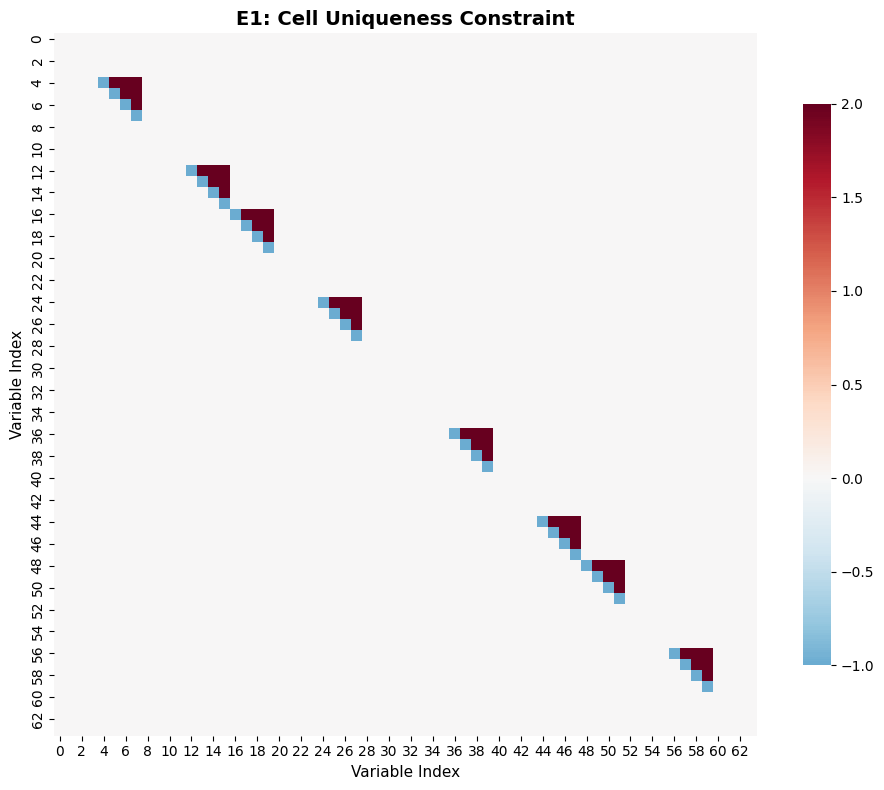


E1 Matrix Statistics:
  Shape: (64, 64)
  Non-zero elements: 80
  Sparsity: 98.0%


In [ ]:
# Visualize E1 matrix structure
visualize_qubo_matrix(Q_E1, title="E1: Cell Uniqueness Constraint", show_values=False)
print(f"\nE1 Matrix Statistics:")
print(f"  Shape: {Q_E1.shape}")
print(f"  Non-zero elements: {np.count_nonzero(Q_E1)}")
print(f"  Sparsity: {(1 - np.count_nonzero(Q_E1) / Q_E1.size) * 100:.1f}%")


### 📊 Matrix Structure Interpretation

The E₁ matrix has a **block diagonal structure** where:
- Each block corresponds to one cell's variables (4×4 for 4×4 Sudoku)
- Within each block, all pairs of variables are coupled (preventing multiple digits in one cell)
- Blocks don't interact (cell constraints are independent)

## Component 2: Row Uniqueness (E₂)

This constraint ensures no row has duplicate or missing digits.

$$E_2 = \sum_{i,k} \left(\sum_j x_{i,j,k} - 1\right)^2$$

When some cells are given, the constraint adjusts to account for already-placed digits.

In [ ]:
# Build E2 (each row has each digit exactly once)
Q_E2, poly_E2, const_E2 = build_E2(N, givens)

print("=" * 70)
print("E2: Each Row Has Each Digit Exactly Once")
print("=" * 70)
print(f"Number of terms: {len(poly_E2)}")
print(f"Constant: {const_E2}")

E2: Each Row Has Each Digit Exactly Once
Number of terms: 48
Constant: 8.0


In [ ]:
# View E2 polynomial
print_polynomial(poly_E2, const_E2, "E2: Each Row Has Each Digit", max_terms=15)


E2: Each Row Has Each Digit
Number of terms: 48
Constant: 8.0

First 15 terms:
  -1.0*x_010
  -1.0*x_030
  2*x_010*x_030
  1.0*x_011
  1.0*x_031
  2*x_011*x_031
  -1.0*x_012
  -1.0*x_032
  2*x_012*x_032
  1.0*x_013
  1.0*x_033
  2*x_013*x_033
  1.0*x_100
  1.0*x_120
  2*x_100*x_120
  ... (33 more terms)


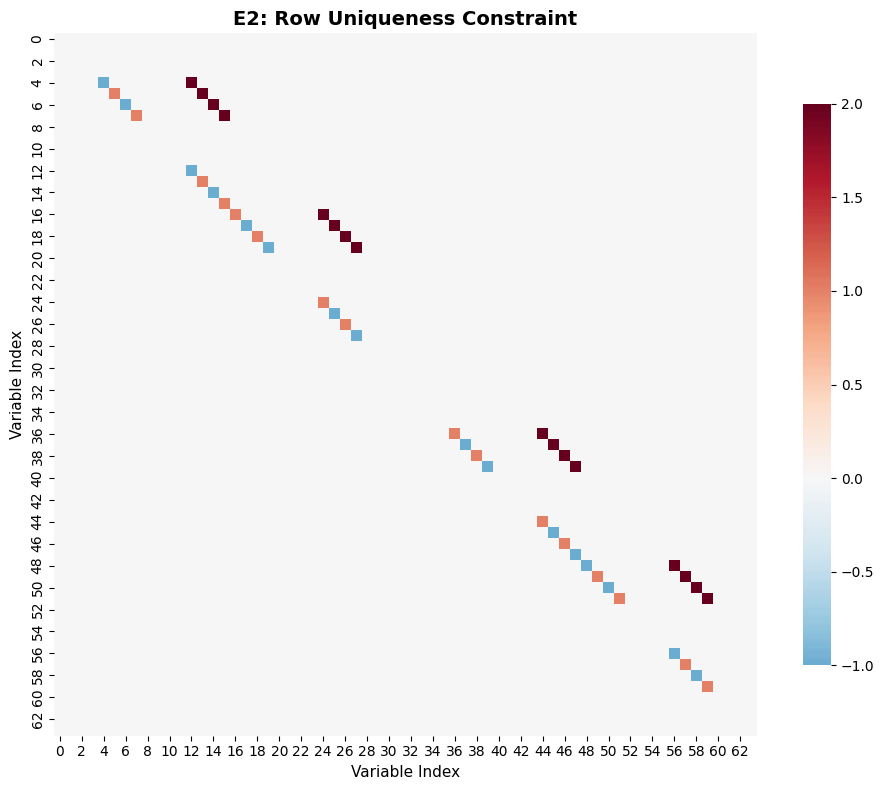


E2 Matrix Statistics:
  Shape: (64, 64)
  Non-zero elements: 48
  Sparsity: 98.8%


In [ ]:
# Visualize E2 matrix structure
visualize_qubo_matrix(Q_E2, title="E2: Row Uniqueness Constraint", show_values=False)
print(f"\nE2 Matrix Statistics:")
print(f"  Shape: {Q_E2.shape}")
print(f"  Non-zero elements: {np.count_nonzero(Q_E2)}")
print(f"  Sparsity: {(1 - np.count_nonzero(Q_E2) / Q_E2.size) * 100:.1f}%")


### 📊 Matrix Structure Interpretation

The E₂ matrix couples variables across **rows**:
- Variables representing the same digit in different columns of a row are coupled
- More distributed pattern than E₁ (less block-diagonal)
- Reflects the global constraint across each row

## Component 3: Column Uniqueness (E₃)

Similar to row constraints, but applied to columns.

$$E_3 = \sum_{j,k} \left(\sum_i x_{i,j,k} - 1\right)^2$$

In [ ]:
# Build E3 (each column has each digit exactly once)
Q_E3, poly_E3, const_E3 = build_E3(N, givens)

print("=" * 70)
print("E3: Each Column Has Each Digit Exactly Once")
print("=" * 70)
print(f"Number of terms: {len(poly_E3)}")
print(f"Constant: {const_E3}")

E3: Each Column Has Each Digit Exactly Once
Number of terms: 48
Constant: 8.0


In [ ]:
# View E3 polynomial
print_polynomial(poly_E3, const_E3, "E3: Each Column Has Each Digit", max_terms=15)


E3: Each Column Has Each Digit
Number of terms: 48
Constant: 8.0

First 15 terms:
  1.0*x_100
  1.0*x_300
  2*x_100*x_300
  1.0*x_101
  1.0*x_301
  2*x_101*x_301
  -1.0*x_102
  -1.0*x_302
  2*x_102*x_302
  -1.0*x_103
  -1.0*x_303
  2*x_103*x_303
  -1.0*x_010
  -1.0*x_210
  2*x_010*x_210
  ... (33 more terms)


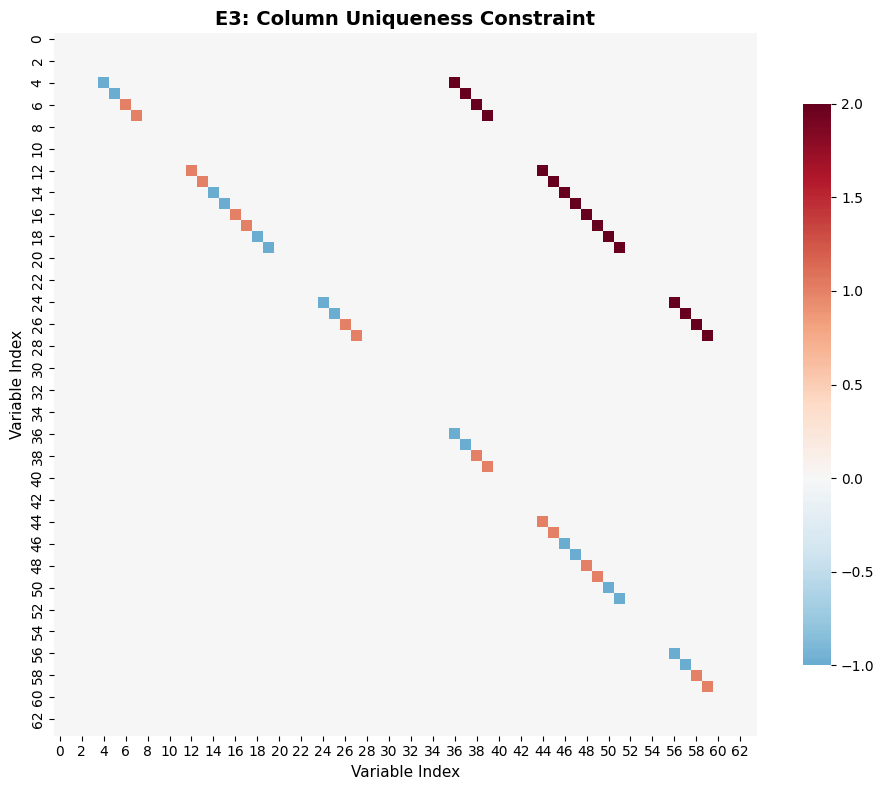


E3 Matrix Statistics:
  Shape: (64, 64)
  Non-zero elements: 48
  Sparsity: 98.8%


In [ ]:
# Visualize E3 matrix structure
visualize_qubo_matrix(Q_E3, title="E3: Column Uniqueness Constraint", show_values=False)
print(f"\nE3 Matrix Statistics:")
print(f"  Shape: {Q_E3.shape}")
print(f"  Non-zero elements: {np.count_nonzero(Q_E3)}")
print(f"  Sparsity: {(1 - np.count_nonzero(Q_E3) / Q_E3.size) * 100:.1f}%")


## Component 4: Box Uniqueness (E₄)

For a 4×4 Sudoku, we have four 2×2 boxes that must each contain digits 1-4 exactly once.

$$E_4 = \sum_{\text{box},k} \left(\sum_{(i,j) \in \text{box}} x_{i,j,k} - 1\right)^2$$

In [ ]:
# Build E4 (each box has each digit exactly once)
Q_E4, poly_E4, const_E4 = build_E4(N, box_size, givens)

print("=" * 70)
print("E4: Each Box Has Each Digit Exactly Once")
print("=" * 70)
print(f"Number of terms: {len(poly_E4)}")
print(f"Constant: {const_E4}")

E4: Each Box Has Each Digit Exactly Once
Number of terms: 48
Constant: 8.0


In [ ]:
# View E4 polynomial
print_polynomial(poly_E4, const_E4, "E4: Each Box Has Each Digit", max_terms=15)


E4: Each Box Has Each Digit
Number of terms: 48
Constant: 8.0

First 15 terms:
  -1.0*x_010
  -1.0*x_100
  2*x_010*x_100
  1.0*x_011
  1.0*x_101
  2*x_011*x_101
  1.0*x_012
  1.0*x_102
  2*x_012*x_102
  -1.0*x_013
  -1.0*x_103
  2*x_013*x_103
  1.0*x_030
  1.0*x_120
  2*x_030*x_120
  ... (33 more terms)


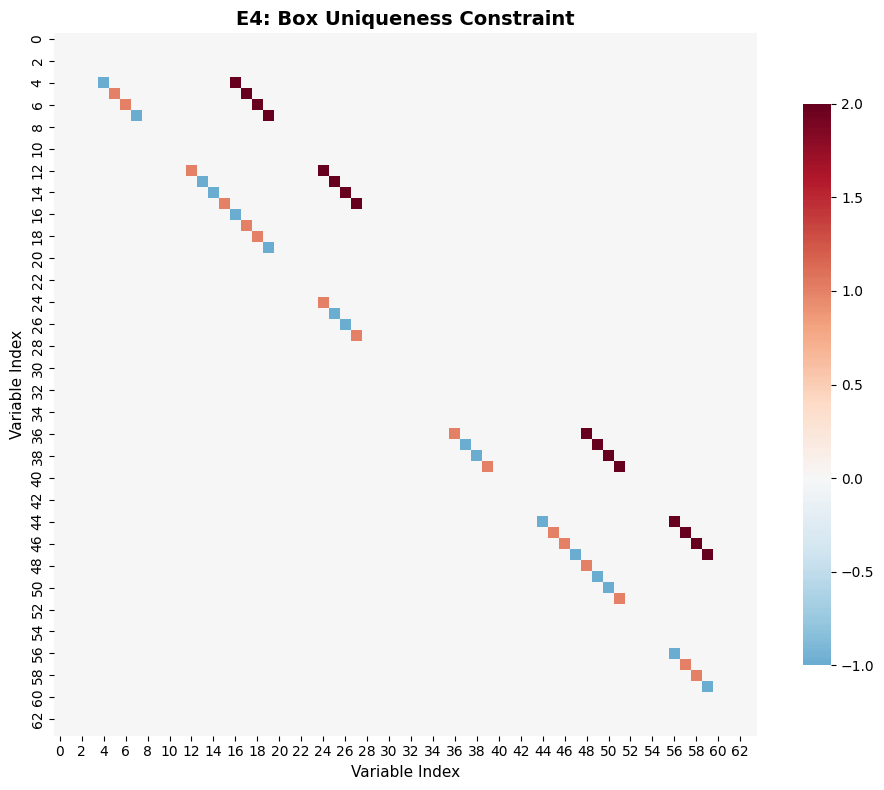


E4 Matrix Statistics:
  Shape: (64, 64)
  Non-zero elements: 48
  Sparsity: 98.8%


In [ ]:
# Visualize E4 matrix structure
visualize_qubo_matrix(Q_E4, title="E4: Box Uniqueness Constraint", show_values=False)
print(f"\nE4 Matrix Statistics:")
print(f"  Shape: {Q_E4.shape}")
print(f"  Non-zero elements: {np.count_nonzero(Q_E4)}")
print(f"  Sparsity: {(1 - np.count_nonzero(Q_E4) / Q_E4.size) * 100:.1f}%")


### 📊 Matrix Structure Interpretation

The E₄ matrix couples variables within **box regions**:
- Creates localized coupling patterns corresponding to the four 2×2 boxes
- Box constraints create additional structure beyond row/column constraints

## Combining All Components

Now we combine all four energy components into a single QUBO matrix.

Since this is a pure constraint satisfaction problem (no objective to minimize), all Lagrange multipliers are set to 1.

$$Q_{\text{total}} = Q_{E_1} + Q_{E_2} + Q_{E_3} + Q_{E_4}$$

Combined QUBO Matrix

QUBO Matrix Statistics:
  Size: 64 × 64
  Total possible entries: 4,096
  Non-zero diagonal entries: 8
  Non-zero off-diagonal entries: 96
  Total non-zero entries: 104
  Sparsity: 97.46%

Given cells: 8
Free variables: 32
Total constant offset: 32.0


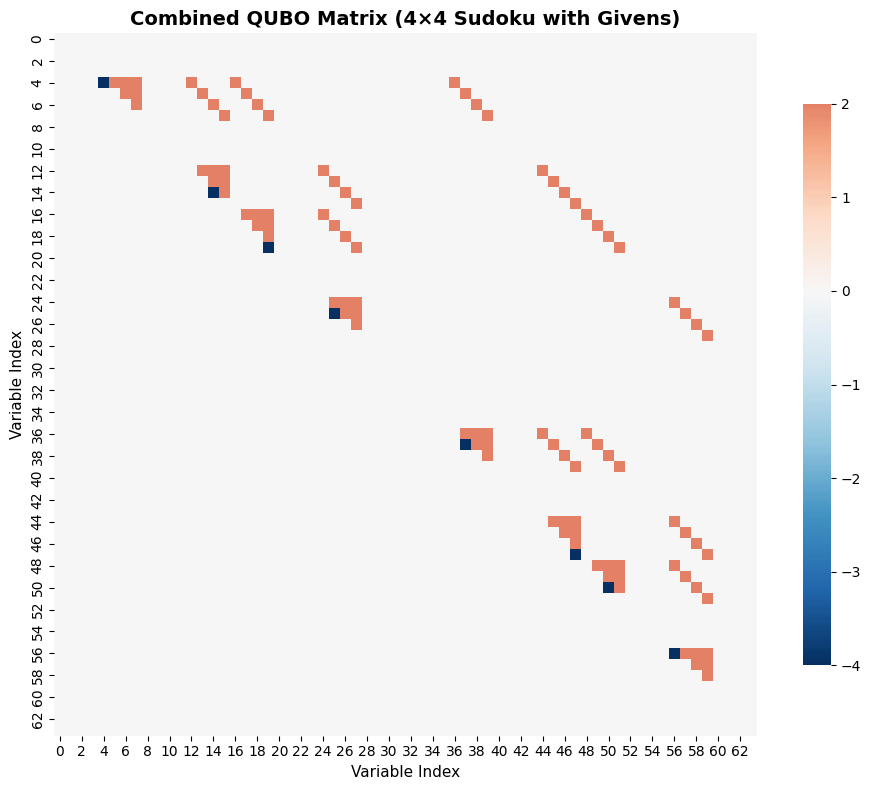

In [ ]:
# Combine all QUBO matrices (all Lagrange multipliers = 1)
Q_total = Q_E1 + Q_E2 + Q_E3 + Q_E4
offset_total = const_E1 + const_E2 + const_E3 + const_E4

print("=" * 70)
print("Combined QUBO Matrix")
print("=" * 70)
print_qubo_stats(Q_total, N, givens)
print(f"Total constant offset: {offset_total}")

# Visualize the combined QUBO
visualize_qubo_matrix(Q_total, f"Combined QUBO Matrix ({N}×{N} Sudoku with Givens)", show_values=False)

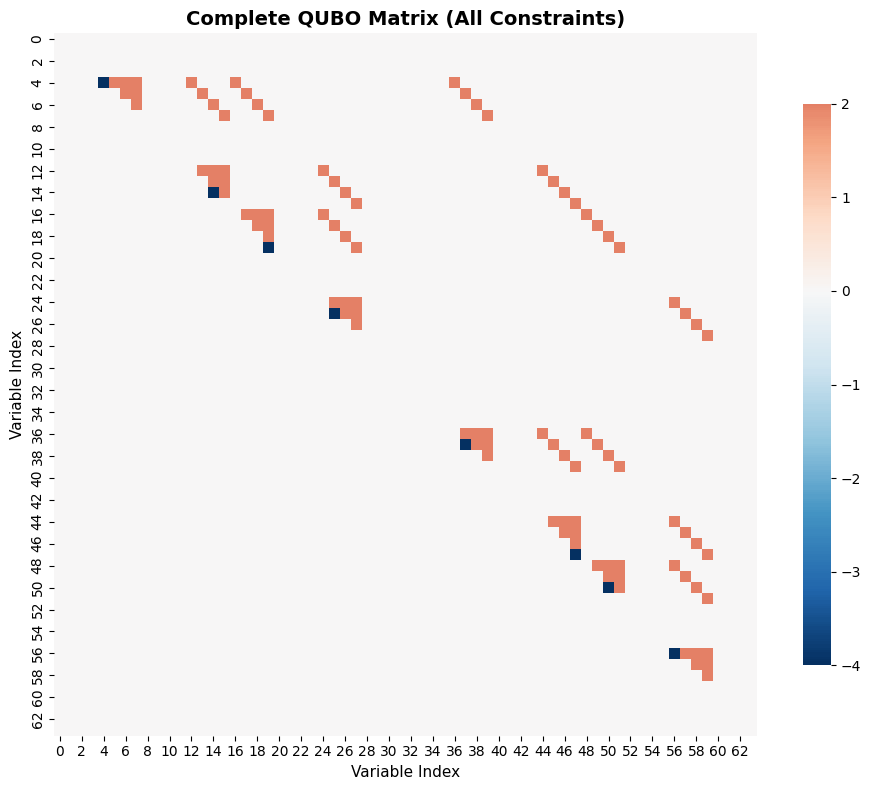


COMPLETE QUBO STATISTICS
Matrix shape: (64, 64)
Total elements: 4,096
Non-zero elements: 104
Sparsity: 97.5%


NameError: name 'offset' is not defined

In [ ]:
# Visualize the complete QUBO matrix
visualize_qubo_matrix(Q_total, title="Complete QUBO Matrix (All Constraints)", show_values=False)

print(f"\n{'='*80}")
print("COMPLETE QUBO STATISTICS")
print(f"{'='*80}")
print(f"Matrix shape: {Q_total.shape}")
print(f"Total elements: {Q_total.size:,}")
print(f"Non-zero elements: {np.count_nonzero(Q_total):,}")
print(f"Sparsity: {(1 - np.count_nonzero(Q_total) / Q_total.size) * 100:.1f}%")
print(f"\nEnergy offset (constant): {offset}")
print(f"\nThis matrix encodes all 4 Sudoku constraints simultaneously.")


### 📊 Interpreting the Combined Matrix

The complete QUBO matrix shows:

1. **Diagonal elements** (linear terms): Encourage variables to take value 1
2. **Off-diagonal elements** (quadratic terms): Encode constraint relationships
3. **Block structure**: Reflects the layered constraint structure
4. **Sparsity**: Most variable pairs don't interact (only constrained pairs have non-zero entries)

The goal is to find a binary assignment that minimizes this quadratic form to reach E=0.

## Testing the QUBO

Let's validate our QUBO by testing it with correct and incorrect solutions.

### Test Case 1: Correct Solution ✅

In [ ]:
# Correct solution bitstring
bitstring_correct = (
    "0100" + "1000" + "0001" + "0010" +  # Row 0: 2,1,4,3
    "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
    "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
    "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
)

print("Test Case 1: Correct Solution")
print("=" * 70)

# Evaluate using calc_mods
energy_calc, breakdown = total_energy(bitstring_correct, N, box_size, verbose=False)
print(f"\ncalc_mods energy: {energy_calc}")
print(f"Breakdown: E1={breakdown[0]}, E2={breakdown[1]}, E3={breakdown[2]}, E4={breakdown[3]}")
print(f"Valid solution: {is_valid_solution(breakdown)}")

# Evaluate using QUBO
Q_full, var_to_idx, idx_to_var, offset_full = build_sudoku_qubo(N, box_size, givens)
energy_qubo = evaluate_qubo(Q_full, bitstring_correct, offset_full)
print(f"\nQUBO energy: {energy_qubo}")

# Visualize the solution
from calc_mods import bitstring_to_tensor
x = bitstring_to_tensor(bitstring_correct, N)
grid = tensor_to_grid(x, N)
print("\nSolution grid:")
print_grid(grid, N, box_size)

### Test Case 2: Incorrect Solution ❌

In [ ]:
# Incorrect solution - swap cells (0,1) and (0,3): 1↔3
bitstring_wrong = (
    "0100" + "0010" + "0001" + "1000" +  # Row 0: 2,3,4,1 (wrong!)
    "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
    "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
    "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
)

print("Test Case 2: Incorrect Solution")
print("=" * 70)

# Evaluate using calc_mods
energy_calc_wrong, breakdown_wrong = total_energy(bitstring_wrong, N, box_size, verbose=True)
print(f"\nValid solution: {is_valid_solution(breakdown_wrong)}")

# Evaluate using QUBO
energy_qubo_wrong = evaluate_qubo(Q_full, bitstring_wrong, offset_full)
print(f"\nQUBO energy: {energy_qubo_wrong}")
print(f"Energy difference from correct: {energy_qubo_wrong - energy_qubo}")

print("\nThe incorrect solution has HIGHER energy, as expected!")

### Validation Summary

✅ **Correct solution** → Energy = 0 (all constraints satisfied)  
❌ **Incorrect solution** → Energy > 0 (constraints violated)

This confirms our QUBO formulation correctly encodes the Sudoku constraints!

## Comparison: Blank 4×4 Sudoku

Let's examine the QUBO for a **completely blank** 4×4 Sudoku to see the full problem complexity without any givens.

In [ ]:
# Build QUBO for blank 4×4 Sudoku
N_blank = 4
box_size_blank = 2
givens_blank = None

Q_blank, var_to_idx_blank, idx_to_var_blank, offset_blank = build_sudoku_qubo(
    N_blank, box_size_blank, givens_blank
)

print("=" * 70)
print("Blank 4×4 Sudoku (No Givens)")
print("=" * 70)
print_qubo_stats(Q_blank, N_blank, givens_blank)
print(f"Total constant offset: {offset_blank}")

# Visualize
visualize_qubo_matrix(Q_blank, "Blank 4×4 Sudoku QUBO Matrix", show_values=False)

In [ ]:
# Test the same solution on blank puzzle
energy_blank = evaluate_qubo(Q_blank, bitstring_correct, offset_blank)

print(f"Energy of correct solution on blank puzzle: {energy_blank}")
print("Energy is 0, confirming all constraints are satisfied!")

In [ ]:
# Visualize blank Sudoku QUBO
visualize_qubo_matrix(Q_blank, title="Blank 4×4 Sudoku QUBO (No Givens)", show_values=False)

print(f"\n{'='*80}")
print("COMPARISON: With Givens vs. Without Givens")
print(f"{'='*80}")
print(f"\n{'Metric':<30} {'With 8 Givens':<20} {'Blank (0 Givens)'}")
print("-" * 70)
print(f"{'Matrix size':<30} {f'{Q_total.shape[0]}×{Q_total.shape[0]}':<20} {f'{Q_blank.shape[0]}×{Q_blank.shape[0]}'}")
print(f"{'Free variables':<30} {Q_total.shape[0]:<20} {Q_blank.shape[0]}")
print(f"{'Non-zero elements':<30} {np.count_nonzero(Q_total):<20} {np.count_nonzero(Q_blank)}")
print(f"{'Sparsity %':<30} {(1 - np.count_nonzero(Q_total)/Q_total.size)*100:<20.1f} {(1 - np.count_nonzero(Q_blank)/Q_blank.size)*100:.1f}")
print(f"\nGivens eliminate {Q_blank.shape[0] - Q_total.shape[0]} variables!")


---
# 6. Variable Elimination & Reduction ⭐

## The Power of Given Cells

When cells have **given values** (clues), we can:

1. **Eliminate variables** for those cells (we know their values)
2. **Reduce matrix size** dramatically
3. **Simplify constraints** by substituting known values

This is one of the most important optimizations for quantum annealing!

## How Variable Elimination Works

For each given cell at position $(i,j)$ with digit $d$:

1. Set $x_{i,j,d-1} = 1$ (the correct digit variable)
2. Set all other $x_{i,j,k} = 0$ for $k \neq d-1$  
3. Remove these variables from the QUBO
4. Propagate these values into remaining constraints

### Example

If cell $(0,0)$ has digit 2:
- Before: Variables $x_{0,0,0}, x_{0,0,1}, x_{0,0,2}, x_{0,0,3}$
- After: All eliminated! We know $x_{0,0,1} = 1$ and the rest are 0

## Three-Stage Visualization

Let's see how the QUBO matrix evolves through three stages:

1. **Stage 1:** Blank 4×4 Sudoku (64×64 matrix, all variables free)
2. **Stage 2:** With givens substituted (64×64 matrix, some variables = 0)
3. **Stage 3:** Reduced matrix (32×32 matrix, only free variables)


In [ ]:
print("="*80)
print("THREE-STAGE MATRIX EVOLUTION")
print("="*80)
print()

# Stage 1: Blank puzzle (no givens)
print("Stage 1: Building blank 4×4 Sudoku QUBO (no givens)...")
Q_stage1, _, _, offset_stage1 = build_sudoku_qubo(N, box_size, givens=None)
print(f"  Matrix size: {Q_stage1.shape[0]}×{Q_stage1.shape[1]}")
print(f"  All {Q_stage1.shape[0]} variables are free")
print()

# Stage 2: With givens (variables still in matrix but constrained)
print("Stage 2: Building 4×4 Sudoku with 8 givens...")
Q_stage2, _, _, offset_stage2 = build_sudoku_qubo(N, box_size, givens)
print(f"  Matrix size: {Q_stage2.shape[0]}×{Q_stage2.shape[1]}")
print(f"  Given cells: {len(givens)}")
print(f"  Free variables: {(N*N - len(givens)) * N}")
print(f"  Note: Matrix still 64×64, but constraints are adjusted")
print()

# Stage 3: Reduced (eliminated variables)
print("Stage 3: Building reduced QUBO (given variables eliminated)...")
Q_stage3, var_to_idx_stage3, idx_to_var_stage3, offset_stage3, info_stage3 = build_reduced_qubo_direct(
    N, box_size, givens
)
print(f"  Matrix size: {Q_stage3.shape[0]}×{Q_stage3.shape[1]}")
print(f"  Free variables: {Q_stage3.shape[0]}")
print(f"  Eliminated: {Q_stage1.shape[0] - Q_stage3.shape[0]} variables")
print()

print("Ready to visualize all three stages!")


In [ ]:
# Visualize all three stages
print("\n" + "="*80)
print("VISUALIZATION: Three Stages of Matrix Evolution")
print("="*80)
print()

# Stage 1
visualize_qubo_matrix(Q_stage1,
                     title="Stage 1: Blank 4×4 Sudoku\n64×64 matrix (all variables free)")
print(f"Stage 1 Statistics:")
print(f"  Matrix size: {Q_stage1.shape[0]}×{Q_stage1.shape[1]}")
print(f"  Non-zero elements: {np.count_nonzero(Q_stage1):,}")
print(f"  Sparsity: {(1 - np.count_nonzero(Q_stage1)/Q_stage1.size)*100:.1f}%")
print()

# Stage 2
visualize_qubo_matrix(Q_stage2,
                     title="Stage 2: With 8 Givens Substituted\n64×64 matrix (constraints adjusted)")
print(f"Stage 2 Statistics:")
print(f"  Matrix size: {Q_stage2.shape[0]}×{Q_stage2.shape[1]}")
print(f"  Non-zero elements: {np.count_nonzero(Q_stage2):,}")
print(f"  Sparsity: {(1 - np.count_nonzero(Q_stage2)/Q_stage2.size)*100:.1f}%")
print(f"  Note: Still 64×64 but with adjusted constraints for givens")
print()

# Stage 3
visualize_qubo_matrix(Q_stage3,
                     title="Stage 3: Reduced Matrix\n32×32 matrix (given variables eliminated)")
print(f"Stage 3 Statistics:")
print(f"  Matrix size: {Q_stage3.shape[0]}×{Q_stage3.shape[1]}")
print(f"  Non-zero elements: {np.count_nonzero(Q_stage3):,}")
print(f"  Sparsity: {(1 - np.count_nonzero(Q_stage3)/Q_stage3.size)*100:.1f}%")
print()


In [ ]:
# Side-by-side comparison
print("="*80)
print("COMPARISON SUMMARY")
print("="*80)
print()
print(f"{'Stage':<30} {'Matrix Size':<15} {'Variables':<12} {'Non-zero'}")
print("-" * 80)
print(f"{'1: Blank (no givens)':<30} {f'{Q_stage1.shape[0]}×{Q_stage1.shape[1]}':<15} {Q_stage1.shape[0]:<12} {np.count_nonzero(Q_stage1):,}")
print(f"{'2: With givens substituted':<30} {f'{Q_stage2.shape[0]}×{Q_stage2.shape[1]}':<15} {Q_stage2.shape[0]:<12} {np.count_nonzero(Q_stage2):,}")
print(f"{'3: Reduced (eliminated)':<30} {f'{Q_stage3.shape[0]}×{Q_stage3.shape[1]}':<15} {Q_stage3.shape[0]:<12} {np.count_nonzero(Q_stage3):,}")
print()
print("Key Observations:")
print(f"  • Stage 1→2: Same size (64×64) but constraints adjusted for givens")
print(f"  • Stage 2→3: Size reduced by {((1-Q_stage3.shape[0]/Q_stage2.shape[0])*100):.0f}% through variable elimination")
print(f"  • Stage 1→3: Total matrix element reduction: {((1-(Q_stage3.size/Q_stage1.size))*100):.0f}%")
print()
print("🎯 Variable elimination transforms a 64×64 problem into a 32×32 problem!")

# Store the reduced QUBO for later use
Q_reduced = Q_stage3
var_to_idx_reduced = var_to_idx_stage3
idx_to_var_reduced = idx_to_var_stage3
offset_reduced = offset_stage3
reduction_info = info_stage3


### 📊 Understanding the Reduction

The three stages show different representations of the same problem:

**Stage 1 (Blank):** The "full" problem with no information
- All 64 variables present
- Maximum problem complexity
- 4,096 matrix elements

**Stage 2 (With Givens):** Constraints adjusted but matrix size unchanged
- Still 64×64 matrix
- Constraints account for 8 given cells
- Some constraint terms simplified
- Matrix still includes variables for given cells (though they're not "free")

**Stage 3 (Reduced):** Given variables completely eliminated
- Only 32×32 matrix (50% reduction)
- Only free variables included
- 1,024 matrix elements (75% reduction!)
- Much more efficient for solvers


In [ ]:
# Detailed reduction statistics
print_reduction_stats(reduction_info, N, box_size)


## Testing the Reduced QUBO

Let's verify that the reduced QUBO produces the same energy values as the full versions.

In [ ]:
print("="*80)
print("Energy Validation: All Three Stages")
print("="*80)
print()

# Correct solution
bitstring_correct = (
    "0100" + "1000" + "0001" + "0010" +  # Row 0: 2,1,4,3
    "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
    "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
    "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
)

# Evaluate on all three matrices
energy_stage1 = evaluate_qubo(Q_stage1, bitstring_correct, offset_stage1)
energy_stage2 = evaluate_qubo(Q_stage2, bitstring_correct, offset_stage2)
energy_stage3 = evaluate_reduced_qubo(Q_stage3, bitstring_correct,
                                       var_to_idx_stage3, idx_to_var_stage3, offset_stage3)

print("Correct Solution Energy:")
print(f"  Stage 1 (Blank):      {energy_stage1:.6f}")
print(f"  Stage 2 (W/ Givens):  {energy_stage2:.6f}")
print(f"  Stage 3 (Reduced):    {energy_stage3:.6f}")
print()

# Check if all match
all_match = (abs(energy_stage1 - energy_stage2) < 1e-10 and
             abs(energy_stage2 - energy_stage3) < 1e-10)

if all_match:
    print("✅ All three stages produce IDENTICAL energies!")
    print("   • Stage 1: Full problem representation")
    print("   • Stage 2: With constraints adjusted for givens")
    print("   • Stage 3: Compact representation with only free variables")
else:
    print("❌ Energy mismatch detected")

print()
print("All three stages encode the SAME problem - just in different forms!")


## Solution Reconstruction

When we solve the reduced QUBO, we get a solution for only the **free variables**. We need to reconstruct the full solution by adding back the given values.

In [ ]:
print("="*80)
print("Solution Reconstruction Demo")
print("="*80)
print()

# Extract just the free variable bits from correct solution
reduced_bits = ""
idx_full = 0
for i in range(N):
    for j in range(N):
        for k in range(N):
            if (i, j, k) in var_to_idx_reduced:
                reduced_bits += bitstring_correct[idx_full]
            idx_full += 1

print(f"Original full solution:     {len(bitstring_correct)} bits")
print(f"  {bitstring_correct}")
print()

print(f"Extracted reduced solution: {len(reduced_bits)} bits")
print(f"  {reduced_bits}")
print("  (Only bits for free cells!)")
print()

# Reconstruct
reconstructed = reconstruct_full_solution(
    reduced_bits,
    var_to_idx_reduced,
    idx_to_var_reduced,
    givens,
    N
)

print(f"Reconstructed full solution: {len(reconstructed)} bits")
print(f"  {reconstructed}")
print()

# Verify
match = (reconstructed == bitstring_correct)
print(f"Match with original: {match} {'✓' if match else '✗'}")
print()

if match:
    print("✓ Perfect reconstruction!")
    print("  • Solved with 32 variables (reduced QUBO)")
    print("  • Reconstructed to 64 bits (full solution)")
    print("  • Added back the 32 bits for given cells")


## Key Takeaways: Variable Elimination

### Why It Matters

1. **Quantum Annealer Efficiency**: Fewer qubits needed → can solve on smaller hardware
2. **Faster Solve Times**: Smaller search space → quicker convergence
3. **Better Solutions**: More focused optimization on actual unknowns

### The Three Representations

- **Blank (Stage 1)**: Full problem with no information (64 vars)
- **With Givens (Stage 2)**: Same size but constraints adjusted (64 vars, 32 effective)
- **Reduced (Stage 3)**: Compact form with only free variables (32 vars)

### The Trade-off

- **More givens** = smaller QUBO but easier problem (less interesting)
- **Fewer givens** = larger QUBO but harder problem (more interesting)

For quantum annealing experiments, finding the sweet spot is crucial!

---
# 7. Scaling to 9×9

## The Scaling Challenge

Let's examine how the problem grows from 4×4 to 9×9 Sudoku.

### Problem Size Comparison

| Metric | 4×4 | 9×9 | Growth Factor |
|--------|-----|-----|---------------|
| Cells | 16 | 81 | 5.1× |
| Total variables | 64 | 729 | 11.4× |
| Matrix elements | 4,096 | 531,441 | 129.7× |
| Typical givens | 8 | 30 | 3.8× |
| Free variables | 32 | ~675 | 21.1× |

### Hardware Implications

Current quantum annealers (e.g., D-Wave Advantage):
- ~5,000 qubits available
- Limited qubit connectivity
- 9×9 Sudoku with ~675 variables is feasible
- Embedding and minor-embedding become critical

## Building a 9×9 QUBO

In [ ]:
# Build QUBO for blank 9×9 Sudoku (construction only)
N_large = 9
box_size_large = 3
givens_large = None

print("Building 9×9 Sudoku QUBO...")
Q_large, var_to_idx_large, idx_to_var_large, offset_large = build_sudoku_qubo(
    N_large, box_size_large, givens_large
)

print("\n" + "=" * 70)
print("Blank 9×9 Sudoku")
print("=" * 70)
print_qubo_stats(Q_large, N_large, givens_large)
print(f"Total constant offset: {offset_large}")

print("\nThe 9×9 QUBO has been successfully constructed!")
print(f"Matrix size: {Q_large.shape[0]}×{Q_large.shape[1]}")

In [ ]:
# Visualize the 9x9 QUBO structure
visualize_qubo_matrix(Q_large, title="9×9 Sudoku QUBO", show_values=False)

print(f"\n{'='*80}")
print("9×9 SUDOKU QUBO STATISTICS")
print(f"{'='*80}")
print(f"Matrix shape: {Q_large.shape}")
print(f"Total elements: {Q_large.size:,}")
print(f"Non-zero elements: {np.count_nonzero(Q_large):,}")
print(f"Sparsity: {(1 - np.count_nonzero(Q_large) / Q_large.size) * 100:.1f}%")
print(f"\nThis is a {Q_large.shape[0]}×{Q_large.shape[1]} matrix!")
if givens_large:
    print(f"\nWith {len(givens_large)} givens, we have {Q_large.shape[0]} free variables to optimize.")
else:
    print(f"\nThis is a blank 9×9 Sudoku with all {Q_large.shape[0]} variables free to optimize.")


## Scaling Analysis

Let's analyze how problem complexity grows across different Sudoku sizes.

In [ ]:
# Analyze scaling
sizes = [(4, 4), (9, 9), (16, 16), (25, 25)]
data = []

for n in [4, 9, 16, 25]:
    n_vars = n ** 3
    n_constraints = 4 * n * n
    # Estimate non-zero entries (empirical from our examples)
    sparsity = 1 - (n_vars + 4 * 6 * n * n) / (n_vars ** 2)
    data.append({
        'N': n,
        'Variables': n_vars,
        'Constraints': n_constraints,
        'Matrix Size': f'{n_vars}×{n_vars}',
        'Sparsity': f'{sparsity*100:.2f}%'
    })

import pandas as pd
df = pd.DataFrame(data)
print("\nScaling Analysis:")
print("=" * 70)
print(df.to_string(index=False))

# Plot scaling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ns = [4, 9, 16, 25]
vars = [n**3 for n in ns]
constraints = [4*n*n for n in ns]

ax1.plot(ns, vars, 'o-', linewidth=2, markersize=8, label='Variables')
ax1.plot(ns, constraints, 's-', linewidth=2, markersize=8, label='Constraints')
ax1.set_xlabel('Sudoku Size (N×N)', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('Scaling of Variables and Constraints', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.semilogy(ns, vars, 'o-', linewidth=2, markersize=8)
ax2.set_xlabel('Sudoku Size (N×N)', fontsize=11)
ax2.set_ylabel('Number of Variables (log scale)', fontsize=11)
ax2.set_title('Variable Growth (Logarithmic Scale)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 📈 Scaling Insights

The analysis reveals:

1. **Superlinear growth**: Matrix size grows as $O(N^6)$ where N is the grid dimension
2. **16×16 becomes impractical**: 4,096 variables exceeds most quantum annealer capacities
3. **Sparsity helps**: Despite large matrices, most entries are zero
4. **Givens are crucial**: Variable elimination is essential for larger puzzles

---
# 8. Discussion & Next Steps

## What We've Learned

### 1. QUBO Formulation Fundamentals

- Constraint satisfaction problems can be encoded as energy minimization
- Squared penalties $(\sum x_i - 1)^2$ naturally encode "exactly one" constraints
- The QUBO matrix structure reflects the constraint relationships

### 2. Component Analysis

We saw four distinct constraint types:
- **E₁ (Cell)**: Block diagonal, local to each cell
- **E₂ (Row)**: Couples variables across columns  
- **E₃ (Column)**: Couples variables across rows
- **E₄ (Box)**: Couples variables within box regions

Each creates different coupling patterns in the final QUBO.

### 3. Variable Elimination Power

Given cells provide massive benefits:
- 50%+ reduction in problem size for typical puzzles
- Crucial for fitting on quantum hardware
- Must be carefully reconstructed after solving

### 4. Scaling Challenges

The quadratic growth in matrix size means:
- 9×9 is feasible on current hardware
- 16×16 exceeds most quantum annealer capabilities
- Need advanced techniques (embedding, decomposition) for larger puzzles

## Solving the QUBO

### Classical Approaches

To solve the QUBO, we can use:

1. **Simulated Annealing**: Probabilistic search with temperature schedule
2. **Tabu Search**: Local search with memory to avoid cycles
3. **Genetic Algorithms**: Population-based evolutionary search
4. **Branch and Bound**: Exhaustive with pruning

### Quantum Annealing

For quantum hardware (e.g., D-Wave):

```python
from dwave.system import DWaveSampler, EmbeddingComposite

# Convert QUBO to D-Wave format
sampler = EmbeddingComposite(DWaveSampler())
response = sampler.sample_qubo(Q_dict, num_reads=1000)

# Extract best solution
best_solution = response.first.sample
```

### Hybrid Approaches

Combine quantum and classical:
- Use quantum annealer for global search
- Use classical refinement for local optimization
- Decompose large problems into quantum-solvable pieces

## Next Steps & Extensions

### For Further Exploration

1. **Tune Lagrange Multipliers**: Experiment with different L₁, L₂, L₃, L₄ values
2. **Test on Real Hardware**: Submit to D-Wave or other quantum annealers
3. **Compare Solvers**: Benchmark quantum vs. classical approaches
4. **Analyze Solution Quality**: Study how often global minimum is found

### Advanced Topics

1. **Penalty Scheduling**: Dynamic Lagrange multipliers during annealing
2. **Problem Decomposition**: Break 16×16 into manageable subproblems  
3. **Embedding Optimization**: Minimize chain length on quantum hardware
4. **Hybrid Algorithms**: Quantum-classical collaboration schemes

### Other Applications

The techniques here apply to many constraint satisfaction problems:
- Graph coloring
- Scheduling (job shop, timetabling)
- Satisfiability (SAT)
- Latin squares and other combinatorial puzzles

## Conclusion

### Summary

We've demonstrated how to:

✅ Formulate Sudoku as a QUBO problem with four energy components  
✅ Visualize and understand the matrix structure  
✅ Apply variable elimination to reduce problem size  
✅ Analyze scaling from 4×4 to 9×9 and beyond  

### The Big Picture

QUBO formulation is a **bridge** between:
- **Human understanding**: Constraint satisfaction rules
- **Machine optimization**: Energy minimization
- **Quantum hardware**: Physical annealing process

Mastering this bridge opens doors to solving complex combinatorial problems with quantum annealing.

### Key Insight

> **The art of QUBO formulation** lies in balancing:
> - Problem fidelity (encoding all constraints correctly)
> - Problem size (keeping it solvable)
> - Solution quality (finding global optima)

### Resources

- **D-Wave Documentation**: https://docs.dwavesys.com/
- **QUBO Formulation Guide**: Lucas, A. (2014). "Ising formulations of many NP problems"
- **Quantum Annealing**: https://en.wikipedia.org/wiki/Quantum_annealing

---

**Thank you for working through this notebook!** 🎉

Questions or feedback? Feel free to reach out or adapt this code for your own projects.

## 1. Problem Definition

### The Sudoku Problem

Sudoku is a constraint satisfaction puzzle where we must fill an N×N grid with digits 1 through N such that:

1. **Each cell** contains exactly one digit
2. **Each row** contains each digit exactly once
3. **Each column** contains each digit exactly once
4. **Each box** contains each digit exactly once

For a 4×4 Sudoku:
- 4 rows, 4 columns
- 4 boxes of size 2×2
- Digits 1, 2, 3, 4

For a 9×9 Sudoku:
- 9 rows, 9 columns
- 9 boxes of size 3×3
- Digits 1 through 9

Some cells may be given (clues), reducing the problem's complexity.

## 2. Mathematical Formulation

### Binary Variables

We encode the problem using binary variables with **one-hot encoding**:

$$x_{i,j,k} = \begin{cases}
1 & \text{if cell }(i,j)\text{ contains digit }k+1 \\
0 & \text{otherwise}
\end{cases}$$

Where:
- $i \in \{0, 1, ..., N-1\}$ is the row index
- $j \in \{0, 1, ..., N-1\}$ is the column index
- $k \in \{0, 1, ..., N-1\}$ is the digit index (0 represents digit 1, etc.)

For a 4×4 Sudoku: **64 binary variables**  
For a 9×9 Sudoku: **729 binary variables**

### Energy Function

The total energy is:

$$E = E_1 + E_2 + E_3 + E_4$$

Where:
- $E_1$: Each cell has exactly one digit
- $E_2$: Each row has each digit exactly once
- $E_3$: Each column has each digit exactly once
- $E_4$: Each box has each digit exactly once

Each constraint is formulated as a squared penalty:

$$E_1 = \sum_{i,j} \left[\sum_k x_{i,j,k} - 1\right]^2$$

$$E_2 = \sum_{i,k} \left[\sum_j x_{i,j,k} - 1\right]^2$$

$$E_3 = \sum_{j,k} \left[\sum_i x_{i,j,k} - 1\right]^2$$

$$E_4 = \sum_{\text{box},k} \left[\sum_{(i,j) \in \text{box}} x_{i,j,k} - 1\right]^2$$

A valid solution has $E = 0$ (all constraints satisfied).

## 3. QUBO Construction

### Setup and Imports

We'll use our pre-tested functions for QUBO construction from the accompanying Python modules.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import our tested QUBO construction functions
from qubo_generation import (
    build_E1, build_E2, build_E3, build_E4,
    build_sudoku_qubo, evaluate_qubo,
    print_E1_details, print_E2_details, print_E3_details, print_E4_details
)

# Import matrix reduction functions
from matrix_reduction import (
    build_reduced_qubo,
    build_reduced_qubo_direct,
    evaluate_reduced_qubo,
    reconstruct_full_solution,
    print_reduction_stats
)

ModuleNotFoundError: No module named 'qubo_generation'

### Helper Functions for Visualization

In [ ]:
def visualize_qubo_matrix(Q, title="QUBO Matrix", show_values=False):
    """
    Visualize a QUBO matrix as a heatmap.

    Args:
        Q: QUBO matrix
        title: Title for the plot
        show_values: Whether to show numerical values in cells
    """
    plt.figure(figsize=(10, 8))

    if show_values and Q.shape[0] <= 20:
        sns.heatmap(Q, annot=True, fmt='.1f', cmap='RdBu_r', center=0,
                   square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    else:
        sns.heatmap(Q, cmap='RdBu_r', center=0,
                   square=True, cbar_kws={"shrink": 0.8})

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Variable Index', fontsize=11)
    plt.ylabel('Variable Index', fontsize=11)
    plt.tight_layout()
    plt.show()


def print_polynomial(poly_terms, constant, title, max_terms=10):
    """
    Print a polynomial in readable format.

    Args:
        poly_terms: List of polynomial term strings
        constant: Constant term
        title: Title for the polynomial
        max_terms: Maximum number of terms to display
    """
    print(f"\n{title}")
    print("=" * 70)
    print(f"Number of terms: {len(poly_terms)}")
    print(f"Constant: {constant}")

    if len(poly_terms) > 0:
        print(f"\nFirst {min(max_terms, len(poly_terms))} terms:")
        for i, term in enumerate(poly_terms[:max_terms]):
            print(f"  {term}")

        if len(poly_terms) > max_terms:
            print(f"  ... ({len(poly_terms) - max_terms} more terms)")


def visualize_sudoku(grid, N, box_size, title="Sudoku Grid"):
    """
    Visualize a Sudoku grid.

    Args:
        grid: N×N numpy array with digit values
        N: Size of Sudoku
        box_size: Size of each box
        title: Title for the plot
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    # Create colored grid
    ax.imshow(np.ones((N, N)), cmap='Greys', alpha=0.1)

    # Draw grid lines
    for i in range(N + 1):
        linewidth = 2 if i % box_size == 0 else 0.5
        ax.axhline(i - 0.5, color='black', linewidth=linewidth)
        ax.axvline(i - 0.5, color='black', linewidth=linewidth)

    # Add numbers
    for i in range(N):
        for j in range(N):
            if grid[i, j] != 0:
                ax.text(j, i, str(grid[i, j]),
                       ha='center', va='center', fontsize=16, fontweight='bold')

    ax.set_xlim(-0.5, N - 0.5)
    ax.set_ylim(N - 0.5, -0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 4. Example: 4×4 Sudoku Puzzle

Let's work through a complete example with a partially filled 4×4 Sudoku puzzle.

**Given cells (clues):**
```
2 _ | 4 _
_ 3 | _ 1
-----+----
1 _ | 3 _
_ 4 | _ 2
```

**Solution:**
```
2 1 | 4 3
4 3 | 2 1
-----+----
1 2 | 3 4
3 4 | 1 2
```

In [ ]:
# Define the 4×4 Sudoku puzzle
N = 4
box_size = 2

# Given cells (using 0-indexed positions, 1-indexed digits)
givens = {
    (0, 0): 2,           (0, 2): 4,
              (1, 1): 3,           (1, 3): 1,
    (2, 0): 1,           (2, 2): 3,
              (3, 1): 4,           (3, 3): 2
}

print(f"Sudoku size: {N}×{N}")
print(f"Box size: {box_size}×{box_size}")
print(f"Number of givens: {len(givens)}")
print(f"Number of variables: {N * N * N} (before eliminating givens)")
print(f"Free variables: {(N*N - len(givens)) * N}")

# Visualize the puzzle
print("\nGiven cells:")
for i in range(N):
    row_str = ""
    for j in range(N):
        if j > 0 and j % box_size == 0:
            row_str += "| "
        if (i, j) in givens:
            row_str += str(givens[(i, j)]) + " "
        else:
            row_str += "_ "
    print(row_str.rstrip())
    if i == box_size - 1:
        print("-" * (2*N + box_size - 1))

## 4a. Building QUBO Components

We'll build each energy term separately using our tested functions.

### E1: Each Cell Has Exactly One Digit

This ensures every cell contains **exactly one digit** (no empty cells, no multiple digits).

$$E_1 = \sum_{i,j} \left[\sum_k x_{i,j,k} - 1\right]^2$$

When expanded for QUBO:
$$E_1 = \sum_{i,j} \left[-\sum_k x_{i,j,k} + 2\sum_{k<k'} x_{i,j,k} \cdot x_{i,j,k'} + 1\right]$$

In [ ]:
# Build E1 (each cell has exactly one digit)
Q_E1, poly_E1, const_E1 = build_E1(N, givens)

print("=" * 70)
print("E1: Each Cell Has Exactly One Digit")
print("=" * 70)
print(f"Number of terms: {len(poly_E1)}")
print(f"Constant: {const_E1}")
print(f"\nNote: {len(givens)} cells are given, so they don't contribute variables")

In [ ]:
# View E1 polynomial
print_polynomial(poly_E1, const_E1, "E1: Each Cell Has Exactly One Digit", max_terms=15)

### E2: Each Row Has Each Digit Exactly Once

This ensures no row has duplicate or missing digits.

$$E_2 = \sum_{i,k} \left[\sum_j x_{i,j,k} - 1\right]^2$$

When some cells are given, the constraint adjusts to account for already-placed digits.

In [ ]:
# Build E2 (each row has each digit exactly once)
Q_E2, poly_E2, const_E2 = build_E2(N, givens)

print("=" * 70)
print("E2: Each Row Has Each Digit Exactly Once")
print("=" * 70)
print(f"Number of terms: {len(poly_E2)}")
print(f"Constant: {const_E2}")

In [ ]:
# View E2 polynomial
print_polynomial(poly_E2, const_E2, "E2: Each Row Has Each Digit", max_terms=15)

### E3: Each Column Has Each Digit Exactly Once

Similar to row constraints, but applied to columns.

$$E_3 = \sum_{j,k} \left[\sum_i x_{i,j,k} - 1\right]^2$$

In [ ]:
# Build E3 (each column has each digit exactly once)
Q_E3, poly_E3, const_E3 = build_E3(N, givens)

print("=" * 70)
print("E3: Each Column Has Each Digit Exactly Once")
print("=" * 70)
print(f"Number of terms: {len(poly_E3)}")
print(f"Constant: {const_E3}")

In [ ]:
# View E3 polynomial
print_polynomial(poly_E3, const_E3, "E3: Each Column Has Each Digit", max_terms=15)

### E4: Each Box Has Each Digit Exactly Once

For a 4×4 Sudoku, we have four 2×2 boxes that must each contain digits 1-4 exactly once.

$$E_4 = \sum_{\text{box},k} \left[\sum_{(i,j) \in \text{box}} x_{i,j,k} - 1\right]^2$$

In [ ]:
# Build E4 (each box has each digit exactly once)
Q_E4, poly_E4, const_E4 = build_E4(N, box_size, givens)

print("=" * 70)
print("E4: Each Box Has Each Digit Exactly Once")
print("=" * 70)
print(f"Number of terms: {len(poly_E4)}")
print(f"Constant: {const_E4}")

In [ ]:
# View E4 polynomial
print_polynomial(poly_E4, const_E4, "E4: Each Box Has Each Digit", max_terms=15)

### Combining All Terms

Now we combine all four energy components into a single QUBO matrix. Since this is a pure constraint satisfaction problem (no objective to minimize), all Lagrange multipliers are set to 1.

In [ ]:
# Combine all QUBO matrices (all Lagrange multipliers = 1)
Q_total = Q_E1 + Q_E2 + Q_E3 + Q_E4
offset_total = const_E1 + const_E2 + const_E3 + const_E4

print("=" * 70)
print("Combined QUBO Matrix")
print("=" * 70)
print_qubo_stats(Q_total, N, givens)
print(f"Total constant offset: {offset_total}")

# Visualize the combined QUBO
visualize_qubo_matrix(Q_total, f"Combined QUBO Matrix ({N}×{N} Sudoku with Givens)", show_values=False)

## 5. Validation and Testing

### Test Case 1: Correct Solution

Let's test the correct solution to the puzzle.

In [ ]:
# Correct solution bitstring
bitstring_correct = (
    "0100" + "1000" + "0001" + "0010" +  # Row 0: 2,1,4,3
    "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
    "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
    "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
)

print("Test Case 1: Correct Solution")
print("=" * 70)

# Evaluate using calc_mods
energy_calc, breakdown = total_energy(bitstring_correct, N, box_size, verbose=False)
print(f"\ncalc_mods energy: {energy_calc}")
print(f"Breakdown: E1={breakdown[0]}, E2={breakdown[1]}, E3={breakdown[2]}, E4={breakdown[3]}")
print(f"Valid solution: {is_valid_solution(breakdown)}")

# Evaluate using QUBO
Q_full, var_to_idx, idx_to_var, offset_full = build_sudoku_qubo(N, box_size, givens)
energy_qubo = evaluate_qubo(Q_full, bitstring_correct, offset_full)
print(f"\nQUBO energy: {energy_qubo}")

# Visualize the solution
from calc_mods import bitstring_to_tensor
x = bitstring_to_tensor(bitstring_correct, N)
grid = tensor_to_grid(x, N)
print("\nSolution grid:")
print_grid(grid, N, box_size)

### Test Case 2: Incorrect Solution

Now let's test an incorrect solution that violates constraints.

In [ ]:
# Incorrect solution - swap cells (0,1) and (0,3): 1↔3
bitstring_wrong = (
    "0100" + "0010" + "0001" + "1000" +  # Row 0: 2,3,4,1 (wrong!)
    "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
    "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
    "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
)

print("Test Case 2: Incorrect Solution")
print("=" * 70)

# Evaluate using calc_mods
energy_calc_wrong, breakdown_wrong = total_energy(bitstring_wrong, N, box_size, verbose=True)
print(f"\nValid solution: {is_valid_solution(breakdown_wrong)}")

# Evaluate using QUBO
energy_qubo_wrong = evaluate_qubo(Q_full, bitstring_wrong, offset_full)
print(f"\nQUBO energy: {energy_qubo_wrong}")
print(f"Energy difference from correct: {energy_qubo_wrong - energy_qubo}")

print("\nThe incorrect solution has HIGHER energy, as expected!")

## 6. Blank 4×4 Sudoku (No Givens)

Let's examine the QUBO for a completely blank 4×4 Sudoku to see the full problem complexity.

In [ ]:
# Build QUBO for blank 4×4 Sudoku
N_blank = 4
box_size_blank = 2
givens_blank = None

Q_blank, var_to_idx_blank, idx_to_var_blank, offset_blank = build_sudoku_qubo(
    N_blank, box_size_blank, givens_blank
)

print("=" * 70)
print("Blank 4×4 Sudoku (No Givens)")
print("=" * 70)
print_qubo_stats(Q_blank, N_blank, givens_blank)
print(f"Total constant offset: {offset_blank}")

# Visualize
visualize_qubo_matrix(Q_blank, "Blank 4×4 Sudoku QUBO Matrix", show_values=False)

In [ ]:
# Test the same solution on blank puzzle
energy_blank = evaluate_qubo(Q_blank, bitstring_correct, offset_blank)

print(f"Energy of correct solution on blank puzzle: {energy_blank}")
print("Energy is 0, confirming all constraints are satisfied!")

## 7a. Matrix Reduction: Variable Elimination ⭐

When a Sudoku puzzle has **given cells** (clues), we can significantly reduce the QUBO size by eliminating variables that correspond to those fixed cells.

### The Idea

For our 4×4 puzzle with 8 givens:
- **Full QUBO:** 64 variables (16 cells × 4 digits each)
- **Given cells:** 8 cells with known values → 32 variables are FIXED
- **Free cells:** 8 cells to solve → 32 variables are FREE
- **Reduced QUBO:** Only 32 variables!

### Why This Matters

1. **Fewer qubits needed** on quantum hardware
2. **Smaller matrix** (32×32 vs 64×64 = 75% reduction in matrix size)
3. **Faster optimization** - smaller search space
4. **Same solution** - mathematically equivalent!

### Two Approaches

We'll demonstrate two methods that produce **identical** results:
1. **Extraction:** Build full 64×64, then extract 32×32 submatrix (pedagogical)
2. **Direct:** Build 32×32 directly (efficient for production)

In [ ]:
print("="*80)
print("MATRIX REDUCTION: Comparing Two Methods")
print("="*80)
print()

# Method 1: Extraction approach (build full, extract submatrix)
print("Method 1: Extraction from Full QUBO")
print("-" * 40)
Q_reduced_ext, var_to_idx_ext, idx_to_var_ext, offset_ext, info_ext = build_reduced_qubo(
    N, box_size, givens
)
print(f"  Built {Q_reduced_ext.shape[0]}×{Q_reduced_ext.shape[1]} matrix")
print(f"  Non-zero entries: {np.count_nonzero(Q_reduced_ext)}")
print(f"  Process: Build 64×64 → Extract 32×32")
print()

# Method 2: Direct construction (build reduced directly)
print("Method 2: Direct Construction")
print("-" * 40)
Q_reduced_dir, var_to_idx_dir, idx_to_var_dir, offset_dir, info_dir = build_reduced_qubo_direct(
    N, box_size, givens
)
print(f"  Built {Q_reduced_dir.shape[0]}×{Q_reduced_dir.shape[1]} matrix")
print(f"  Non-zero entries: {np.count_nonzero(Q_reduced_dir)}")
print(f"  Process: Build 32×32 directly")
print()

# Verify they're identical
print("Verification")
print("-" * 40)
matrices_match = np.allclose(Q_reduced_ext, Q_reduced_dir)
offsets_match = abs(offset_ext - offset_dir) < 1e-10

print(f"  Matrices identical? {matrices_match} {'✓' if matrices_match else '✗'}")
print(f"  Offsets identical? {offsets_match} {'✓' if offsets_match else '✗'}")
print()

if matrices_match and offsets_match:
    print("✓ SUCCESS: Both methods produce identical results!")
else:
    print("✗ MISMATCH: Methods produced different results")

# Use direct method for remaining work
Q_reduced = Q_reduced_dir
var_to_idx_reduced = var_to_idx_dir
idx_to_var_reduced = idx_to_var_dir
offset_reduced = offset_dir
reduction_info = info_dir

In [ ]:
# Display detailed reduction statistics
print_reduction_stats(reduction_info, N, box_size)

print("\n" + "="*80)
print("Variable Breakdown")
print("="*80)
print()

print("Given cells and their fixed values:")
for (i, j), digit in sorted(givens.items()):
    print(f"  Cell ({i},{j}) = {digit} → 4 variables ELIMINATED")

print(f"\nFree cells (need to solve):")
free_cells = [(i, j) for i in range(N) for j in range(N) if (i, j) not in givens]
for idx, (i, j) in enumerate(free_cells[:5]):
    print(f"  Cell ({i},{j}) = ? → 4 variables ACTIVE")
if len(free_cells) > 5:
    print(f"  ... and {len(free_cells) - 5} more free cells")

print(f"\nIndex Remapping Example:")
print(f"  Full QUBO uses indices 0-63")
print(f"  Reduced QUBO uses indices 0-31")
print(f"\nSample mappings:")
for i in range(5):
    var = idx_to_var_reduced[i]
    print(f"  Reduced index {i} → x{var} (cell ({var[0]},{var[1]}), digit {var[2]+1})")

In [ ]:
# Visualize the matrix structures
print("\nVisualizing Matrix Structures...\n")

# Build full QUBO for comparison
Q_full_compare, _, _, _ = build_sudoku_qubo(N, box_size, givens)

# Show full matrix
visualize_qubo_matrix(Q_full_compare,
                     title=f"Full QUBO Matrix ({Q_full_compare.shape[0]}×{Q_full_compare.shape[1]})\nIncludes zeros for given cells")

# Show reduced matrix
visualize_qubo_matrix(Q_reduced,
                     title=f"Reduced QUBO Matrix ({Q_reduced.shape[0]}×{Q_reduced.shape[1]})\nOnly free variables (compact!)")

print("\nKey Observations:")
print("  • Full matrix has many zero entries (given cells)")
print("  • Reduced matrix is more compact and dense")
print("  • Both matrices encode the same problem!")

### Evaluating Solutions: Full vs Reduced

The reduced QUBO should give **identical** energies to the full QUBO for any solution.

In [ ]:
print("="*80)
print("Energy Comparison: Full vs Reduced QUBO")
print("="*80)
print()

# Correct solution (from earlier)
bitstring_correct = (
    "0100" + "1000" + "0001" + "0010" +  # Row 0: 2,1,4,3
    "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
    "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
    "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
)

# Build full QUBO
Q_full_test, _, _, offset_full = build_sudoku_qubo(N, box_size, givens)

# Evaluate with full QUBO
energy_full = evaluate_qubo(Q_full_test, bitstring_correct, offset_full)

# Evaluate with reduced QUBO
energy_reduced = evaluate_reduced_qubo(
    Q_reduced, bitstring_correct,
    var_to_idx_reduced, idx_to_var_reduced,
    offset_reduced
)

print("Correct Solution:")
print(f"  Full QUBO energy:    {energy_full:.6f}")
print(f"  Reduced QUBO energy: {energy_reduced:.6f}")
print(f"  Difference:          {abs(energy_full - energy_reduced):.10f}")
print(f"  Match: {'✓ IDENTICAL' if abs(energy_full - energy_reduced) < 1e-10 else '✗ DIFFERENT'}")
print()

# Try an incorrect solution
bitstring_wrong = (
    "0100" + "0010" + "0001" + "1000" +  # Row 0: 2,3,4,1 (WRONG!)
    "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
    "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
    "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
)

energy_full_wrong = evaluate_qubo(Q_full_test, bitstring_wrong, offset_full)
energy_reduced_wrong = evaluate_reduced_qubo(
    Q_reduced, bitstring_wrong,
    var_to_idx_reduced, idx_to_var_reduced,
    offset_reduced
)

print("Incorrect Solution:")
print(f"  Full QUBO energy:    {energy_full_wrong:.6f}")
print(f"  Reduced QUBO energy: {energy_reduced_wrong:.6f}")
print(f"  Difference:          {abs(energy_full_wrong - energy_reduced_wrong):.10f}")
print(f"  Match: {'✓ IDENTICAL' if abs(energy_full_wrong - energy_reduced_wrong) < 1e-10 else '✗ DIFFERENT'}")
print()

print("Penalty Comparison:")
print(f"  Full QUBO:    {energy_full_wrong - energy_full:.6f} penalty for wrong solution")
print(f"  Reduced QUBO: {energy_reduced_wrong - energy_reduced:.6f} penalty for wrong solution")
print()
print("✓ Reduced QUBO preserves the complete energy landscape!")

### Solution Reconstruction

When solving with the reduced QUBO, you get a **32-bit solution** (only free variables). We can reconstruct the full **64-bit solution** by adding back the given values.

In [ ]:
print("="*80)
print("Solution Reconstruction Demo")
print("="*80)
print()

# Extract just the free variable bits from correct solution
reduced_bits = ""
idx_full = 0
for i in range(N):
    for j in range(N):
        for k in range(N):
            if (i, j, k) in var_to_idx_reduced:
                reduced_bits += bitstring_correct[idx_full]
            idx_full += 1

print(f"Original full solution:     {len(bitstring_correct)} bits")
print(f"  First 32 bits: {bitstring_correct[:32]}")
print(f"  Last 32 bits:  {bitstring_correct[32:]}")
print()

print(f"Extracted reduced solution: {len(reduced_bits)} bits")
print(f"  {reduced_bits}")
print("  (Only bits for free cells!)")
print()

# Reconstruct
reconstructed = reconstruct_full_solution(
    reduced_bits,
    var_to_idx_reduced,
    idx_to_var_reduced,
    givens,
    N
)

print(f"Reconstructed full solution: {len(reconstructed)} bits")
print(f"  First 32 bits: {reconstructed[:32]}")
print(f"  Last 32 bits:  {reconstructed[32:]}")
print()

# Verify
match = (reconstructed == bitstring_correct)
print(f"Match with original: {match} {'✓' if match else '✗'}")
print()

if match:
    print("✓ Perfect reconstruction!")
    print("  • Solved with 32 variables (reduced QUBO)")
    print("  • Reconstructed to 64 bits (full solution)")
    print("  • Added back the 32 bits for given cells")
else:
    print("✗ Reconstruction failed - investigating...")
    # Show where they differ
    for i in range(len(bitstring_correct)):
        if bitstring_correct[i] != reconstructed[i]:
            print(f"  Bit {i}: expected {bitstring_correct[i]}, got {reconstructed[i]}")

### Key Takeaways: Matrix Reduction

**What we learned:**

1. **Variable Elimination Works**
   - Given cells → fixed variables → can be eliminated
   - 4×4 with 8 givens: 64 variables → 32 variables (50% reduction)
   - Matrix size: 4,096 entries → 1,024 entries (75% reduction)

2. **Two Methods, Same Result**
   - Extraction: Build full, extract submatrix (pedagogical)
   - Direct: Build reduced directly (efficient)
   - Both produce **identical** matrices!

3. **Energy Landscape Preserved**
   - Same energies for correct solutions
   - Same penalties for incorrect solutions
   - Mathematically equivalent optimization problem

4. **Practical Benefits**
   - Fewer qubits needed on quantum hardware
   - Faster classical optimization
   - Can reconstruct full solution from reduced solution

**For 9×9 Sudoku:**
- No givens: 729 variables
- With ~30 givens: ~450 variables (38% reduction)
- With ~40 givens: ~369 variables (49% reduction)

**This technique is ESSENTIAL for making larger Sudoku problems tractable on quantum hardware!**

## 8. Scaling to 9×9 Sudoku

Let's demonstrate the scalability by examining the QUBO construction for a full 9×9 Sudoku (we won't solve it in this notebook due to the 729 variables).

In [ ]:
# Build QUBO for blank 9×9 Sudoku (construction only)
N_large = 9
box_size_large = 3
givens_large = None

print("Building 9×9 Sudoku QUBO...")
Q_large, var_to_idx_large, idx_to_var_large, offset_large = build_sudoku_qubo(
    N_large, box_size_large, givens_large
)

print("\n" + "=" * 70)
print("Blank 9×9 Sudoku")
print("=" * 70)
print_qubo_stats(Q_large, N_large, givens_large)
print(f"Total constant offset: {offset_large}")

print("\nThe 9×9 QUBO has been successfully constructed!")
print(f"Matrix size: {Q_large.shape[0]}×{Q_large.shape[1]}")

## 9. Analysis and Discussion

### Key Observations

1. **Matrix Structure**:
   - The QUBO matrix is very sparse (>95% zeros)
   - Most non-zero entries are on the diagonal (linear terms)
   - Off-diagonal entries represent interactions between variables

2. **Scaling**:
   - **4×4 Sudoku**: 64 variables, manageable on current quantum hardware
   - **9×9 Sudoku**: 729 variables, challenging but possible on larger QPUs
   - Givens significantly reduce the effective problem size

3. **Constraint Satisfaction**:
   - This is a pure constraint satisfaction problem (CSP)
   - Valid solutions have energy = 0
   - Invalid solutions have energy > 0 (proportional to violations)

4. **One-Hot Encoding**:
   - Simple and intuitive
   - Each constraint is easy to formulate
   - BUT: Uses many qubits (N³ for N×N Sudoku)
   - Alternative: Binary encoding uses ~50% fewer qubits but more complex constraints

In [ ]:
# Analyze scaling
sizes = [(4, 4), (9, 9), (16, 16), (25, 25)]
data = []

for n in [4, 9, 16, 25]:
    n_vars = n ** 3
    n_constraints = 4 * n * n
    # Estimate non-zero entries (empirical from our examples)
    sparsity = 1 - (n_vars + 4 * 6 * n * n) / (n_vars ** 2)
    data.append({
        'N': n,
        'Variables': n_vars,
        'Constraints': n_constraints,
        'Matrix Size': f'{n_vars}×{n_vars}',
        'Sparsity': f'{sparsity*100:.2f}%'
    })

import pandas as pd
df = pd.DataFrame(data)
print("\nScaling Analysis:")
print("=" * 70)
print(df.to_string(index=False))

# Plot scaling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ns = [4, 9, 16, 25]
vars = [n**3 for n in ns]
constraints = [4*n*n for n in ns]

ax1.plot(ns, vars, 'o-', linewidth=2, markersize=8, label='Variables')
ax1.plot(ns, constraints, 's-', linewidth=2, markersize=8, label='Constraints')
ax1.set_xlabel('Sudoku Size (N×N)', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('Scaling of Variables and Constraints', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.semilogy(ns, vars, 'o-', linewidth=2, markersize=8)
ax2.set_xlabel('Sudoku Size (N×N)', fontsize=11)
ax2.set_ylabel('Number of Variables (log scale)', fontsize=11)
ax2.set_title('Variable Growth (Logarithmic Scale)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Solving the QUBO

This QUBO formulation can be solved using:

1. **Quantum Annealing** (e.g., D-Wave Systems)
   - Native QUBO format
   - Can handle sparse matrices efficiently
   - Limited by qubit count (5000+ qubits on Advantage)

2. **Gate-Based Quantum** (e.g., IBM, Google)
   - Requires conversion to QAOA or VQE
   - Currently limited to smaller problems

3. **Classical Solvers**
   - Simulated annealing
   - Tabu search
   - Integer programming solvers (after conversion)
   - Often very effective for Sudoku due to CSP structure

4. **Hybrid Approaches**
   - Quantum-classical hybrid algorithms
   - Decomposition methods

## Conclusion

This notebook demonstrated:

1. **Problem Formulation**: How to encode Sudoku as a QUBO problem using one-hot encoding
2. **Constraint Construction**: Four energy components (E1, E2, E3, E4) ensuring valid solutions
3. **Validation**: Testing with correct and incorrect solutions
4. **Scalability**: Analysis from 4×4 to 25×25 Sudoku

### Key Takeaways

- **One-hot encoding** is intuitive but qubit-intensive (N³ variables)
- The problem naturally decomposes into **four independent constraint types**
- **Givens reduce complexity** significantly by eliminating variables
- **9×9 Sudoku** (729 qubits) is at the edge of current quantum hardware capabilities
- Alternative encodings (binary, domain wall) could reduce qubit requirements

### Future Directions

1. Implement **binary encoding** to reduce qubit count by ~50%
2. Test on actual **quantum hardware** (D-Wave, IBM)
3. Compare **classical vs quantum** solving times
4. Explore **hybrid decomposition** approaches for larger puzzles

---

*For implementation details, see the accompanying Python modules:*
- `calc_mods.py`: Direct energy calculation
- `qubo_generation.py`: QUBO matrix construction
- `construction_test.py`: Validation test suite

## 1. Problem Definition

### The Sudoku Problem

Sudoku is a constraint satisfaction puzzle where we must fill an N×N grid with digits 1 through N such that:

1. **Each cell** contains exactly one digit
2. **Each row** contains each digit exactly once
3. **Each column** contains each digit exactly once
4. **Each box** contains each digit exactly once

For a 4×4 Sudoku:
- 4 rows, 4 columns
- 4 boxes of size 2×2
- Digits 1, 2, 3, 4

For a 9×9 Sudoku:
- 9 rows, 9 columns
- 9 boxes of size 3×3
- Digits 1 through 9

Some cells may be given (clues), reducing the problem's complexity.

## 2. Mathematical Formulation

### Binary Variables

We encode the problem using binary variables with **one-hot encoding**:

$$x_{i,j,k} = \begin{cases} 
1 & \text{if cell }(i,j)\text{ contains digit }k+1 \\
0 & \text{otherwise}
\end{cases}$$

Where:
- $i \in \{0, 1, ..., N-1\}$ is the row index
- $j \in \{0, 1, ..., N-1\}$ is the column index
- $k \in \{0, 1, ..., N-1\}$ is the digit index (0 represents digit 1, etc.)

For a 4×4 Sudoku: **64 binary variables**  
For a 9×9 Sudoku: **729 binary variables**

### Energy Function

The total energy is:

$$E = E_1 + E_2 + E_3 + E_4$$

Where:
- $E_1$: Each cell has exactly one digit
- $E_2$: Each row has each digit exactly once
- $E_3$: Each column has each digit exactly once
- $E_4$: Each box has each digit exactly once

Each constraint is formulated as a squared penalty:

$$E_1 = \sum_{i,j} \left[\sum_k x_{i,j,k} - 1\right]^2$$

$$E_2 = \sum_{i,k} \left[\sum_j x_{i,j,k} - 1\right]^2$$

$$E_3 = \sum_{j,k} \left[\sum_i x_{i,j,k} - 1\right]^2$$

$$E_4 = \sum_{\text{box},k} \left[\sum_{(i,j) \in \text{box}} x_{i,j,k} - 1\right]^2$$

A valid solution has $E = 0$ (all constraints satisfied).

## 3. QUBO Construction

### Setup and Imports

We'll use our pre-tested functions for QUBO construction from the accompanying Python modules.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import our tested QUBO construction functions
import sys
sys.path.append('problem_formation_and_evaluation/energy_calc')
sys.path.append('problem_formation_and_evaluation/QUBO_construction')

from calc_mods import total_energy, is_valid_solution, tensor_to_grid, print_grid
from qubo_generation import (
    build_E1, build_E2, build_E3, build_E4,
    build_sudoku_qubo, evaluate_qubo, print_qubo_stats
)

### Helper Functions for Visualization

In [ ]:
def visualize_qubo_matrix(Q, title="QUBO Matrix", show_values=False):
    """
    Visualize a QUBO matrix as a heatmap.
    
    Args:
        Q: QUBO matrix
        title: Title for the plot
        show_values: Whether to show numerical values in cells
    """
    plt.figure(figsize=(10, 8))
    
    if show_values and Q.shape[0] <= 20:
        sns.heatmap(Q, annot=True, fmt='.1f', cmap='RdBu_r', center=0,
                   square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    else:
        sns.heatmap(Q, cmap='RdBu_r', center=0,
                   square=True, cbar_kws={"shrink": 0.8})
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Variable Index', fontsize=11)
    plt.ylabel('Variable Index', fontsize=11)
    plt.tight_layout()
    plt.show()


def print_polynomial(poly_terms, constant, title, max_terms=10):
    """
    Print a polynomial in readable format.
    
    Args:
        poly_terms: List of polynomial term strings
        constant: Constant term
        title: Title for the polynomial
        max_terms: Maximum number of terms to display
    """
    print(f"\n{title}")
    print("=" * 70)
    print(f"Number of terms: {len(poly_terms)}")
    print(f"Constant: {constant}")
    
    if len(poly_terms) > 0:
        print(f"\nFirst {min(max_terms, len(poly_terms))} terms:")
        for i, term in enumerate(poly_terms[:max_terms]):
            print(f"  {term}")
        
        if len(poly_terms) > max_terms:
            print(f"  ... ({len(poly_terms) - max_terms} more terms)")


def visualize_sudoku(grid, N, box_size, title="Sudoku Grid"):
    """
    Visualize a Sudoku grid.
    
    Args:
        grid: N×N numpy array with digit values
        N: Size of Sudoku
        box_size: Size of each box
        title: Title for the plot
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Create colored grid
    ax.imshow(np.ones((N, N)), cmap='Greys', alpha=0.1)
    
    # Draw grid lines
    for i in range(N + 1):
        linewidth = 2 if i % box_size == 0 else 0.5
        ax.axhline(i - 0.5, color='black', linewidth=linewidth)
        ax.axvline(i - 0.5, color='black', linewidth=linewidth)
    
    # Add numbers
    for i in range(N):
        for j in range(N):
            if grid[i, j] != 0:
                ax.text(j, i, str(grid[i, j]), 
                       ha='center', va='center', fontsize=16, fontweight='bold')
    
    ax.set_xlim(-0.5, N - 0.5)
    ax.set_ylim(N - 0.5, -0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 4. Example: 4×4 Sudoku Puzzle

Let's work through a complete example with a partially filled 4×4 Sudoku puzzle.

**Given cells (clues):**
```
2 _ | 4 _
_ 3 | _ 1
-----+----
1 _ | 3 _
_ 4 | _ 2
```

**Solution:**
```
2 1 | 4 3
4 3 | 2 1
-----+----
1 2 | 3 4
3 4 | 1 2
```

In [ ]:
# Define the 4×4 Sudoku puzzle
N = 4
box_size = 2

# Given cells (using 0-indexed positions, 1-indexed digits)
givens = {
    (0, 0): 2,           (0, 2): 4,
              (1, 1): 3,           (1, 3): 1,
    (2, 0): 1,           (2, 2): 3,
              (3, 1): 4,           (3, 3): 2
}

print(f"Sudoku size: {N}×{N}")
print(f"Box size: {box_size}×{box_size}")
print(f"Number of givens: {len(givens)}")
print(f"Number of variables: {N * N * N} (before eliminating givens)")
print(f"Free variables: {(N*N - len(givens)) * N}")

# Visualize the puzzle
print("\nGiven cells:")
for i in range(N):
    row_str = ""
    for j in range(N):
        if j > 0 and j % box_size == 0:
            row_str += "| "
        if (i, j) in givens:
            row_str += str(givens[(i, j)]) + " "
        else:
            row_str += "_ "
    print(row_str.rstrip())
    if i == box_size - 1:
        print("-" * (2*N + box_size - 1))

## 4a. Building QUBO Components

We'll build each energy term separately using our tested functions.

### E1: Each Cell Has Exactly One Digit

This ensures every cell contains **exactly one digit** (no empty cells, no multiple digits).

$$E_1 = \sum_{i,j} \left[\sum_k x_{i,j,k} - 1\right]^2$$

When expanded for QUBO:
$$E_1 = \sum_{i,j} \left[-\sum_k x_{i,j,k} + 2\sum_{k<k'} x_{i,j,k} \cdot x_{i,j,k'} + 1\right]$$

In [ ]:
# Build E1 (each cell has exactly one digit)
Q_E1, poly_E1, const_E1 = build_E1(N, givens)

print("=" * 70)
print("E1: Each Cell Has Exactly One Digit")
print("=" * 70)
print(f"Number of terms: {len(poly_E1)}")
print(f"Constant: {const_E1}")
print(f"\nNote: {len(givens)} cells are given, so they don't contribute variables")

In [ ]:
# View E1 polynomial
print_polynomial(poly_E1, const_E1, "E1: Each Cell Has Exactly One Digit", max_terms=15)

### E2: Each Row Has Each Digit Exactly Once

This ensures no row has duplicate or missing digits.

$$E_2 = \sum_{i,k} \left[\sum_j x_{i,j,k} - 1\right]^2$$

When some cells are given, the constraint adjusts to account for already-placed digits.

In [ ]:
# Build E2 (each row has each digit exactly once)
Q_E2, poly_E2, const_E2 = build_E2(N, givens)

print("=" * 70)
print("E2: Each Row Has Each Digit Exactly Once")
print("=" * 70)
print(f"Number of terms: {len(poly_E2)}")
print(f"Constant: {const_E2}")

In [ ]:
# View E2 polynomial
print_polynomial(poly_E2, const_E2, "E2: Each Row Has Each Digit", max_terms=15)

### E3: Each Column Has Each Digit Exactly Once

Similar to row constraints, but applied to columns.

$$E_3 = \sum_{j,k} \left[\sum_i x_{i,j,k} - 1\right]^2$$

In [ ]:
# Build E3 (each column has each digit exactly once)
Q_E3, poly_E3, const_E3 = build_E3(N, givens)

print("=" * 70)
print("E3: Each Column Has Each Digit Exactly Once")
print("=" * 70)
print(f"Number of terms: {len(poly_E3)}")
print(f"Constant: {const_E3}")

In [ ]:
# View E3 polynomial
print_polynomial(poly_E3, const_E3, "E3: Each Column Has Each Digit", max_terms=15)

### E4: Each Box Has Each Digit Exactly Once

For a 4×4 Sudoku, we have four 2×2 boxes that must each contain digits 1-4 exactly once.

$$E_4 = \sum_{\text{box},k} \left[\sum_{(i,j) \in \text{box}} x_{i,j,k} - 1\right]^2$$

In [ ]:
# Build E4 (each box has each digit exactly once)
Q_E4, poly_E4, const_E4 = build_E4(N, box_size, givens)

print("=" * 70)
print("E4: Each Box Has Each Digit Exactly Once")
print("=" * 70)
print(f"Number of terms: {len(poly_E4)}")
print(f"Constant: {const_E4}")

In [ ]:
# View E4 polynomial
print_polynomial(poly_E4, const_E4, "E4: Each Box Has Each Digit", max_terms=15)

### Combining All Terms

Now we combine all four energy components into a single QUBO matrix. Since this is a pure constraint satisfaction problem (no objective to minimize), all Lagrange multipliers are set to 1.

In [ ]:
# Combine all QUBO matrices (all Lagrange multipliers = 1)
Q_total = Q_E1 + Q_E2 + Q_E3 + Q_E4
offset_total = const_E1 + const_E2 + const_E3 + const_E4

print("=" * 70)
print("Combined QUBO Matrix")
print("=" * 70)
print_qubo_stats(Q_total, N, givens)
print(f"Total constant offset: {offset_total}")

# Visualize the combined QUBO
visualize_qubo_matrix(Q_total, f"Combined QUBO Matrix ({N}×{N} Sudoku with Givens)", show_values=False)

## 5. Validation and Testing

### Test Case 1: Correct Solution

Let's test the correct solution to the puzzle.

In [ ]:
# Correct solution bitstring
bitstring_correct = (
    "0100" + "1000" + "0001" + "0010" +  # Row 0: 2,1,4,3
    "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
    "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
    "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
)

print("Test Case 1: Correct Solution")
print("=" * 70)

# Evaluate using calc_mods
energy_calc, breakdown = total_energy(bitstring_correct, N, box_size, verbose=False)
print(f"\ncalc_mods energy: {energy_calc}")
print(f"Breakdown: E1={breakdown[0]}, E2={breakdown[1]}, E3={breakdown[2]}, E4={breakdown[3]}")
print(f"Valid solution: {is_valid_solution(breakdown)}")

# Evaluate using QUBO
Q_full, var_to_idx, idx_to_var, offset_full = build_sudoku_qubo(N, box_size, givens)
energy_qubo = evaluate_qubo(Q_full, bitstring_correct, offset_full)
print(f"\nQUBO energy: {energy_qubo}")

# Visualize the solution
from calc_mods import bitstring_to_tensor
x = bitstring_to_tensor(bitstring_correct, N)
grid = tensor_to_grid(x, N)
print("\nSolution grid:")
print_grid(grid, N, box_size)

### Test Case 2: Incorrect Solution

Now let's test an incorrect solution that violates constraints.

In [ ]:
# Incorrect solution - swap cells (0,1) and (0,3): 1↔3
bitstring_wrong = (
    "0100" + "0010" + "0001" + "1000" +  # Row 0: 2,3,4,1 (wrong!)
    "0001" + "0010" + "0100" + "1000" +  # Row 1: 4,3,2,1
    "1000" + "0100" + "0010" + "0001" +  # Row 2: 1,2,3,4
    "0010" + "0001" + "1000" + "0100"    # Row 3: 3,4,1,2
)

print("Test Case 2: Incorrect Solution")
print("=" * 70)

# Evaluate using calc_mods
energy_calc_wrong, breakdown_wrong = total_energy(bitstring_wrong, N, box_size, verbose=True)
print(f"\nValid solution: {is_valid_solution(breakdown_wrong)}")

# Evaluate using QUBO
energy_qubo_wrong = evaluate_qubo(Q_full, bitstring_wrong, offset_full)
print(f"\nQUBO energy: {energy_qubo_wrong}")
print(f"Energy difference from correct: {energy_qubo_wrong - energy_qubo}")

print("\nThe incorrect solution has HIGHER energy, as expected!")

## 6. Blank 4×4 Sudoku (No Givens)

Let's examine the QUBO for a completely blank 4×4 Sudoku to see the full problem complexity.

In [ ]:
# Build QUBO for blank 4×4 Sudoku
N_blank = 4
box_size_blank = 2
givens_blank = None

Q_blank, var_to_idx_blank, idx_to_var_blank, offset_blank = build_sudoku_qubo(
    N_blank, box_size_blank, givens_blank
)

print("=" * 70)
print("Blank 4×4 Sudoku (No Givens)")
print("=" * 70)
print_qubo_stats(Q_blank, N_blank, givens_blank)
print(f"Total constant offset: {offset_blank}")

# Visualize
visualize_qubo_matrix(Q_blank, "Blank 4×4 Sudoku QUBO Matrix", show_values=False)

In [ ]:
# Test the same solution on blank puzzle
energy_blank = evaluate_qubo(Q_blank, bitstring_correct, offset_blank)

print(f"Energy of correct solution on blank puzzle: {energy_blank}")
print("Energy is 0, confirming all constraints are satisfied!")

## 7. Scaling to 9×9 Sudoku

Let's demonstrate the scalability by examining the QUBO construction for a full 9×9 Sudoku (we won't solve it in this notebook due to the 729 variables).

In [ ]:
# Build QUBO for blank 9×9 Sudoku (construction only)
N_large = 9
box_size_large = 3
givens_large = None

print("Building 9×9 Sudoku QUBO...")
Q_large, var_to_idx_large, idx_to_var_large, offset_large = build_sudoku_qubo(
    N_large, box_size_large, givens_large
)

print("\n" + "=" * 70)
print("Blank 9×9 Sudoku")
print("=" * 70)
print_qubo_stats(Q_large, N_large, givens_large)
print(f"Total constant offset: {offset_large}")

print("\nThe 9×9 QUBO has been successfully constructed!")
print(f"Matrix size: {Q_large.shape[0]}×{Q_large.shape[1]}")

## 8. Analysis and Discussion

### Key Observations

1. **Matrix Structure**:
   - The QUBO matrix is very sparse (>95% zeros)
   - Most non-zero entries are on the diagonal (linear terms)
   - Off-diagonal entries represent interactions between variables

2. **Scaling**:
   - **4×4 Sudoku**: 64 variables, manageable on current quantum hardware
   - **9×9 Sudoku**: 729 variables, challenging but possible on larger QPUs
   - Givens significantly reduce the effective problem size

3. **Constraint Satisfaction**:
   - This is a pure constraint satisfaction problem (CSP)
   - Valid solutions have energy = 0
   - Invalid solutions have energy > 0 (proportional to violations)

4. **One-Hot Encoding**:
   - Simple and intuitive
   - Each constraint is easy to formulate
   - BUT: Uses many qubits (N³ for N×N Sudoku)
   - Alternative: Binary encoding uses ~50% fewer qubits but more complex constraints

In [ ]:
# Analyze scaling
sizes = [(4, 4), (9, 9), (16, 16), (25, 25)]
data = []

for n in [4, 9, 16, 25]:
    n_vars = n ** 3
    n_constraints = 4 * n * n
    # Estimate non-zero entries (empirical from our examples)
    sparsity = 1 - (n_vars + 4 * 6 * n * n) / (n_vars ** 2)
    data.append({
        'N': n,
        'Variables': n_vars,
        'Constraints': n_constraints,
        'Matrix Size': f'{n_vars}×{n_vars}',
        'Sparsity': f'{sparsity*100:.2f}%'
    })

import pandas as pd
df = pd.DataFrame(data)
print("\nScaling Analysis:")
print("=" * 70)
print(df.to_string(index=False))

# Plot scaling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ns = [4, 9, 16, 25]
vars = [n**3 for n in ns]
constraints = [4*n*n for n in ns]

ax1.plot(ns, vars, 'o-', linewidth=2, markersize=8, label='Variables')
ax1.plot(ns, constraints, 's-', linewidth=2, markersize=8, label='Constraints')
ax1.set_xlabel('Sudoku Size (N×N)', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('Scaling of Variables and Constraints', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.semilogy(ns, vars, 'o-', linewidth=2, markersize=8)
ax2.set_xlabel('Sudoku Size (N×N)', fontsize=11)
ax2.set_ylabel('Number of Variables (log scale)', fontsize=11)
ax2.set_title('Variable Growth (Logarithmic Scale)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Solving the QUBO

This QUBO formulation can be solved using:

1. **Quantum Annealing** (e.g., D-Wave Systems)
   - Native QUBO format
   - Can handle sparse matrices efficiently
   - Limited by qubit count (5000+ qubits on Advantage)

2. **Gate-Based Quantum** (e.g., IBM, Google)
   - Requires conversion to QAOA or VQE
   - Currently limited to smaller problems

3. **Classical Solvers**
   - Simulated annealing
   - Tabu search
   - Integer programming solvers (after conversion)
   - Often very effective for Sudoku due to CSP structure

4. **Hybrid Approaches**
   - Quantum-classical hybrid algorithms
   - Decomposition methods

## Conclusion

This notebook demonstrated:

1. **Problem Formulation**: How to encode Sudoku as a QUBO problem using one-hot encoding
2. **Constraint Construction**: Four energy components (E1, E2, E3, E4) ensuring valid solutions
3. **Validation**: Testing with correct and incorrect solutions
4. **Scalability**: Analysis from 4×4 to 25×25 Sudoku

### Key Takeaways

- **One-hot encoding** is intuitive but qubit-intensive (N³ variables)
- The problem naturally decomposes into **four independent constraint types**
- **Givens reduce complexity** significantly by eliminating variables
- **9×9 Sudoku** (729 qubits) is at the edge of current quantum hardware capabilities
- Alternative encodings (binary, domain wall) could reduce qubit requirements

### Future Directions

1. Implement **binary encoding** to reduce qubit count by ~50%
2. Test on actual **quantum hardware** (D-Wave, IBM)
3. Compare **classical vs quantum** solving times
4. Explore **hybrid decomposition** approaches for larger puzzles

---

*For implementation details, see the accompanying Python modules:*
- `calc_mods.py`: Direct energy calculation
- `qubo_generation.py`: QUBO matrix construction
- `construction_test.py`: Validation test suite